In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_9954/1105938615.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


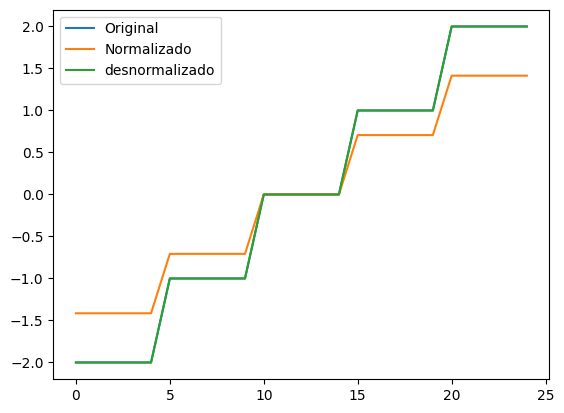

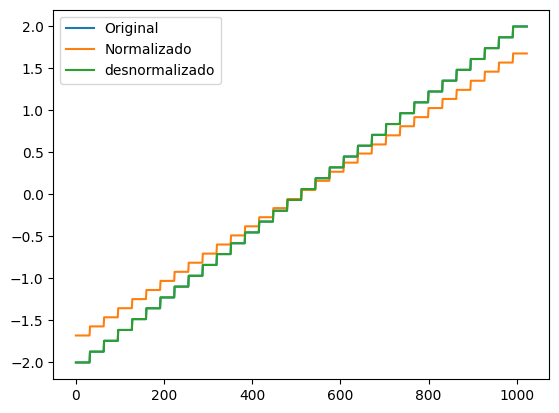

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Y"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [3]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-22 22:42:53.590952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 22:42:53.591002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 22:42:53.592173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 22:42:53.599263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 22:42:54.655647: W tensorflow/compiler/tf2

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [7]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse_sup',
            boundarie = 0.5,
            hidden_sizes = [[25, 15], [37,30], [29, 22], [12, 10], [27, 7], [30, 16]],
            regularizers=[0.2, 0.5],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[25, 15], regularizer=0.2, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] |

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_6,0.721864,0.662800,0.526324,0.491604,0.609178,0.394774,0.478606,0.462722,0.838787,0.650755,1.616211,0.628311,1.014607,0.655059,963.858883,1550.138155
model_1_1_5,0.718670,0.660763,0.522945,0.490793,0.607786,0.399306,0.481498,0.466023,0.840125,0.653074,1.632675,0.631907,1.014774,0.658809,963.836052,1550.115324
model_1_1_4,0.715375,0.658638,0.519335,0.489862,0.606265,0.403984,0.484514,0.469549,0.841662,0.655605,1.649309,0.635597,1.014947,0.662656,963.812761,1550.092032
model_1_1_3,0.711974,0.656422,0.515487,0.488801,0.604611,0.408812,0.487659,0.473308,0.843412,0.658360,1.666107,0.639384,1.015126,0.666604,963.789002,1550.068274
model_1_1_2,0.708464,0.654113,0.511393,0.487604,0.602817,0.413794,0.490937,0.477308,0.845387,0.661347,1.683076,0.643268,1.015310,0.670653,963.764775,1550.044047
model_1_1_1,0.704841,0.651706,0.507045,0.486262,0.600876,0.418936,0.494353,0.481554,0.847601,0.664578,1.700216,0.647252,1.015501,0.674807,963.740075,1550.019347
model_1_1_0,0.701102,0.649198,0.502436,0.484766,0.598783,0.424243,0.497913,0.486057,0.850069,0.668063,1.717524,0.651339,1.015697,0.679068,963.714898,1549.994170


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_24,0.800197,0.710235,0.744555,0.690935,0.748477,0.283592,0.411279,0.912431,0.093420,0.502926,1.349485,0.532533,1.010493,0.555205,964.520438,1550.799710
model_1_2_23,0.798307,0.709213,0.743982,0.693741,0.748177,0.286274,0.412731,0.914480,0.092572,0.503526,1.357884,0.535045,1.010592,0.557823,964.501615,1550.780887
model_1_2_22,0.796365,0.708152,0.743375,0.696441,0.747839,0.289030,0.414236,0.916647,0.091756,0.504201,1.366428,0.537615,1.010694,0.560502,964.482450,1550.761722
model_1_2_21,0.794369,0.707052,0.742734,0.699030,0.747462,0.291863,0.415797,0.918938,0.090973,0.504955,1.375117,0.540243,1.010799,0.563243,964.462941,1550.742213
model_1_2_20,0.792318,0.705912,0.742057,0.701504,0.747044,0.294775,0.417415,0.921356,0.090225,0.505791,1.383947,0.542932,1.010907,0.566045,964.443088,1550.722359
model_1_2_19,0.790209,0.704731,0.741343,0.703856,0.746584,0.297768,0.419092,0.923907,0.089514,0.506711,1.392909,0.545681,1.011017,0.568912,964.422885,1550.702156
model_1_2_18,0.788042,0.703507,0.740590,0.706080,0.746080,0.300843,0.420829,0.926596,0.088842,0.507719,1.402005,0.548492,1.011131,0.571842,964.402332,1550.681603
model_1_2_17,0.785815,0.702239,0.739797,0.708171,0.745530,0.304005,0.422629,0.929428,0.088210,0.508819,1.411225,0.551366,1.011248,0.574839,964.381425,1550.660697
model_1_2_16,0.783526,0.700926,0.738962,0.710124,0.744932,0.307253,0.424493,0.932409,0.087620,0.510014,1.420564,0.554304,1.011368,0.577902,964.360165,1550.639436
model_1_2_15,0.781174,0.699566,0.738085,0.711931,0.744284,0.310592,0.426423,0.935544,0.087074,0.511309,1.430015,0.557308,1.011492,0.581034,964.338548,1550.617820


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_24,0.869608,0.775842,0.920904,0.719635,0.825859,0.185072,0.318160,0.019608,0.294537,0.157073,1.195481,0.430200,1.006848,0.448514,965.374022,1551.653294
model_1_3_23,0.867626,0.774043,0.918165,0.719843,0.825604,0.187885,0.320713,0.020287,0.294319,0.157303,1.199304,0.433457,1.006952,0.451910,965.343850,1551.623122
model_1_3_22,0.865589,0.772188,0.914934,0.720029,0.825268,0.190777,0.323346,0.021088,0.294124,0.157606,1.203198,0.436780,1.007059,0.455375,965.313300,1551.592572
model_1_3_21,0.863495,0.770276,0.911198,0.720192,0.824849,0.193749,0.326061,0.022014,0.293953,0.157984,1.207159,0.440170,1.007169,0.458909,965.282378,1551.561650
model_1_3_20,0.861342,0.768304,0.906945,0.720331,0.824346,0.196804,0.328859,0.023069,0.293807,0.158438,1.211191,0.443626,1.007282,0.462513,965.251090,1551.530361
model_1_3_19,0.859131,0.766272,0.902159,0.720446,0.823755,0.199944,0.331742,0.024255,0.293686,0.158970,1.215296,0.447151,1.007398,0.466187,965.219439,1551.498711
model_1_3_18,0.856858,0.764179,0.896826,0.720536,0.823075,0.203169,0.334714,0.025577,0.293591,0.159584,1.219472,0.450743,1.007517,0.469932,965.187433,1551.466705
model_1_3_17,0.854524,0.762022,0.890933,0.720600,0.822302,0.206483,0.337776,0.027038,0.293524,0.160281,1.223722,0.454403,1.007640,0.473748,965.155079,1551.434351
model_1_3_16,0.852126,0.759799,0.884463,0.720638,0.821436,0.209886,0.340930,0.028642,0.293484,0.161063,1.228046,0.458133,1.007766,0.477637,965.122380,1551.401652
model_1_3_15,0.849663,0.757510,0.877402,0.720649,0.820471,0.213382,0.344179,0.030392,0.293473,0.161932,1.232441,0.461933,1.007895,0.481598,965.089346,1551.368618


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,0.870663,0.775773,0.776781,0.889572,0.787417,0.183574,0.318258,0.535087,0.016656,0.275871,1.142588,0.428456,1.006792,0.446696,965.390270,1551.669542
model_1_4_1,0.871667,0.775675,0.775093,0.897074,0.786294,0.182150,0.318397,0.539133,0.015524,0.277329,1.089796,0.426790,1.006740,0.444959,965.405851,1551.685123
model_1_4_2,0.872621,0.775551,0.773356,0.903942,0.785089,0.180797,0.318573,0.543297,0.014488,0.278893,1.037194,0.425202,1.006690,0.443304,965.420765,1551.700037
model_1_4_3,0.873524,0.775402,0.771571,0.910156,0.783802,0.179514,0.318785,0.547575,0.013551,0.280563,0.984857,0.423691,1.006642,0.441728,965.435006,1551.714277
model_1_4_4,0.874379,0.775229,0.769741,0.915703,0.782434,0.178300,0.319030,0.551962,0.012714,0.282338,0.932886,0.422256,1.006597,0.440233,965.448572,1551.727844
model_1_4_5,0.875187,0.775034,0.767868,0.920574,0.780988,0.177154,0.319307,0.556451,0.011980,0.284215,0.881366,0.420897,1.006555,0.438816,965.461466,1551.740738
model_1_4_6,0.875947,0.774819,0.765956,0.924761,0.779465,0.176075,0.319612,0.561035,0.011348,0.286192,0.830403,0.419613,1.006515,0.437477,965.473692,1551.752964
model_1_4_7,0.876662,0.774584,0.764005,0.928267,0.777867,0.175060,0.319945,0.565711,0.010819,0.288265,0.780086,0.418402,1.006477,0.436214,965.485253,1551.764525
model_1_4_8,0.877333,0.774332,0.762020,0.931095,0.776197,0.174108,0.320303,0.570471,0.010393,0.290432,0.730513,0.417263,1.006442,0.435026,965.496159,1551.775430
model_1_4_9,0.877961,0.774064,0.760001,0.933258,0.774458,0.173217,0.320684,0.575310,0.010067,0.292688,0.754415,0.416194,1.006409,0.433912,965.506417,1551.785688


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_24,0.906955,0.783881,0.363196,0.821268,0.850503,0.132064,0.306750,0.077040,0.241604,0.159322,1.002885,0.363407,1.004886,0.378878,966.048931,1552.328203
model_1_5_23,0.906558,0.783851,0.388890,0.823957,0.853667,0.132627,0.306792,0.073932,0.237969,0.155950,1.007513,0.364180,1.004907,0.379684,966.040426,1552.319698
model_1_5_22,0.906131,0.783793,0.414230,0.826632,0.856802,0.133233,0.306874,0.070866,0.234353,0.152610,1.012176,0.365011,1.004930,0.380550,966.031311,1552.310583
model_1_5_21,0.905673,0.783705,0.439186,0.829289,0.859903,0.133884,0.306999,0.067847,0.230762,0.149304,1.017207,0.365901,1.004954,0.381479,966.021566,1552.300838
model_1_5_20,0.905181,0.783584,0.463725,0.831923,0.862967,0.134582,0.307170,0.064878,0.227200,0.146039,1.022482,0.366854,1.004980,0.382472,966.011166,1552.290437
model_1_5_19,0.904654,0.783430,0.487818,0.834531,0.865988,0.135330,0.307390,0.061964,0.223676,0.142820,1.027802,0.367872,1.005007,0.383533,966.000084,1552.279355
model_1_5_18,0.904091,0.783238,0.511428,0.837105,0.868961,0.136130,0.307662,0.059107,0.220196,0.139652,1.033171,0.368957,1.005037,0.384665,965.988297,1552.267568
model_1_5_17,0.903488,0.783008,0.534522,0.839641,0.871880,0.136984,0.307988,0.056313,0.216768,0.136541,1.038589,0.370114,1.005068,0.385870,965.975778,1552.255049
model_1_5_16,0.902846,0.782737,0.557067,0.842132,0.874739,0.137897,0.308373,0.053586,0.213401,0.133493,1.044055,0.371344,1.005102,0.387153,965.962503,1552.241775
model_1_5_15,0.902160,0.782422,0.579026,0.844570,0.877532,0.138870,0.308820,0.050929,0.210104,0.130517,1.049580,0.372652,1.005138,0.388517,965.948439,1552.227711


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_24,0.940840,0.807520,0.992735,0.933074,0.955276,0.083969,0.273197,0.011515,0.181310,0.096412,0.785532,0.289774,1.003107,0.302111,966.954612,1553.233883
model_1_6_23,0.939968,0.806960,0.993065,0.932509,0.955042,0.085207,0.273992,0.010991,0.182842,0.096917,0.793003,0.291902,1.003153,0.304329,966.925345,1553.204617
model_1_6_22,0.939063,0.806375,0.993359,0.931907,0.954772,0.086491,0.274822,0.010524,0.184472,0.097498,0.800547,0.294094,1.003200,0.306614,966.895426,1553.174697
model_1_6_21,0.938125,0.805764,0.993617,0.931269,0.954466,0.087823,0.275690,0.010116,0.186202,0.098159,0.808168,0.296349,1.003249,0.308966,966.864863,1553.144135
model_1_6_20,0.937152,0.805125,0.993836,0.930592,0.954121,0.089204,0.276596,0.009769,0.188035,0.098902,0.815861,0.298670,1.003301,0.311385,966.833667,1553.112939
model_1_6_19,0.936144,0.804459,0.994016,0.929876,0.953737,0.090634,0.277541,0.009484,0.189975,0.099729,0.823631,0.301056,1.003353,0.313872,966.801841,1553.081113
model_1_6_18,0.935100,0.803765,0.994155,0.929119,0.953313,0.092117,0.278527,0.009263,0.192025,0.100644,0.831477,0.303507,1.003408,0.316428,966.769398,1553.048670
model_1_6_17,0.934018,0.803041,0.994253,0.928321,0.952847,0.093652,0.279555,0.009109,0.194188,0.101648,0.839403,0.306026,1.003465,0.319054,966.736347,1553.015619
model_1_6_16,0.932899,0.802287,0.994307,0.927479,0.952338,0.095241,0.280625,0.009022,0.196469,0.102745,0.847403,0.308611,1.003524,0.321749,966.702697,1552.981969
model_1_6_15,0.931740,0.801502,0.994317,0.926593,0.951785,0.096885,0.281740,0.009006,0.198869,0.103938,0.855482,0.311264,1.003585,0.324515,966.668459,1552.947731


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_24,0.957494,0.825800,0.962243,0.850858,0.950159,0.060331,0.247251,0.055641,0.031012,0.043326,0.899022,0.245624,1.002232,0.256081,967.615806,1553.895078
model_1_7_23,0.957114,0.825338,0.963277,0.855686,0.951613,0.060870,0.247907,0.054116,0.030008,0.042062,0.897229,0.246719,1.002252,0.257222,967.598024,1553.877296
model_1_7_22,0.956714,0.824857,0.964292,0.860362,0.953033,0.061438,0.248590,0.052620,0.029036,0.040828,0.895289,0.247867,1.002273,0.258419,967.579458,1553.858729
model_1_7_21,0.956294,0.824355,0.965286,0.864883,0.954416,0.062035,0.249302,0.051155,0.028096,0.039625,0.893190,0.249068,1.002295,0.259672,967.560113,1553.839385
model_1_7_20,0.955851,0.823833,0.966260,0.869243,0.955762,0.062662,0.250043,0.049721,0.027189,0.038455,0.890925,0.250325,1.002319,0.260981,967.539987,1553.819259
model_1_7_19,0.955388,0.823290,0.967211,0.873436,0.957070,0.063321,0.250814,0.048319,0.026317,0.037318,0.888484,0.251636,1.002343,0.262349,967.519084,1553.798356
model_1_7_18,0.954901,0.822726,0.968140,0.877460,0.958339,0.064011,0.251615,0.046950,0.025480,0.036215,0.885859,0.253004,1.002368,0.263774,967.497407,1553.776679
model_1_7_17,0.954393,0.822139,0.969046,0.881309,0.959567,0.064733,0.252447,0.045615,0.024680,0.035148,0.883038,0.254427,1.002395,0.265258,967.474967,1553.754239
model_1_7_16,0.953861,0.821531,0.969928,0.884980,0.960755,0.065488,0.253310,0.044315,0.023917,0.034116,0.880004,0.255907,1.002423,0.266801,967.451768,1553.731039
model_1_7_15,0.953305,0.820901,0.970787,0.888469,0.961900,0.066277,0.254205,0.043049,0.023191,0.033120,0.876754,0.257444,1.002452,0.268403,967.427819,1553.707091


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.957933,0.825780,0.985215,0.839834,0.899032,0.059708,0.247281,0.006478,0.102194,0.054336,0.891627,0.244352,1.002209,0.254754,967.636583,1553.915855
model_1_8_1,0.958354,0.825744,0.985554,0.837217,0.897619,0.059111,0.247331,0.006329,0.103863,0.055096,0.884304,0.243128,1.002187,0.253478,967.656671,1553.935943
model_1_8_2,0.958756,0.825694,0.985787,0.834580,0.896150,0.058540,0.247403,0.006227,0.105546,0.055887,0.877054,0.241951,1.002166,0.252252,967.676073,1553.955345
model_1_8_3,0.959140,0.825629,0.985914,0.831925,0.894628,0.057995,0.247495,0.006172,0.107240,0.056706,0.869880,0.240823,1.002146,0.251075,967.694781,1553.974052
model_1_8_4,0.959506,0.825550,0.985936,0.829252,0.893052,0.057476,0.247606,0.006162,0.108946,0.057554,0.862774,0.239741,1.002127,0.249947,967.712788,1553.992060
model_1_8_5,0.959855,0.825458,0.985855,0.826562,0.891424,0.056980,0.247738,0.006197,0.110662,0.058430,0.855743,0.238706,1.002108,0.248868,967.730094,1554.009366
model_1_8_6,0.960187,0.825352,0.985671,0.823857,0.889746,0.056509,0.247888,0.006278,0.112388,0.059333,0.848780,0.237717,1.002091,0.247837,967.746696,1554.025968
model_1_8_7,0.960502,0.825233,0.985386,0.821138,0.888018,0.056062,0.248057,0.006403,0.114123,0.060263,0.841887,0.236774,1.002074,0.246854,967.762595,1554.041867
model_1_8_8,0.960801,0.825101,0.985000,0.818406,0.886241,0.055638,0.248244,0.006572,0.115866,0.061219,0.835358,0.235876,1.002059,0.245918,967.777791,1554.057063
model_1_8_9,0.961084,0.824957,0.984515,0.815662,0.884418,0.055236,0.248448,0.006784,0.117617,0.062200,0.829147,0.235023,1.002044,0.245029,967.792282,1554.071553


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_24,0.970911,0.830934,0.896441,0.892076,0.906688,0.041287,0.239965,0.055679,0.047644,0.051661,0.624504,0.203193,1.001528,0.211843,968.374402,1554.653674
model_1_9_23,0.970747,0.830674,0.898834,0.892971,0.908207,0.041520,0.240334,0.054392,0.047249,0.050820,0.629165,0.203765,1.001536,0.212440,968.363149,1554.642421
model_1_9_22,0.970574,0.830406,0.901219,0.893848,0.909714,0.041765,0.240715,0.053110,0.046862,0.049986,0.633879,0.204366,1.001545,0.213066,968.351370,1554.630642
model_1_9_21,0.970393,0.830128,0.903592,0.894705,0.911208,0.042023,0.241108,0.051833,0.046483,0.049158,0.638641,0.204996,1.001555,0.213723,968.339059,1554.618331
model_1_9_20,0.970202,0.829842,0.905955,0.895543,0.912690,0.042294,0.241514,0.050563,0.046113,0.048338,0.643454,0.205656,1.001565,0.214411,968.326210,1554.605482
model_1_9_19,0.970002,0.829547,0.908305,0.896361,0.914157,0.042578,0.241933,0.049300,0.045752,0.047526,0.648319,0.206345,1.001575,0.215130,968.312821,1554.592093
model_1_9_18,0.969792,0.829243,0.910641,0.897158,0.915609,0.042876,0.242364,0.048044,0.045401,0.046722,0.653234,0.207065,1.001586,0.215881,968.298883,1554.578155
model_1_9_17,0.969572,0.828930,0.912963,0.897933,0.917045,0.043188,0.242809,0.046795,0.045058,0.045927,0.658205,0.207817,1.001598,0.216664,968.284394,1554.563666
model_1_9_16,0.969343,0.828607,0.915269,0.898687,0.918466,0.043514,0.243268,0.045556,0.044725,0.045140,0.663226,0.208600,1.001610,0.217480,968.269352,1554.548624
model_1_9_15,0.969102,0.828274,0.917558,0.899419,0.919869,0.043855,0.243740,0.044325,0.044402,0.044364,0.668302,0.209415,1.001623,0.218330,968.253750,1554.533021


DataFrame salvo em ../results/metrics_1_9
Testando combinacao2: Hidden Size=[25, 15], regularizer=0.2, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_5,0.868751,0.690732,-0.946245,0.724962,0.341672,0.186289,0.438962,0.554693,0.222816,0.388754,1.081855,0.431612,1.006893,0.449986,965.360916,1551.640187
model_2_0_4,0.861981,0.689823,-0.807649,0.714218,0.367747,0.195898,0.440251,0.515192,0.231521,0.373356,1.078157,0.442604,1.007248,0.461446,965.260322,1551.539593
model_2_0_6,0.873001,0.689698,-1.082253,0.728533,0.311299,0.180257,0.440428,0.593456,0.219923,0.406690,1.084711,0.424567,1.006670,0.442642,965.426741,1551.706013
model_2_0_7,0.875306,0.687259,-1.214223,0.726674,0.278178,0.176985,0.443890,0.631068,0.221429,0.426249,1.086922,0.420696,1.006548,0.438606,965.463380,1551.742652
model_2_0_3,0.851986,0.686296,-0.668141,0.694191,0.387676,0.210084,0.445258,0.475431,0.247745,0.361588,1.073338,0.458349,1.007773,0.477862,965.120497,1551.399769
model_2_0_8,0.876134,0.683835,-1.341017,0.720807,0.243555,0.175810,0.448751,0.667205,0.226183,0.446694,1.088635,0.419297,1.006505,0.437147,965.476705,1551.755977
model_2_0_9,0.875859,0.679752,-1.461802,0.712072,0.208416,0.176200,0.454545,0.701630,0.233259,0.467444,1.089964,0.419762,1.006519,0.437632,965.472268,1551.751540
model_2_0_2,0.837921,0.679303,-0.529467,0.662381,0.399321,0.230047,0.455183,0.435908,0.273515,0.354712,1.070880,0.479632,1.008512,0.500051,964.938942,1551.218214
model_2_0_10,0.874778,0.675265,-1.576016,0.701376,0.173517,0.177734,0.460914,0.734182,0.241924,0.488053,1.090994,0.421585,1.006576,0.439533,965.454933,1551.734205
model_2_0_11,0.873127,0.670567,-1.683335,0.689429,0.139424,0.180078,0.467583,0.764768,0.251603,0.508185,1.091791,0.424356,1.006663,0.442422,965.428729,1551.708001


DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_1,0.880824,0.662114,-0.784595,0.879648,0.616877,0.169153,0.479580,0.314548,0.111766,0.213157,1.020808,0.411282,1.006259,0.428791,965.553904,1551.833176
model_2_1_2,0.878671,0.661177,-1.109263,0.787768,0.488768,0.172209,0.480910,0.371773,0.197091,0.284432,1.013847,0.414980,1.006372,0.432647,965.518096,1551.797368
model_2_1_3,0.875382,0.659149,-1.354577,0.697200,0.374324,0.176877,0.483789,0.415011,0.281199,0.348105,1.006980,0.420568,1.006545,0.438472,965.464597,1551.743868
model_2_1_0,0.878747,0.659143,-0.390781,0.953540,0.740926,0.172101,0.483797,0.245135,0.043145,0.144140,1.063160,0.414851,1.006368,0.432512,965.519345,1551.798617
model_2_1_4,0.871979,0.656868,-1.549564,0.617140,0.276623,0.181707,0.487026,0.449379,0.355546,0.402463,1.001818,0.426271,1.006723,0.444418,965.410723,1551.689995
model_2_1_5,0.868473,0.654338,-1.721570,0.548356,0.191972,0.186684,0.490617,0.479696,0.419424,0.449560,1.002432,0.432069,1.006907,0.450463,965.356676,1551.635948
model_2_1_6,0.864701,0.651443,-1.885060,0.488617,0.116217,0.192037,0.494726,0.508513,0.474901,0.491707,1.008650,0.438221,1.007105,0.456877,965.300131,1551.579402
model_2_1_7,0.860604,0.648150,-2.045288,0.435670,0.046649,0.197852,0.499400,0.536754,0.524070,0.530412,1.018872,0.444806,1.007321,0.463742,965.240468,1551.519740


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_24,0.899858,0.722525,0.788649,0.762293,0.782171,0.142137,0.393836,0.156835,0.728001,0.442418,0.380998,0.377011,1.005259,0.393061,965.901923,1552.181195
model_2_2_23,0.899955,0.722362,0.791298,0.762201,0.782585,0.142000,0.394066,0.154869,0.728282,0.441576,0.387534,0.376828,1.005254,0.392871,965.903862,1552.183133
model_2_2_22,0.900053,0.722174,0.794215,0.762111,0.783050,0.141861,0.394333,0.152705,0.728559,0.440632,0.394790,0.376644,1.005249,0.392678,965.905822,1552.185094
model_2_2_21,0.900149,0.721956,0.797423,0.762023,0.783570,0.141723,0.394643,0.150324,0.728827,0.439576,0.402859,0.376462,1.005244,0.392489,965.907755,1552.187027
model_2_2_20,0.900241,0.721701,0.800946,0.761942,0.784153,0.141593,0.395005,0.147710,0.729074,0.438392,0.411820,0.376288,1.005239,0.392308,965.909599,1552.188871
model_2_2_19,0.900325,0.721404,0.804810,0.761872,0.784806,0.141475,0.395427,0.144843,0.729289,0.437066,0.421774,0.376131,1.005235,0.392144,965.911270,1552.190542
model_2_2_18,0.900394,0.721055,0.809040,0.761817,0.785537,0.141377,0.395922,0.141703,0.729457,0.435581,0.432840,0.376001,1.005231,0.392008,965.912653,1552.191924
model_2_2_17,0.900440,0.720644,0.813665,0.761784,0.786357,0.141310,0.396505,0.138272,0.729560,0.433916,0.445137,0.375913,1.005229,0.391916,965.913593,1552.192865
model_2_2_16,0.900455,0.720160,0.818710,0.761779,0.787275,0.141289,0.397193,0.134528,0.729576,0.432052,0.458800,0.375884,1.005228,0.391886,965.913896,1552.193168
model_2_2_15,0.900426,0.719585,0.824201,0.761810,0.788302,0.141331,0.398009,0.130453,0.729478,0.429966,0.473993,0.375941,1.005229,0.391945,965.913296,1552.192568


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_3,0.940196,0.765057,0.894066,0.978326,0.935300,0.084883,0.333467,0.192869,0.020608,0.106738,0.325412,0.291347,1.003141,0.303750,966.932966,1553.212237
model_2_3_4,0.940384,0.764258,0.862951,0.973361,0.916700,0.084616,0.334602,0.249519,0.025329,0.137424,0.326386,0.290889,1.003131,0.303272,966.939259,1553.218531
model_2_3_2,0.938104,0.761886,0.925399,0.982874,0.953900,0.087853,0.337968,0.135822,0.016284,0.076053,0.328755,0.296400,1.003251,0.309018,966.864183,1553.143455
model_2_3_5,0.940444,0.761654,0.838675,0.968433,0.901885,0.084531,0.338297,0.293717,0.030015,0.161866,0.331040,0.290742,1.003128,0.303120,966.941271,1553.220543
model_2_3_6,0.940574,0.758449,0.820291,0.963674,0.890369,0.084346,0.342846,0.327188,0.034540,0.180864,0.335108,0.290424,1.003121,0.302788,966.945650,1553.224921
model_2_3_7,0.940624,0.755101,0.805717,0.959092,0.881007,0.084276,0.347599,0.353721,0.038896,0.196309,0.337820,0.290303,1.003118,0.302661,966.947326,1553.226598
model_2_3_1,0.930921,0.753256,0.942869,0.986551,0.964600,0.098048,0.350217,0.104016,0.012788,0.058402,0.340156,0.313126,1.003628,0.326456,966.644600,1552.923872
model_2_3_8,0.940481,0.751775,0.793466,0.954677,0.872975,0.084478,0.352320,0.376027,0.043095,0.209560,0.339565,0.290652,1.003126,0.303025,966.942520,1553.221792
model_2_3_9,0.940099,0.748537,0.782618,0.950414,0.865760,0.085021,0.356915,0.395778,0.047148,0.221462,0.340714,0.291584,1.003146,0.303997,966.929708,1553.208980
model_2_3_10,0.939471,0.745414,0.772621,0.946291,0.859056,0.085912,0.361348,0.413979,0.051067,0.232523,0.341517,0.293108,1.003179,0.305586,966.908854,1553.188125


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_0,0.920901,0.714699,0.851578,0.657762,0.869053,0.112270,0.404943,0.471115,0.063299,0.267207,0.568760,0.335067,1.004154,0.349332,966.373696,1552.652968
model_2_4_1,0.920254,0.713946,0.843118,0.600138,0.859862,0.113188,0.406012,0.497970,0.073957,0.285963,0.765863,0.336434,1.004188,0.350756,966.357419,1552.636691
model_2_4_2,0.918680,0.712466,0.834355,0.535876,0.850134,0.115422,0.408113,0.525786,0.085843,0.305814,0.942487,0.339738,1.004271,0.354201,966.318326,1552.597598
model_2_4_3,0.916434,0.710457,0.825550,0.466524,0.840143,0.118610,0.410964,0.553733,0.098670,0.326201,1.100990,0.344398,1.004389,0.359059,966.263834,1552.543106
model_2_4_4,0.913727,0.708084,0.816896,0.393885,0.830120,0.122452,0.414333,0.581202,0.112105,0.346653,1.243284,0.349931,1.004531,0.364829,966.200072,1552.479344
model_2_4_5,0.910730,0.705480,0.808532,0.319715,0.820254,0.126706,0.418029,0.607752,0.125823,0.366787,1.370978,0.355958,1.004688,0.371112,966.131774,1552.411046
model_2_4_6,0.907578,0.702752,0.800552,0.245551,0.810686,0.131180,0.421900,0.633080,0.139540,0.386310,1.485512,0.362187,1.004854,0.377607,966.062373,1552.341645
model_2_4_7,0.904375,0.699984,0.793019,0.172664,0.801524,0.135726,0.425829,0.656992,0.153021,0.405006,1.588178,0.368410,1.005022,0.384094,965.994233,1552.273504
model_2_4_8,0.901199,0.697239,0.785967,0.102034,0.792838,0.140234,0.429725,0.679376,0.166084,0.422730,1.680160,0.374478,1.005189,0.390421,965.928884,1552.208156
model_2_4_9,0.898106,0.694562,0.779411,0.034381,0.784673,0.144623,0.433525,0.700187,0.178597,0.439392,1.762532,0.380294,1.005351,0.396484,965.867244,1552.146516


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_10,0.958208,0.753282,0.486645,0.972695,0.899488,0.059318,0.350181,0.220838,0.056821,0.138830,1.421150,0.243553,1.002195,0.253922,967.649681,1553.928953
model_2_5_9,0.958053,0.753211,0.527356,0.974163,0.906934,0.059538,0.350281,0.203325,0.053766,0.128545,1.477952,0.244005,1.002203,0.254393,967.642269,1553.921541
model_2_5_11,0.957877,0.752923,0.445424,0.971278,0.892002,0.059787,0.350690,0.238571,0.059769,0.149170,1.463203,0.244514,1.002212,0.254923,967.633933,1553.913205
model_2_5_8,0.957256,0.752556,0.566445,0.975726,0.914198,0.060669,0.351210,0.186510,0.050514,0.118512,1.551529,0.246312,1.002245,0.256798,967.604629,1553.883901
model_2_5_12,0.957190,0.752259,0.404556,0.969897,0.884597,0.060763,0.351633,0.256152,0.062645,0.159398,1.499810,0.246501,1.002248,0.256995,967.601563,1553.880834
model_2_5_13,0.956250,0.751386,0.364698,0.968547,0.877373,0.062096,0.352872,0.273298,0.065452,0.169375,1.531674,0.249192,1.002298,0.259800,967.558132,1553.837404
model_2_5_7,0.955632,0.751127,0.602570,0.977466,0.921135,0.062974,0.353239,0.170969,0.046893,0.108931,1.628092,0.250945,1.002330,0.261629,967.530080,1553.809352
model_2_5_14,0.955141,0.750379,0.326319,0.967235,0.870408,0.063671,0.354301,0.289808,0.068183,0.178995,1.559432,0.252331,1.002356,0.263073,967.508059,1553.787330
model_2_5_15,0.953928,0.749295,0.289743,0.965968,0.863758,0.065393,0.355840,0.305543,0.070820,0.188181,1.583652,0.255721,1.002420,0.266607,967.454677,1553.733949
model_2_5_6,0.952967,0.748696,0.634221,0.979515,0.927607,0.066756,0.356690,0.157353,0.042629,0.099991,1.706504,0.258372,1.002470,0.269372,967.413415,1553.692686


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_2,0.967042,0.756832,0.913342,0.958246,0.921182,0.046779,0.345141,0.263932,0.015532,0.139732,0.578002,0.216284,1.001731,0.225492,968.124650,1554.403921
model_2_6_3,0.967181,0.756828,0.913703,0.952037,0.920840,0.046582,0.345148,0.262832,0.017841,0.140337,0.535428,0.215829,1.001724,0.225017,968.133076,1554.412348
model_2_6_4,0.967248,0.756779,0.914013,0.945776,0.920449,0.046487,0.345216,0.261890,0.020170,0.141030,0.497165,0.215609,1.001720,0.224788,968.137149,1554.416420
model_2_6_1,0.966810,0.756777,0.912921,0.964248,0.921449,0.047108,0.345220,0.265216,0.013299,0.139258,0.625367,0.217044,1.001743,0.226284,968.110623,1554.389894
model_2_6_5,0.967260,0.756700,0.914278,0.939583,0.920028,0.046470,0.345330,0.261081,0.022474,0.141777,0.462770,0.215568,1.001719,0.224746,968.137907,1554.417179
model_2_6_0,0.966458,0.756641,0.912427,0.969845,0.921612,0.047608,0.345413,0.266719,0.011217,0.138968,0.678074,0.218193,1.001762,0.227482,968.089508,1554.368780
model_2_6_6,0.967232,0.756598,0.914507,0.933544,0.919590,0.046510,0.345474,0.260386,0.024720,0.142553,0.431852,0.215661,1.001721,0.224842,968.136193,1554.415464
model_2_6_7,0.967174,0.756483,0.914703,0.927725,0.919148,0.046591,0.345637,0.259787,0.026885,0.143336,0.404056,0.215850,1.001724,0.225039,968.132688,1554.411960
model_2_6_8,0.967096,0.756359,0.914873,0.922170,0.918711,0.046702,0.345813,0.259270,0.028952,0.144111,0.379064,0.216107,1.001728,0.225307,968.127934,1554.407206
model_2_6_9,0.967004,0.756232,0.915020,0.916908,0.918285,0.046833,0.345993,0.258823,0.030909,0.144866,0.356597,0.216409,1.001733,0.225622,968.122348,1554.401620


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_3,0.974932,0.778123,0.987898,0.887232,0.937867,0.035580,0.314922,0.011888,0.181611,0.096749,0.137634,0.188627,1.001316,0.196657,968.671942,1554.951214
model_2_7_2,0.976040,0.778082,0.988895,0.896916,0.943190,0.034008,0.314980,0.010908,0.166014,0.088461,0.141043,0.184412,1.001258,0.192263,968.762331,1555.041602
model_2_7_4,0.973804,0.778061,0.986965,0.878190,0.932897,0.037181,0.315010,0.012804,0.196172,0.104488,0.134396,0.192823,1.001376,0.201032,968.583926,1554.863197
model_2_7_5,0.972685,0.777926,0.986096,0.869800,0.928285,0.038769,0.315202,0.013658,0.209683,0.111671,0.131359,0.196899,1.001434,0.205282,968.500253,1554.779525
model_2_7_1,0.977087,0.777900,0.989959,0.907205,0.948846,0.032522,0.315238,0.009863,0.149444,0.079654,0.144597,0.180337,1.001203,0.188015,968.851701,1555.130973
model_2_7_6,0.971595,0.777741,0.985289,0.862054,0.924024,0.040317,0.315464,0.014450,0.222159,0.118305,0.128523,0.200790,1.001492,0.209338,968.421977,1554.701249
model_2_7_0,0.978018,0.777527,0.991090,0.918018,0.954794,0.031201,0.315768,0.008752,0.132031,0.070391,0.148251,0.176637,1.001154,0.184156,968.934642,1555.213913
model_2_7_7,0.970548,0.777523,0.984541,0.854930,0.920105,0.041803,0.315774,0.015185,0.233632,0.124408,0.125894,0.204459,1.001547,0.213163,968.349552,1554.628823
model_2_7_8,0.969552,0.777285,0.983851,0.848399,0.916509,0.043217,0.316111,0.015863,0.244150,0.130006,0.123468,0.207887,1.001599,0.216737,968.283049,1554.562320
model_2_7_9,0.968613,0.777038,0.983216,0.842427,0.913221,0.044549,0.316462,0.016487,0.253768,0.135127,0.121239,0.211067,1.001648,0.220052,968.222323,1554.501595


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.964310,0.773331,0.967031,0.950612,0.970424,0.050657,0.321724,0.060995,0.026374,0.043684,0.120649,0.225071,1.001874,0.234653,967.965354,1554.244625
model_2_8_1,0.966593,0.771691,0.958272,0.936973,0.962473,0.047416,0.324052,0.077200,0.033658,0.055429,0.139764,0.217752,1.001754,0.227022,968.097589,1554.376861
model_2_8_2,0.968037,0.769724,0.950150,0.922998,0.954860,0.045366,0.326844,0.092226,0.041120,0.066673,0.155990,0.212994,1.001679,0.222061,968.185974,1554.465246
model_2_8_3,0.968895,0.767598,0.942958,0.908744,0.947779,0.044148,0.329861,0.105531,0.048732,0.077132,0.169826,0.210115,1.001634,0.219060,968.240394,1554.519666
model_2_8_4,0.969326,0.765413,0.936722,0.894286,0.941260,0.043537,0.332962,0.117069,0.056453,0.086761,0.181718,0.208655,1.001611,0.217538,968.268285,1554.547557
model_2_8_5,0.969438,0.763230,0.931356,0.879738,0.935270,0.043379,0.336061,0.126996,0.064222,0.095609,0.192020,0.208275,1.001605,0.217142,968.275577,1554.554848
model_2_8_6,0.969309,0.761085,0.926746,0.865231,0.929760,0.043561,0.339105,0.135526,0.071969,0.103747,0.201013,0.208713,1.001612,0.217598,968.267179,1554.546451
model_2_8_7,0.969001,0.759005,0.922776,0.850900,0.924683,0.043998,0.342058,0.142869,0.079622,0.111246,0.208916,0.209758,1.001628,0.218688,968.247208,1554.526480
model_2_8_8,0.968562,0.757006,0.919347,0.836874,0.920000,0.044621,0.344894,0.149214,0.087112,0.118163,0.215893,0.211238,1.001651,0.220231,968.219084,1554.498356
model_2_8_9,0.968031,0.755101,0.916372,0.823263,0.915676,0.045375,0.347598,0.154717,0.094381,0.124549,0.222090,0.213015,1.001679,0.222084,968.185566,1554.464838


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_16,0.977350,0.776526,0.913882,0.825209,0.875362,0.032148,0.317189,0.068569,0.126137,0.097353,0.722668,0.179299,1.001189,0.186932,968.874808,1555.154079
model_2_9_15,0.977753,0.776518,0.916491,0.829312,0.878587,0.031576,0.317200,0.066492,0.123176,0.094834,0.718726,0.177695,1.001168,0.185260,968.910736,1555.190008
model_2_9_17,0.976968,0.776518,0.911505,0.821492,0.872433,0.032691,0.317201,0.070462,0.128819,0.099641,0.726146,0.180806,1.001210,0.188503,968.841320,1555.120591
model_2_9_18,0.976608,0.776498,0.909340,0.818127,0.869775,0.033202,0.317229,0.072186,0.131248,0.101717,0.729218,0.182214,1.001228,0.189971,968.810289,1555.089560
model_2_9_14,0.978175,0.776487,0.919346,0.833838,0.882133,0.030978,0.317244,0.064219,0.119910,0.092064,0.714250,0.176006,1.001146,0.183499,968.948958,1555.228229
model_2_9_19,0.976271,0.776469,0.907371,0.815081,0.867365,0.033680,0.317270,0.073754,0.133445,0.103599,0.731944,0.183522,1.001246,0.191335,968.781680,1555.060952
model_2_9_20,0.975957,0.776435,0.905583,0.812327,0.865181,0.034126,0.317318,0.075177,0.135433,0.105305,0.734356,0.184732,1.001263,0.192596,968.755406,1555.034677
model_2_9_13,0.978609,0.776427,0.922465,0.838828,0.886028,0.030361,0.317330,0.061735,0.116308,0.089022,0.709152,0.174244,1.001123,0.181662,968.989203,1555.268474
model_2_9_21,0.975666,0.776398,0.903960,0.809836,0.863204,0.034539,0.317370,0.076469,0.137230,0.106850,0.736503,0.185846,1.001278,0.193758,968.731352,1555.010623
model_2_9_22,0.975397,0.776359,0.902489,0.807586,0.861414,0.034920,0.317425,0.077641,0.138855,0.108248,0.738410,0.186869,1.001292,0.194824,968.709388,1554.988660


DataFrame salvo em ../results/metrics_2_9
Testando combinacao3: Hidden Size=[25, 15], regularizer=0.5, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_7,0.772785,0.670812,0.008575,0.757360,0.750097,0.322499,0.467234,0.382594,0.469122,0.425858,0.837465,0.567890,1.011933,0.592066,964.263310,1550.542582
model_3_4_6,0.768930,0.667739,0.004434,0.752729,0.747001,0.327971,0.471597,0.384192,0.478076,0.431134,0.858635,0.572687,1.012135,0.597068,964.229662,1550.508934
model_3_4_5,0.765000,0.664607,0.000257,0.748012,0.743852,0.333548,0.476041,0.385804,0.487194,0.436499,0.879953,0.577536,1.012341,0.602123,964.195937,1550.475209
model_3_4_4,0.760995,0.661417,-0.003966,0.743211,0.740650,0.339233,0.480570,0.387434,0.496476,0.441955,0.901412,0.582437,1.012552,0.607232,964.162138,1550.441409
model_3_4_3,0.756913,0.658166,-0.008239,0.738325,0.737395,0.345027,0.485183,0.389083,0.505923,0.447503,0.923010,0.587390,1.012766,0.612396,964.128266,1550.407537
model_3_4_2,0.752752,0.654854,-0.012572,0.733354,0.734084,0.350933,0.489884,0.390755,0.515534,0.453145,0.944744,0.592396,1.012985,0.617615,964.094321,1550.373593
model_3_4_1,0.748511,0.651480,-0.016975,0.728299,0.730718,0.356952,0.494674,0.392454,0.525307,0.458881,0.966605,0.597455,1.013207,0.622890,964.060307,1550.339578
model_3_4_0,0.744188,0.648042,-0.021460,0.723160,0.727295,0.363088,0.499554,0.394185,0.535243,0.464714,0.988592,0.602568,1.013434,0.628220,964.026222,1550.305494


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_24,0.908016,0.781743,0.826123,0.961321,0.929145,0.130558,0.309784,0.069325,0.010313,0.039819,0.810245,0.361328,1.004831,0.376711,966.071876,1552.351147
model_3_5_23,0.906385,0.780568,0.827715,0.960694,0.929561,0.132873,0.311452,0.068691,0.010480,0.039586,0.803448,0.364517,1.004916,0.380036,966.036726,1552.315997
model_3_5_22,0.904699,0.779342,0.829133,0.959610,0.929807,0.135267,0.313193,0.068126,0.010769,0.039447,0.796928,0.367786,1.005005,0.383443,966.001015,1552.280287
model_3_5_21,0.902955,0.778064,0.830369,0.958057,0.929877,0.137741,0.315006,0.067633,0.011183,0.039408,0.791419,0.371135,1.005096,0.386935,965.964754,1552.244026
model_3_5_20,0.901153,0.776733,0.831419,0.956023,0.929767,0.140299,0.316895,0.067214,0.011726,0.039470,0.786043,0.374565,1.005191,0.390511,965.927957,1552.207229
model_3_5_19,0.899291,0.775349,0.832275,0.953494,0.929471,0.142942,0.318860,0.066873,0.012400,0.039636,0.780621,0.378076,1.005289,0.394172,965.890638,1552.169909
model_3_5_18,0.897368,0.773908,0.832932,0.950459,0.928984,0.145671,0.320905,0.066611,0.013209,0.039910,0.775151,0.381669,1.005390,0.397917,965.852807,1552.132079
model_3_5_17,0.895382,0.772411,0.833382,0.946904,0.928300,0.148490,0.323030,0.066431,0.014157,0.040294,0.769630,0.385343,1.005494,0.401748,965.814482,1552.093753
model_3_5_16,0.893333,0.770855,0.833620,0.942815,0.927414,0.151399,0.325238,0.066337,0.015247,0.040792,0.764057,0.389100,1.005602,0.405665,965.775675,1552.054946
model_3_5_15,0.891217,0.769239,0.833637,0.938179,0.926321,0.154401,0.327531,0.066330,0.016484,0.041407,0.758435,0.392939,1.005713,0.409668,965.736399,1552.015670


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_3_6_24,0.931400,0.802592,0.758020,0.954084,0.916031,0.097367,0.280192,0.172432,0.135564,0.153998,0.692553,0.312037,1.003603,0.325321,966.658533,1552.937805
model_3_6_23,0.930952,0.802218,0.759290,0.954501,0.916613,0.098004,0.280723,0.171528,0.134334,0.152931,0.696656,0.313056,1.003626,0.326384,966.645490,1552.924762
model_3_6_22,0.930474,0.801816,0.760549,0.954875,0.917159,0.098682,0.281293,0.170631,0.133229,0.151930,0.700794,0.314138,1.003651,0.327511,966.631696,1552.910968
model_3_6_21,0.929966,0.801386,0.761795,0.955204,0.917666,0.099404,0.281904,0.169742,0.132256,0.150999,0.704966,0.315283,1.003678,0.328706,966.617135,1552.896407
model_3_6_20,0.929426,0.800926,0.763027,0.955487,0.918133,0.100169,0.282557,0.168864,0.131422,0.150143,0.709171,0.316496,1.003706,0.329969,966.601784,1552.881056
model_3_6_19,0.928854,0.800434,0.764244,0.955720,0.918557,0.100982,0.283254,0.167998,0.130735,0.149366,0.713411,0.317776,1.003736,0.331305,966.585632,1552.864903
model_3_6_18,0.928247,0.799911,0.765443,0.955900,0.918935,0.101842,0.283997,0.167143,0.130203,0.148673,0.717689,0.319127,1.003768,0.332713,966.568659,1552.847931
model_3_6_17,0.927606,0.799354,0.766623,0.956025,0.919265,0.102753,0.284787,0.166302,0.129832,0.148068,0.721999,0.320551,1.003802,0.334198,966.550851,1552.830123
model_3_6_16,0.926927,0.798763,0.767781,0.956093,0.919544,0.103716,0.285627,0.165477,0.129634,0.147555,0.726343,0.322050,1.003838,0.335761,966.532190,1552.811461
model_3_6_15,0.926210,0.798135,0.768918,0.956099,0.919770,0.104734,0.286518,0.164667,0.129615,0.147141,0.730723,0.323626,1.003875,0.337404,966.512662,1552.791934


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_3_7_24,0.947838,0.822381,0.919307,0.945390,0.923890,0.074036,0.252104,0.190445,0.022123,0.106284,0.653856,0.272096,1.002739,0.283680,967.206400,1553.485672
model_3_7_23,0.947358,0.821776,0.919875,0.944122,0.924186,0.074717,0.252963,0.189104,0.022637,0.105870,0.654738,0.273344,1.002765,0.284981,967.188091,1553.467363
model_3_7_22,0.946867,0.821158,0.920449,0.942815,0.924482,0.075415,0.253840,0.187750,0.023167,0.105458,0.655628,0.274618,1.002790,0.286309,967.169495,1553.448767
model_3_7_21,0.946363,0.820528,0.921027,0.941469,0.924775,0.076131,0.254734,0.186385,0.023712,0.105048,0.656527,0.275918,1.002817,0.287664,967.150611,1553.429883
model_3_7_20,0.945846,0.819885,0.921611,0.940082,0.925067,0.076864,0.255646,0.185008,0.024274,0.104641,0.657443,0.277244,1.002844,0.289046,967.131436,1553.410708
model_3_7_19,0.945316,0.819229,0.922199,0.938653,0.925357,0.077616,0.256578,0.183620,0.024853,0.104236,0.658378,0.278596,1.002872,0.290457,967.111963,1553.391235
model_3_7_18,0.944773,0.818560,0.922792,0.937181,0.925644,0.078387,0.257528,0.182220,0.025449,0.103835,0.659339,0.279977,1.002900,0.291896,967.092196,1553.371468
model_3_7_17,0.944216,0.817876,0.923389,0.935664,0.925929,0.079177,0.258499,0.180810,0.026064,0.103437,0.660325,0.281385,1.002930,0.293364,967.072132,1553.351404
model_3_7_16,0.943645,0.817178,0.923992,0.934101,0.926211,0.079987,0.259490,0.179388,0.026697,0.103043,0.661348,0.282820,1.002960,0.294861,967.051772,1553.331044
model_3_7_15,0.943060,0.816464,0.924599,0.932490,0.926490,0.080818,0.260502,0.177956,0.027350,0.102653,0.662413,0.284285,1.002990,0.296388,967.031109,1553.310380


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_24,0.960579,0.829577,0.858382,0.948218,0.937963,0.055953,0.241891,0.071840,0.046639,0.059239,0.539435,0.236543,1.002070,0.246613,967.766498,1554.045770
model_3_8_23,0.960286,0.829473,0.861289,0.948900,0.939056,0.056369,0.242038,0.070365,0.046025,0.058195,0.541792,0.237421,1.002086,0.247529,967.751675,1554.030946
model_3_8_22,0.959978,0.829356,0.864148,0.949574,0.940134,0.056806,0.242204,0.068915,0.045418,0.057166,0.544176,0.238339,1.002102,0.248486,967.736241,1554.015513
model_3_8_21,0.959656,0.829227,0.866957,0.950238,0.941193,0.057263,0.242387,0.067490,0.044820,0.056155,0.546580,0.239297,1.002119,0.249484,967.720199,1553.999471
model_3_8_20,0.959318,0.829085,0.869715,0.950892,0.942234,0.057742,0.242590,0.066091,0.044231,0.055161,0.549014,0.240296,1.002136,0.250526,967.703537,1553.982809
model_3_8_19,0.958965,0.828929,0.872418,0.951535,0.943255,0.058243,0.242811,0.064720,0.043651,0.054186,0.551477,0.241336,1.002155,0.251611,967.686254,1553.965526
model_3_8_18,0.958596,0.828759,0.875064,0.952167,0.944256,0.058767,0.243052,0.063378,0.043082,0.053230,0.553968,0.242419,1.002174,0.252740,967.668343,1553.947615
model_3_8_17,0.958210,0.828575,0.877650,0.952787,0.945235,0.059314,0.243312,0.062066,0.042524,0.052295,0.556484,0.243546,1.002195,0.253914,967.649804,1553.929076
model_3_8_16,0.957808,0.828377,0.880173,0.953395,0.946192,0.059886,0.243594,0.060786,0.041976,0.051381,0.559031,0.244716,1.002216,0.255134,967.630630,1553.909902
model_3_8_15,0.957388,0.828164,0.882631,0.953989,0.947125,0.060482,0.243896,0.059539,0.041441,0.050490,0.561748,0.245931,1.002238,0.256401,967.610820,1553.890092


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_15,0.968934,0.831075,0.983036,0.945007,0.977602,0.044094,0.239765,0.048624,0.040299,0.044462,0.471995,0.209985,1.001631,0.218925,968.242870,1554.522142
model_3_9_14,0.968544,0.831075,0.982549,0.947345,0.977682,0.044648,0.239765,0.050019,0.038586,0.044302,0.475919,0.211300,1.001652,0.220296,968.217900,1554.497172
model_3_9_16,0.969308,0.831064,0.983510,0.942632,0.977505,0.043562,0.239780,0.047266,0.042040,0.044653,0.468110,0.208715,1.001612,0.217601,968.267134,1554.546406
model_3_9_13,0.968137,0.831063,0.982050,0.949643,0.977746,0.045224,0.239782,0.051449,0.036902,0.044176,0.479880,0.212660,1.001673,0.221714,968.192237,1554.471509
model_3_9_17,0.969668,0.831042,0.983971,0.940221,0.977393,0.043052,0.239811,0.045944,0.043807,0.044875,0.464262,0.207490,1.001593,0.216323,968.290692,1554.569964
model_3_9_12,0.967715,0.831040,0.981538,0.951899,0.977793,0.045824,0.239815,0.052916,0.035249,0.044082,0.483879,0.214066,1.001696,0.223179,968.165891,1554.445162
model_3_9_18,0.970012,0.831010,0.984420,0.937777,0.977266,0.042563,0.239857,0.044657,0.045598,0.045128,0.460449,0.206308,1.001575,0.215091,968.313533,1554.592805
model_3_9_11,0.967276,0.831005,0.981014,0.954111,0.977823,0.046448,0.239864,0.054419,0.033628,0.044023,0.487917,0.215517,1.001719,0.224692,968.138864,1554.418136
model_3_9_19,0.970342,0.830967,0.984856,0.935301,0.977124,0.042095,0.239918,0.043407,0.047412,0.045410,0.456678,0.205171,1.001558,0.213905,968.335653,1554.614925
model_3_9_10,0.966819,0.830957,0.980477,0.956277,0.977835,0.047095,0.239932,0.055958,0.032041,0.043999,0.491994,0.217014,1.001743,0.226253,968.111174,1554.390446


DataFrame salvo em ../results/metrics_3_9
Testando combinacao4: Hidden Size=[25, 15], regularizer=0.5, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_0_15,0.904456,0.817735,0.574636,-1.098336,0.423254,0.135611,0.258699,0.512394,0.277873,0.395133,0.437780,0.368254,1.005018,0.383931,965.995933,1552.275205
model_4_0_14,0.903534,0.817329,0.576901,-1.079040,0.427110,0.136919,0.259275,0.509666,0.275318,0.392492,0.454640,0.370026,1.005066,0.385778,965.976733,1552.256005
model_4_0_13,0.902263,0.816629,0.579097,-1.058674,0.431009,0.138724,0.260268,0.507020,0.272621,0.389820,0.473387,0.372457,1.005133,0.388313,965.950540,1552.229812
model_4_0_12,0.900545,0.815547,0.581148,-1.037353,0.434873,0.141162,0.261804,0.504549,0.269797,0.387173,0.494232,0.375715,1.005223,0.391710,965.915694,1552.194965
model_4_0_11,0.898261,0.813970,0.582952,-1.015253,0.438595,0.144404,0.264043,0.502376,0.266871,0.384623,0.517411,0.380005,1.005343,0.396183,965.870279,1552.149550
model_4_0_10,0.895260,0.811755,0.584380,-0.992629,0.442037,0.148663,0.267186,0.500655,0.263875,0.382265,0.543193,0.385568,1.005501,0.401982,965.812151,1552.091423
model_4_0_9,0.891358,0.808727,0.585269,-0.969821,0.445022,0.154202,0.271484,0.499585,0.260854,0.380220,0.571866,0.392685,1.005705,0.409403,965.738986,1552.018258
model_4_0_8,0.886321,0.804666,0.585409,-0.947286,0.447323,0.161350,0.277249,0.499417,0.257870,0.378643,0.603759,0.401684,1.005970,0.418785,965.648355,1551.927627
model_4_0_7,0.879864,0.799297,0.584540,-0.925602,0.448655,0.170516,0.284869,0.500463,0.254999,0.377731,0.642153,0.412935,1.006309,0.430515,965.537857,1551.817128
model_4_0_6,0.871630,0.792280,0.582336,-0.905490,0.448661,0.182203,0.294828,0.503118,0.252335,0.377727,0.685829,0.426853,1.006742,0.445025,965.405265,1551.684536


DataFrame salvo em ../results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_1] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_1_0,0.944126,0.833428,0.933937,0.708229,0.825445,0.079305,0.236424,0.034854,0.229610,0.132232,0.632328,0.281611,1.002934,0.293599,967.068921,1553.348193
model_4_1_1,0.940309,0.827617,0.925120,0.614632,0.773759,0.084722,0.244672,0.039505,0.303267,0.171386,0.637231,0.291071,1.003135,0.303462,966.936754,1553.216025
model_4_1_2,0.935376,0.821094,0.920304,0.516528,0.721126,0.091725,0.253930,0.042046,0.380470,0.211258,0.630228,0.302861,1.003394,0.315755,966.777923,1553.057195
model_4_1_3,0.929830,0.814256,0.918874,0.418016,0.669459,0.099596,0.263636,0.042800,0.457994,0.250397,0.613545,0.315589,1.003685,0.329024,966.613257,1552.892529
model_4_1_4,0.924066,0.807399,0.919790,0.322596,0.620215,0.107778,0.273369,0.042317,0.533085,0.287701,0.589826,0.328295,1.003988,0.342272,966.455366,1552.734638
model_4_1_5,0.918356,0.800727,0.921984,0.232711,0.574292,0.115881,0.282839,0.041160,0.603821,0.322490,0.561682,0.340413,1.004288,0.354905,966.310380,1552.589652
model_4_1_6,0.912869,0.794363,0.924622,0.149693,0.532090,0.123669,0.291871,0.039768,0.669152,0.354460,0.531297,0.351667,1.004576,0.366638,966.180288,1552.459560
model_4_1_7,0.907693,0.788376,0.927167,0.074002,0.493661,0.131016,0.300370,0.038426,0.728717,0.383571,0.500309,0.361961,1.004848,0.377371,966.064872,1552.344144
model_4_1_8,0.902868,0.782793,0.929331,0.005543,0.458856,0.137865,0.308294,0.037284,0.782591,0.409937,0.469824,0.371302,1.005101,0.387109,965.962960,1552.242232
model_4_1_9,0.898403,0.777622,0.930998,-0.056083,0.427427,0.144202,0.315633,0.036404,0.831088,0.433746,0.440542,0.379740,1.005336,0.395906,965.873075,1552.152347


DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_2_16,0.934062,0.797022,0.844014,0.645376,0.714593,0.093589,0.288097,0.038014,0.530561,0.284288,0.921993,0.305923,1.003463,0.318947,966.737689,1553.016961
model_4_2_15,0.933744,0.797017,0.849571,0.645125,0.715083,0.094040,0.288105,0.036660,0.530938,0.283799,0.914167,0.306660,1.003480,0.319715,966.728060,1553.007332
model_4_2_17,0.934324,0.796989,0.838934,0.645691,0.714207,0.093218,0.288145,0.039252,0.530090,0.284671,0.928581,0.305316,1.003449,0.318314,966.745631,1553.024903
model_4_2_14,0.933356,0.796962,0.855654,0.644964,0.715707,0.094591,0.288183,0.035178,0.531178,0.283178,0.904813,0.307556,1.003500,0.320650,966.716388,1552.995659
model_4_2_18,0.934539,0.796927,0.834289,0.646047,0.713907,0.092913,0.288232,0.040384,0.529558,0.284971,0.934155,0.304816,1.003438,0.317793,966.752182,1553.031454
model_4_2_19,0.934715,0.796845,0.830039,0.646426,0.713671,0.092663,0.288349,0.041420,0.528991,0.285206,0.938895,0.304406,1.003429,0.317365,966.757575,1553.036847
model_4_2_13,0.932883,0.796840,0.862316,0.644926,0.716493,0.095263,0.288356,0.033554,0.531235,0.282394,0.893590,0.308647,1.003525,0.321787,966.702226,1552.981498
model_4_2_20,0.934859,0.796748,0.826149,0.646813,0.713486,0.092458,0.288487,0.042368,0.528411,0.285390,0.942947,0.304069,1.003421,0.317014,966.762004,1553.041276
model_4_2_21,0.934977,0.796641,0.822591,0.647199,0.713340,0.092290,0.288638,0.043235,0.527835,0.285535,0.946432,0.303793,1.003415,0.316726,966.765635,1553.044907
model_4_2_12,0.932303,0.796633,0.869615,0.645047,0.717477,0.096087,0.288650,0.031775,0.531054,0.281415,0.880064,0.309978,1.003555,0.323175,966.685011,1552.964282


DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_3_22,0.949810,0.827849,-0.324179,0.973820,0.727327,0.071237,0.244344,0.410067,0.033657,0.221862,0.830526,0.266903,1.002636,0.278266,967.283476,1553.562748
model_4_3_23,0.949753,0.827845,-0.324013,0.973163,0.726839,0.071318,0.244348,0.410015,0.034502,0.222259,0.827619,0.267055,1.002639,0.278424,967.281200,1553.560471
model_4_3_21,0.949869,0.827844,-0.324335,0.974537,0.727864,0.071154,0.244350,0.410115,0.032735,0.221425,0.833684,0.266747,1.002633,0.278103,967.285816,1553.565088
model_4_3_24,0.949698,0.827837,-0.323840,0.972562,0.726398,0.071396,0.244361,0.409962,0.035274,0.222618,0.824954,0.267201,1.002642,0.278576,967.279019,1553.558290
model_4_3_20,0.949928,0.827830,-0.324469,0.975319,0.728456,0.071070,0.244371,0.410157,0.031730,0.220943,0.837104,0.266589,1.002630,0.277938,967.288188,1553.567460
model_4_3_19,0.949987,0.827801,-0.324575,0.976168,0.729107,0.070986,0.244411,0.410189,0.030638,0.220414,0.840800,0.266433,1.002627,0.277775,967.290533,1553.569805
model_4_3_18,0.950043,0.827756,-0.324636,0.977087,0.729821,0.070907,0.244476,0.410208,0.029457,0.219832,0.844784,0.266283,1.002624,0.277619,967.292782,1553.572054
model_4_3_17,0.950094,0.827687,-0.324641,0.978079,0.730603,0.070834,0.244573,0.410210,0.028182,0.219196,0.849061,0.266147,1.002621,0.277477,967.294831,1553.574103
model_4_3_16,0.950137,0.827589,-0.324566,0.979143,0.731459,0.070773,0.244713,0.410186,0.026814,0.218500,0.853643,0.266032,1.002619,0.277358,967.296552,1553.575824
model_4_3_15,0.950168,0.827454,-0.324384,0.980280,0.732391,0.070730,0.244905,0.410130,0.025352,0.217741,0.858522,0.265951,1.002617,0.277273,967.297780,1553.577052


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_4_24,0.983970,0.868555,0.989339,0.878622,0.974647,0.022752,0.186567,0.050972,0.089099,0.070035,0.154936,0.150839,1.000842,0.157260,969.566177,1555.845448
model_4_4_23,0.984088,0.868545,0.989522,0.879534,0.974927,0.022585,0.186582,0.050097,0.088429,0.069263,0.160978,0.150284,1.000836,0.156681,969.580925,1555.860197
model_4_4_22,0.984211,0.868527,0.989724,0.880545,0.975236,0.022411,0.186607,0.049131,0.087687,0.068409,0.167694,0.149702,1.000829,0.156075,969.596436,1555.875708
model_4_4_21,0.984337,0.868498,0.989946,0.881665,0.975577,0.022231,0.186647,0.048066,0.086865,0.067466,0.175148,0.149100,1.000823,0.155447,969.612554,1555.891826
model_4_4_20,0.984466,0.868457,0.990192,0.882906,0.975954,0.022048,0.186706,0.046894,0.085954,0.066424,0.183432,0.148486,1.000816,0.154808,969.629054,1555.908325
model_4_4_19,0.984594,0.868400,0.990461,0.884280,0.976370,0.021866,0.186787,0.045604,0.084945,0.065275,0.192626,0.147873,1.000809,0.154168,969.645609,1555.924881
model_4_4_18,0.984718,0.868321,0.990758,0.885802,0.976829,0.021691,0.186899,0.044188,0.083828,0.064008,0.202839,0.147278,1.000803,0.153548,969.661737,1555.941009
model_4_4_17,0.984832,0.868215,0.991083,0.887486,0.977334,0.021528,0.187049,0.042634,0.082592,0.062613,0.214177,0.146725,1.000797,0.152971,969.676784,1555.956056
model_4_4_16,0.984931,0.868076,0.991438,0.889349,0.977889,0.021388,0.187247,0.040934,0.081224,0.061079,0.226761,0.146245,1.000791,0.152471,969.689876,1555.969148
model_4_4_15,0.985006,0.867893,0.991826,0.891411,0.978499,0.021281,0.187507,0.039078,0.079710,0.059394,0.240737,0.145881,1.000787,0.152092,969.699848,1555.979120


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_5_0,0.990442,0.864698,0.987559,0.995555,0.993477,0.013567,0.192042,0.005210,0.005210,0.005210,0.213635,0.116477,1.000502,0.121435,970.600257,1556.879528
model_4_5_1,0.991551,0.863040,0.984224,0.993055,0.990769,0.011992,0.194395,0.006606,0.008139,0.007373,0.226999,0.109510,1.000444,0.114172,970.846960,1557.126232
model_4_5_2,0.992318,0.861323,0.980718,0.990332,0.987851,0.010903,0.196832,0.008075,0.011331,0.009703,0.238224,0.104419,1.000403,0.108865,971.037366,1557.316637
model_4_5_3,0.992821,0.859597,0.977137,0.987502,0.984836,0.010189,0.199282,0.009574,0.014649,0.012111,0.247717,0.100941,1.000377,0.105238,971.172881,1557.452153
model_4_5_4,0.993123,0.857896,0.973561,0.984651,0.981807,0.009761,0.201696,0.011072,0.017989,0.014531,0.255815,0.098798,1.000361,0.103004,971.258694,1557.537966
model_4_5_5,0.993272,0.856247,0.970050,0.981844,0.978827,0.009550,0.204036,0.012542,0.021279,0.016911,0.262773,0.097723,1.000353,0.101883,971.302492,1557.581763
model_4_5_6,0.993307,0.854668,0.966650,0.979126,0.975941,0.009500,0.206278,0.013966,0.024466,0.019216,0.268795,0.097466,1.000351,0.101616,971.313000,1557.592271
model_4_5_7,0.993259,0.853169,0.963393,0.976526,0.973179,0.009568,0.208405,0.015330,0.027513,0.021421,0.274046,0.097815,1.000354,0.101980,971.298695,1557.577966
model_4_5_8,0.993151,0.851758,0.960301,0.974063,0.970562,0.009721,0.210408,0.016624,0.030400,0.023512,0.278647,0.098593,1.000360,0.102790,971.267023,1557.546294
model_4_5_9,0.993003,0.850438,0.957388,0.971749,0.968100,0.009932,0.212282,0.017844,0.033112,0.025478,0.282701,0.099658,1.000367,0.103901,971.224038,1557.503310


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_6_24,0.993521,0.857410,0.885344,0.982576,0.984552,0.009195,0.202386,0.012220,0.044912,0.028566,0.062300,0.095892,1.000340,0.099975,971.378117,1557.657388
model_4_6_23,0.993610,0.857371,0.887080,0.982839,0.984785,0.009070,0.202441,0.012035,0.044237,0.028136,0.064593,0.095238,1.000336,0.099293,971.405496,1557.684768
model_4_6_22,0.993705,0.857325,0.888994,0.983127,0.985041,0.008935,0.202506,0.011831,0.043494,0.027662,0.067138,0.094523,1.000331,0.098547,971.435656,1557.714928
model_4_6_21,0.993809,0.857272,0.891102,0.983443,0.985322,0.008788,0.202581,0.011606,0.042680,0.027143,0.069962,0.093743,1.000325,0.097734,971.468805,1557.748077
model_4_6_20,0.993920,0.857209,0.893420,0.983789,0.985630,0.008629,0.202670,0.011359,0.041788,0.026573,0.073094,0.092894,1.000319,0.096849,971.505173,1557.784445
model_4_6_19,0.994040,0.857136,0.895967,0.984167,0.985967,0.008459,0.202775,0.011088,0.040812,0.025950,0.076570,0.091975,1.000313,0.095891,971.544944,1557.824216
model_4_6_18,0.994168,0.857048,0.898761,0.984580,0.986335,0.008278,0.202899,0.010790,0.039749,0.025269,0.080424,0.090984,1.000306,0.094857,971.588283,1557.867555
model_4_6_17,0.994303,0.856945,0.901823,0.985028,0.986736,0.008086,0.203046,0.010463,0.038592,0.024528,0.084698,0.089921,1.000299,0.093750,971.635278,1557.914550
model_4_6_16,0.994446,0.856822,0.905170,0.985515,0.987172,0.007884,0.203221,0.010107,0.037337,0.023722,0.089433,0.088790,1.000292,0.092570,971.685945,1557.965216
model_4_6_15,0.994594,0.856675,0.908821,0.986042,0.987644,0.007673,0.203429,0.009718,0.035981,0.022849,0.094684,0.087596,1.000284,0.091325,971.740096,1558.019368


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_7_7,0.996940,0.861233,0.978018,0.994135,0.986092,0.004344,0.196960,0.015309,0.001710,0.008509,0.088263,0.065907,1.000161,0.068712,972.878073,1559.157344
model_4_7_6,0.996900,0.861229,0.980639,0.994794,0.987741,0.004400,0.196966,0.013484,0.001518,0.007501,0.086132,0.066335,1.000163,0.069159,972.852125,1559.131397
model_4_7_8,0.996939,0.861193,0.975503,0.993527,0.984517,0.004345,0.197016,0.017060,0.001887,0.009474,0.090158,0.065914,1.000161,0.068720,972.877615,1559.156887
model_4_7_5,0.996805,0.861163,0.983334,0.995499,0.989443,0.004536,0.197059,0.011607,0.001312,0.006459,0.083726,0.067346,1.000168,0.070213,972.791639,1559.070911
model_4_7_9,0.996909,0.861124,0.973118,0.992967,0.983026,0.004387,0.197114,0.018722,0.002050,0.010386,0.091845,0.066237,1.000162,0.069057,972.858052,1559.137324
model_4_7_10,0.996858,0.861034,0.970872,0.992457,0.981626,0.004459,0.197242,0.020286,0.002199,0.011242,0.093351,0.066779,1.000165,0.069622,972.825447,1559.104719
model_4_7_4,0.996635,0.861012,0.986052,0.996243,0.991167,0.004776,0.197273,0.009714,0.001095,0.005405,0.081008,0.069107,1.000177,0.072049,972.688425,1558.967697
model_4_7_11,0.996793,0.860932,0.968772,0.991992,0.980320,0.004552,0.197387,0.021748,0.002335,0.012041,0.094699,0.067465,1.000168,0.070337,972.784595,1559.063866
model_4_7_12,0.996719,0.860823,0.966819,0.991569,0.979108,0.004656,0.197542,0.023108,0.002458,0.012783,0.095898,0.068236,1.000172,0.071141,972.739105,1559.018377
model_4_7_3,0.996368,0.860744,0.988718,0.997010,0.992867,0.005156,0.197654,0.007857,0.000871,0.004364,0.077931,0.071802,1.000191,0.074859,972.535358,1558.814630


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_8_0,0.996369,0.859445,0.999002,0.985329,0.989900,0.005154,0.199497,0.000366,0.011276,0.005821,0.099398,0.071790,1.000191,0.074846,972.536045,1558.815316
model_4_8_1,0.996706,0.859097,0.997850,0.984680,0.989102,0.004675,0.199991,0.000787,0.011775,0.006281,0.095839,0.068377,1.000173,0.071288,972.730872,1559.010143
model_4_8_2,0.996937,0.858716,0.996344,0.983943,0.988132,0.004348,0.200532,0.001339,0.012342,0.006840,0.092624,0.065936,1.000161,0.068743,972.876285,1559.155557
model_4_8_3,0.997087,0.858318,0.994613,0.983158,0.987058,0.004135,0.201096,0.001973,0.012945,0.007459,0.089725,0.064306,1.000153,0.067044,972.976417,1559.255689
model_4_8_4,0.997174,0.857917,0.992752,0.982352,0.985930,0.004011,0.201666,0.002655,0.013564,0.008109,0.087103,0.063332,1.000148,0.066028,973.037452,1559.316724
model_4_8_5,0.997215,0.857520,0.990835,0.981549,0.984785,0.003953,0.202229,0.003357,0.014182,0.008769,0.084740,0.062873,1.000146,0.065549,973.066572,1559.345844
model_4_8_6,0.997221,0.857135,0.988915,0.980762,0.983650,0.003944,0.202776,0.004060,0.014787,0.009423,0.082609,0.062804,1.000146,0.065477,973.070970,1559.350242
model_4_8_7,0.997202,0.856766,0.987030,0.980003,0.982545,0.003972,0.203300,0.004751,0.015370,0.010060,0.080687,0.063021,1.000147,0.065704,973.057171,1559.336443
model_4_8_8,0.997165,0.856415,0.985207,0.979278,0.981483,0.004025,0.203799,0.005418,0.015927,0.010673,0.078953,0.063439,1.000149,0.066140,973.030677,1559.309949
model_4_8_9,0.997115,0.856084,0.983465,0.978593,0.980472,0.004095,0.204268,0.006056,0.016454,0.011255,0.077391,0.063993,1.000152,0.066718,972.995903,1559.275175


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  88
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 9 ++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_9_0,0.998554,0.845996,0.992572,0.994082,0.995932,0.002052,0.218587,0.009745,0.003081,0.006413,0.052570,0.045300,1.000076,0.047228,974.377826,1560.657098
model_4_9_1,0.998554,0.845995,0.992571,0.994082,0.995932,0.002052,0.218587,0.009745,0.003081,0.006413,0.052566,0.045301,1.000076,0.047230,974.377667,1560.656939
model_4_9_2,0.998554,0.845995,0.992571,0.994081,0.995931,0.002052,0.218588,0.009746,0.003081,0.006414,0.052568,0.045304,1.000076,0.047233,974.377444,1560.656716
model_4_9_3,0.998554,0.845994,0.992571,0.994081,0.995931,0.002052,0.218589,0.009747,0.003082,0.006414,0.052565,0.045304,1.000076,0.047233,974.377401,1560.656672
model_4_9_4,0.998554,0.845994,0.992570,0.994081,0.995931,0.002053,0.218589,0.009747,0.003082,0.006414,0.052566,0.045305,1.000076,0.047233,974.377386,1560.656658
model_4_9_5,0.998554,0.845994,0.992570,0.994081,0.995931,0.002053,0.218589,0.009747,0.003082,0.006414,0.052565,0.045305,1.000076,0.047233,974.377375,1560.656647
model_4_9_6,0.998554,0.845994,0.992570,0.994081,0.995931,0.002053,0.218589,0.009747,0.003082,0.006414,0.052566,0.045305,1.000076,0.047234,974.377368,1560.656639
model_4_9_7,0.998554,0.845994,0.992570,0.994081,0.995931,0.002053,0.218589,0.009747,0.003082,0.006414,0.052565,0.045305,1.000076,0.047234,974.377361,1560.656633
model_4_9_8,0.998554,0.845994,0.992570,0.994080,0.995931,0.002053,0.218589,0.009747,0.003082,0.006414,0.052566,0.045305,1.000076,0.047234,974.377346,1560.656618
model_4_9_9,0.998554,0.845994,0.992570,0.994080,0.995931,0.002053,0.218589,0.009747,0.003082,0.006414,0.052564,0.045305,1.000076,0.047234,974.377338,1560.656610


DataFrame salvo em ../results/metrics_4_9
Testando combinacao5: Hidden Size=[37, 30], regularizer=0.2, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_5_3_22,0.798639,0.702791,0.717473,0.790708,0.818039,0.285802,0.421845,0.527110,0.452133,0.489621,2.343131,0.534605,1.003842,0.557364,2566.504910,4129.103718
model_5_3_21,0.796081,0.700908,0.714847,0.790064,0.816870,0.289433,0.424518,0.532009,0.453525,0.492767,2.359888,0.537990,1.003890,0.560893,2566.479662,4129.078469
model_5_3_20,0.793468,0.698975,0.712158,0.789402,0.815673,0.293142,0.427261,0.537025,0.454954,0.495989,2.376872,0.541426,1.003940,0.564475,2566.454198,4129.053006
model_5_3_19,0.790799,0.696991,0.709407,0.788723,0.814446,0.296930,0.430078,0.542158,0.456422,0.499290,2.394095,0.544913,1.003991,0.568111,2566.428519,4129.027326
model_5_3_18,0.788073,0.694954,0.706590,0.788024,0.813189,0.300800,0.432968,0.547413,0.457932,0.502672,2.411557,0.548452,1.004043,0.571801,2566.402622,4129.001429
model_5_3_17,0.785288,0.692864,0.703708,0.787304,0.811901,0.304753,0.435935,0.552790,0.459486,0.506138,2.429270,0.552044,1.004096,0.575546,2566.376509,4128.975317
model_5_3_16,0.782442,0.690718,0.700758,0.786563,0.810581,0.308791,0.438980,0.558294,0.461087,0.509691,2.447232,0.555690,1.004151,0.579347,2566.350178,4128.948985
model_5_3_15,0.779535,0.688517,0.697739,0.785798,0.809227,0.312918,0.442105,0.563926,0.462739,0.513333,2.465454,0.559391,1.004206,0.583205,2566.323630,4128.922437
model_5_3_14,0.776565,0.686257,0.694650,0.785009,0.807839,0.317134,0.445312,0.569689,0.464445,0.517067,2.483944,0.563146,1.004263,0.587121,2566.296862,4128.895669
model_5_3_13,0.773529,0.683939,0.691490,0.784192,0.806416,0.321442,0.448603,0.575586,0.466209,0.520897,2.502708,0.566959,1.004321,0.591095,2566.269876,4128.868683


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_5_4_24,0.864930,0.755570,0.695465,-0.008802,0.689822,0.191712,0.346933,0.332400,0.096124,0.214262,2.028728,0.437849,1.002577,0.456490,2567.303521,4129.902328
model_5_4_23,0.862976,0.754042,0.694379,-0.014077,0.688600,0.194485,0.349102,0.333585,0.096626,0.215105,2.038183,0.441005,1.002614,0.459779,2567.274801,4129.873608
model_5_4_22,0.860975,0.752473,0.693256,-0.020090,0.687298,0.197327,0.351329,0.334811,0.097199,0.216005,2.047743,0.444214,1.002652,0.463126,2567.245791,4129.844598
model_5_4_21,0.858923,0.750863,0.692092,-0.026867,0.685911,0.200239,0.353614,0.336081,0.097845,0.216963,2.058034,0.447480,1.002691,0.466531,2567.216490,4129.815297
model_5_4_20,0.856820,0.749210,0.690888,-0.034423,0.684438,0.203223,0.355960,0.337396,0.098565,0.217980,2.068858,0.450802,1.002732,0.469994,2567.186905,4129.785712
model_5_4_19,0.854666,0.747514,0.689640,-0.042781,0.682876,0.206281,0.358367,0.338757,0.099361,0.219059,2.080009,0.454181,1.002773,0.473517,2567.157034,4129.755842
model_5_4_18,0.852458,0.745774,0.688350,-0.051962,0.681223,0.209414,0.360837,0.340166,0.100236,0.220201,2.091423,0.457618,1.002815,0.477100,2567.126884,4129.725691
model_5_4_17,0.850196,0.743988,0.687013,-0.061988,0.679476,0.212624,0.363371,0.341625,0.101191,0.221408,2.103261,0.461112,1.002858,0.480743,2567.096456,4129.695263
model_5_4_16,0.847879,0.742156,0.685630,-0.072882,0.677632,0.215914,0.365972,0.343134,0.102230,0.222682,2.115241,0.464665,1.002902,0.484447,2567.065752,4129.664560
model_5_4_15,0.845505,0.740277,0.684198,-0.084670,0.675687,0.219284,0.368640,0.344698,0.103353,0.224025,2.127366,0.468277,1.002947,0.488213,2567.034777,4129.633584


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_5_5_24,0.905617,0.781507,0.941645,0.922728,0.929538,0.133964,0.310119,0.039883,0.241541,0.140712,1.574815,0.366010,1.001801,0.381592,2568.020375,4130.619183
model_5_5_23,0.904576,0.780961,0.942394,0.923223,0.930054,0.135440,0.310894,0.039371,0.239991,0.139681,1.590128,0.368022,1.001820,0.383689,2567.998456,4130.597263
model_5_5_22,0.903497,0.780383,0.943080,0.923695,0.930541,0.136972,0.311715,0.038902,0.238515,0.138709,1.605602,0.370097,1.001841,0.385853,2567.975963,4130.574771
model_5_5_21,0.902378,0.779771,0.943701,0.924143,0.930997,0.138560,0.312583,0.038478,0.237118,0.137798,1.621294,0.372237,1.001862,0.388084,2567.952898,4130.551705
model_5_5_20,0.901217,0.779125,0.944254,0.924564,0.931422,0.140208,0.313499,0.038100,0.235801,0.136951,1.637477,0.374443,1.001885,0.390384,2567.929261,4130.528068
model_5_5_19,0.900014,0.778445,0.944737,0.924957,0.931812,0.141915,0.314466,0.037769,0.234571,0.136170,1.653826,0.376717,1.001908,0.392754,2567.905048,4130.503856
model_5_5_18,0.898767,0.777728,0.945149,0.925322,0.932169,0.143685,0.315483,0.037488,0.233430,0.135459,1.670343,0.379058,1.001931,0.395195,2567.880266,4130.479073
model_5_5_17,0.897476,0.776973,0.945486,0.925658,0.932489,0.145518,0.316554,0.037258,0.232382,0.134820,1.687026,0.381468,1.001956,0.397708,2567.854912,4130.453719
model_5_5_16,0.896138,0.776181,0.945745,0.925961,0.932771,0.147417,0.317679,0.037080,0.231432,0.134256,1.703880,0.383949,1.001981,0.400294,2567.828986,4130.427793
model_5_5_15,0.894753,0.775348,0.945926,0.926232,0.933014,0.149382,0.318861,0.036957,0.230585,0.133771,1.720907,0.386500,1.002008,0.402954,2567.802491,4130.401299


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_5_6_24,0.939459,0.791983,0.907907,0.563280,0.826015,0.085929,0.295250,0.014783,0.109007,0.061895,1.469123,0.293136,1.001155,0.305615,2568.908474,4131.507281
model_5_6_23,0.938441,0.791768,0.909332,0.559802,0.825116,0.087375,0.295555,0.014554,0.109875,0.062215,1.474572,0.295592,1.001174,0.308176,2568.875098,4131.473906
model_5_6_22,0.937399,0.791539,0.910765,0.556177,0.824168,0.088854,0.295880,0.014324,0.110780,0.062552,1.479964,0.298083,1.001194,0.310773,2568.841527,4131.440335
model_5_6_21,0.936333,0.791297,0.912205,0.552398,0.823168,0.090366,0.296224,0.014093,0.111723,0.062908,1.485295,0.300610,1.001215,0.313408,2568.807763,4131.406571
model_5_6_20,0.935243,0.791040,0.913656,0.548463,0.822114,0.091914,0.296588,0.013860,0.112705,0.063283,1.490559,0.303173,1.001235,0.316080,2568.773808,4131.372615
model_5_6_19,0.934127,0.790769,0.915114,0.544364,0.821005,0.093496,0.296973,0.013626,0.113728,0.063677,1.495753,0.305772,1.001257,0.318789,2568.739663,4131.338471
model_5_6_18,0.932987,0.790483,0.916581,0.540097,0.819839,0.095115,0.297379,0.013391,0.114793,0.064092,1.500872,0.308407,1.001278,0.321537,2568.705334,4131.304141
model_5_6_17,0.931821,0.790181,0.918056,0.535654,0.818613,0.096771,0.297807,0.013154,0.115902,0.064528,1.505909,0.311080,1.001301,0.324324,2568.670818,4131.269625
model_5_6_16,0.930627,0.789864,0.919540,0.531034,0.817327,0.098464,0.298258,0.012916,0.117055,0.064986,1.510858,0.313790,1.001323,0.327149,2568.636123,4131.234930
model_5_6_15,0.929407,0.789530,0.921034,0.526226,0.815978,0.100196,0.298732,0.012676,0.118255,0.065466,1.515708,0.316538,1.001347,0.330014,2568.601246,4131.200053


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_5_7_24,0.957249,0.797521,-3.057609,0.730627,0.850264,0.060679,0.287390,0.094897,0.062752,0.078825,1.220825,0.246331,1.000816,0.256817,2569.604323,4132.203130
model_5_7_23,0.956753,0.797482,-3.105766,0.735866,0.850354,0.061383,0.287444,0.096024,0.061532,0.078778,1.229813,0.247756,1.000825,0.258304,2569.581238,4132.180045
model_5_7_22,0.956241,0.797432,-3.155466,0.741079,0.850403,0.062109,0.287516,0.097186,0.060317,0.078752,1.238876,0.249217,1.000835,0.259827,2569.557727,4132.156534
model_5_7_21,0.955715,0.797369,-3.206728,0.746265,0.850412,0.062857,0.287605,0.098385,0.059109,0.078747,1.248017,0.250712,1.000845,0.261386,2569.533798,4132.132605
model_5_7_20,0.955172,0.797293,-3.259607,0.751422,0.850379,0.063626,0.287713,0.099622,0.057908,0.078765,1.257236,0.252243,1.000855,0.262981,2569.509452,4132.108259
model_5_7_19,0.954614,0.797205,-3.314120,0.756549,0.850302,0.064419,0.287838,0.100897,0.056714,0.078805,1.266530,0.253809,1.000866,0.264614,2569.484690,4132.083498
model_5_7_18,0.954039,0.797102,-3.370312,0.761642,0.850181,0.065235,0.287984,0.102211,0.055527,0.078869,1.275902,0.255412,1.000877,0.266285,2569.459517,4132.058325
model_5_7_17,0.953447,0.796986,-3.428207,0.766702,0.850014,0.066075,0.288148,0.103565,0.054348,0.078957,1.285350,0.257050,1.000888,0.267993,2569.433934,4132.032741
model_5_7_16,0.952838,0.796856,-3.487859,0.771724,0.849800,0.066939,0.288334,0.104960,0.053178,0.079069,1.294879,0.258726,1.000900,0.269740,2569.407946,4132.006754
model_5_7_15,0.952212,0.796710,-3.549293,0.776708,0.849538,0.067828,0.288540,0.106397,0.052017,0.079207,1.304485,0.260438,1.000912,0.271526,2569.381559,4131.980366


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_5_8_2,0.958310,0.797535,0.851180,0.958323,0.931552,0.059173,0.287370,0.108650,0.091177,0.099914,1.211527,0.243255,1.000795,0.253611,2569.654575,4132.253383
model_5_8_1,0.957963,0.797534,0.851595,0.958358,0.931681,0.059665,0.287371,0.108348,0.091101,0.099724,1.214610,0.244264,1.000802,0.254663,2569.638027,4132.236834
model_5_8_3,0.958649,0.797531,0.850770,0.958289,0.931424,0.058692,0.287375,0.108950,0.091250,0.100100,1.208464,0.242263,1.000789,0.252577,2569.670919,4132.269727
model_5_8_0,0.957610,0.797530,0.852014,0.958394,0.931813,0.060167,0.287377,0.108042,0.091022,0.099532,1.217710,0.245289,1.000809,0.255731,2569.621276,4132.220084
model_5_8_4,0.958982,0.797524,0.850365,0.958257,0.931299,0.058220,0.287386,0.109246,0.091320,0.100283,1.205421,0.241288,1.000783,0.251560,2569.687064,4132.285871
model_5_8_5,0.959307,0.797513,0.849964,0.958226,0.931175,0.057757,0.287401,0.109538,0.091388,0.100463,1.202396,0.240328,1.000776,0.250559,2569.703007,4132.301815
model_5_8_6,0.959626,0.797498,0.849567,0.958197,0.931054,0.057305,0.287422,0.109828,0.091453,0.100640,1.199392,0.239384,1.000770,0.249575,2569.718749,4132.317557
model_5_8_7,0.959939,0.797480,0.849175,0.958168,0.930934,0.056861,0.287448,0.110114,0.091515,0.100815,1.196404,0.238455,1.000764,0.248607,2569.734294,4132.333101
model_5_8_8,0.960245,0.797458,0.848787,0.958141,0.930817,0.056426,0.287479,0.110397,0.091575,0.100986,1.193435,0.237542,1.000758,0.247655,2569.749640,4132.348447
model_5_8_9,0.960545,0.797433,0.848404,0.958114,0.930701,0.056001,0.287515,0.110677,0.091633,0.101155,1.190489,0.236644,1.000753,0.246719,2569.764787,4132.363594


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_5_9_0,0.964899,0.796710,0.959152,0.970726,0.971139,0.049821,0.288541,0.014715,0.028594,0.021655,1.136618,0.223206,1.000670,0.232708,2569.998640,4132.597447
model_5_9_1,0.965404,0.796686,0.959729,0.969646,0.970575,0.049103,0.288575,0.014508,0.029649,0.022078,1.124636,0.221593,1.000660,0.231027,2570.027653,4132.626460
model_5_9_2,0.965891,0.796648,0.960226,0.968531,0.969969,0.048413,0.288629,0.014329,0.030738,0.022533,1.112775,0.220030,1.000651,0.229397,2570.055970,4132.654778
model_5_9_3,0.966359,0.796596,0.960644,0.967382,0.969321,0.047749,0.288702,0.014178,0.031861,0.023019,1.101031,0.218516,1.000642,0.227819,2570.083587,4132.682395
model_5_9_4,0.966808,0.796532,0.960988,0.966199,0.968634,0.047111,0.288794,0.014054,0.033016,0.023535,1.089401,0.217051,1.000633,0.226291,2570.110493,4132.709301
model_5_9_5,0.967240,0.796454,0.961258,0.964985,0.967909,0.046498,0.288903,0.013956,0.034202,0.024079,1.077887,0.215634,1.000625,0.224814,2570.136689,4132.735496
model_5_9_6,0.967655,0.796365,0.961458,0.963741,0.967146,0.045910,0.289031,0.013885,0.035417,0.024651,1.066488,0.214265,1.000617,0.223387,2570.162163,4132.760971
model_5_9_7,0.968052,0.796263,0.961589,0.962467,0.966349,0.045345,0.289175,0.013838,0.036661,0.025249,1.055267,0.212943,1.000609,0.222009,2570.186914,4132.785722
model_5_9_8,0.968434,0.796150,0.961653,0.961166,0.965517,0.044803,0.289335,0.013814,0.037932,0.025874,1.045598,0.211668,1.000602,0.220679,2570.210939,4132.809747
model_5_9_9,0.968799,0.796026,0.961653,0.959837,0.964653,0.044285,0.289511,0.013814,0.039230,0.026522,1.036028,0.210439,1.000595,0.219398,2570.234233,4132.833040


DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[37, 30], regularizer=0.2, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_0_3,0.715551,0.662181,0.062004,-0.046084,0.029217,0.403733,0.479485,0.835277,1.285936,1.060607,2.907624,0.635400,1.005427,0.662450,2565.814001,4128.412809
model_6_0_4,0.714650,0.661371,-0.003492,-0.067360,-0.009444,0.405012,0.480635,0.893600,1.312091,1.102845,2.789567,0.636406,1.005444,0.663499,2565.807676,4128.406483
model_6_0_2,0.714768,0.661209,0.130507,-0.024514,0.069270,0.404845,0.480865,0.774276,1.259420,1.016848,3.039501,0.636274,1.005442,0.663362,2565.808502,4128.407309
model_6_0_5,0.712551,0.659290,-0.065470,-0.087991,-0.046309,0.407992,0.483588,0.948791,1.337452,1.143122,2.688702,0.638743,1.005484,0.665935,2565.793015,4128.391822
model_6_0_1,0.711669,0.657792,0.201175,-0.003151,0.110088,0.409244,0.485714,0.711347,1.233159,0.972253,3.185143,0.639722,1.005501,0.666956,2565.786888,4128.385696
model_6_0_6,0.709627,0.656332,-0.123646,-0.107742,-0.081130,0.412142,0.487787,1.000597,1.361731,1.181164,2.597544,0.641983,1.005540,0.669314,2565.772774,4128.371581
model_6_0_7,0.706163,0.652797,-0.177912,-0.126463,-0.113777,0.417059,0.492805,1.048920,1.384745,1.216833,2.515224,0.645801,1.005606,0.673294,2565.749054,4128.347862
model_6_0_0,0.705438,0.651075,0.272727,0.017301,0.150754,0.418088,0.495249,0.647630,1.208018,0.927824,3.346369,0.646598,1.005620,0.674124,2565.744125,4128.342933
model_6_0_8,0.702375,0.648912,-0.228267,-0.144069,-0.144204,0.422435,0.498318,1.093761,1.406387,1.250074,2.440927,0.649950,1.005678,0.677620,2565.723438,4128.322246


DataFrame salvo em ../results/metrics_6_0
+++++++++++ [6_1] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_1_8,0.896557,0.744824,-0.862610,0.291956,-0.211715,0.146822,0.362186,0.613121,0.163690,0.388406,1.145647,0.383173,1.001973,0.399486,2567.837072,4130.435879
model_6_1_7,0.892712,0.744755,-0.902137,0.342642,-0.213732,0.152280,0.362283,0.626132,0.151972,0.389052,1.174158,0.390231,1.002047,0.406844,2567.764067,4130.362874
model_6_1_9,0.899553,0.744476,-0.829606,0.244748,-0.211792,0.142570,0.362679,0.602257,0.174604,0.388431,1.122366,0.377585,1.001916,0.393659,2567.895843,4130.494651
model_6_1_6,0.887807,0.744131,-0.949580,0.397038,-0.218476,0.159241,0.363170,0.641749,0.139397,0.390573,1.209015,0.399050,1.002140,0.416039,2567.674670,4130.273477
model_6_1_10,0.901869,0.743823,-0.801895,0.200759,-0.213427,0.139283,0.363606,0.593135,0.184774,0.388955,1.108172,0.373206,1.001872,0.389094,2567.942500,4130.541308
model_6_1_11,0.903645,0.742954,-0.778445,0.159755,-0.216173,0.136762,0.364840,0.585416,0.194253,0.389835,1.096538,0.369813,1.001838,0.385557,2567.979029,4130.577836
model_6_1_5,0.881591,0.742778,-1.006414,0.455269,-0.226659,0.168064,0.365090,0.660457,0.125934,0.393196,1.252067,0.409956,1.002259,0.427409,2567.566822,4130.165630
model_6_1_12,0.904994,0.741939,-0.758414,0.121542,-0.219668,0.134847,0.366281,0.578822,0.203088,0.390955,1.086799,0.367215,1.001813,0.382849,2568.007226,4130.606034
model_6_1_13,0.906007,0.740833,-0.741143,0.085966,-0.223629,0.133410,0.367851,0.573137,0.211312,0.392225,1.078449,0.365253,1.001793,0.380803,2568.028657,4130.627465
model_6_1_4,0.873757,0.740481,-1.074088,0.517207,-0.239071,0.179184,0.368349,0.682734,0.111615,0.397175,1.303211,0.423301,1.002408,0.441322,2567.438689,4130.037497


DataFrame salvo em ../results/metrics_6_1
+++++++++++ [6_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_2_0,0.908149,0.727866,0.789887,-0.093065,0.781213,0.130369,0.386254,0.267081,0.487837,0.377459,0.982104,0.361067,1.001752,0.376438,2568.074767,4130.673574
model_6_2_1,0.907855,0.725567,0.781493,-0.100707,0.777132,0.130786,0.389518,0.277751,0.491248,0.384499,0.940397,0.361644,1.001758,0.377040,2568.068380,4130.667188
model_6_2_2,0.907279,0.722971,0.773687,-0.110706,0.772963,0.131604,0.393203,0.287672,0.495710,0.391691,0.899754,0.362773,1.001769,0.378217,2568.055915,4130.654723
model_6_2_3,0.906475,0.720188,0.766490,-0.122983,0.768724,0.132746,0.397153,0.296820,0.501190,0.399005,0.860113,0.364343,1.001784,0.379853,2568.038642,4130.637450
model_6_2_4,0.905497,0.717316,0.759899,-0.137220,0.764454,0.134134,0.401228,0.305198,0.507544,0.406371,0.822229,0.366243,1.001803,0.381834,2568.017837,4130.616645
model_6_2_5,0.904400,0.714443,0.753905,-0.152921,0.760215,0.135691,0.405307,0.312818,0.514551,0.413685,0.786667,0.368362,1.001824,0.384044,2567.994755,4130.593562
model_6_2_6,0.903236,0.711639,0.748490,-0.169506,0.756075,0.137343,0.409287,0.319701,0.521953,0.420827,0.753757,0.370598,1.001846,0.386375,2567.970546,4130.569354
model_6_2_7,0.902050,0.708959,0.743630,-0.186408,0.752098,0.139026,0.413091,0.325878,0.529497,0.427688,0.723641,0.372862,1.001869,0.388736,2567.946184,4130.544992
model_6_2_8,0.900879,0.706439,0.739294,-0.203131,0.748338,0.140688,0.416667,0.331391,0.536960,0.434175,0.696324,0.375084,1.001891,0.391053,2567.922416,4130.521224
model_6_2_9,0.899750,0.704101,0.735440,-0.219287,0.744829,0.142291,0.419986,0.336289,0.544171,0.440230,0.671680,0.377215,1.001913,0.393274,2567.899763,4130.498570


DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_3_6,0.933556,0.744104,0.973851,0.753002,0.831228,0.094308,0.363207,0.013541,0.458437,0.235989,0.390345,0.307096,1.001268,0.320170,2568.722377,4131.321184
model_6_3_7,0.932367,0.743767,0.957724,0.739821,0.819494,0.095996,0.363686,0.021892,0.482900,0.252396,0.393267,0.309831,1.001290,0.323022,2568.686908,4131.285715
model_6_3_5,0.933910,0.743545,0.985379,0.766252,0.842157,0.093804,0.364001,0.007571,0.433843,0.220707,0.388725,0.306275,1.001261,0.319314,2568.733085,4131.331893
model_6_3_8,0.930536,0.742745,0.937135,0.727076,0.807223,0.098594,0.365136,0.032554,0.506556,0.269555,0.397004,0.313997,1.001325,0.327365,2568.633482,4131.232289
model_6_3_4,0.933220,0.741845,0.992766,0.779066,0.852029,0.094784,0.366414,0.003746,0.410060,0.206903,0.389039,0.307871,1.001274,0.320977,2568.712303,4131.311110
model_6_3_9,0.928242,0.741226,0.912793,0.715003,0.794703,0.101850,0.367293,0.045158,0.528964,0.287061,0.401190,0.319140,1.001369,0.332727,2568.568499,4131.167306
model_6_3_10,0.925649,0.739373,0.885795,0.703741,0.782230,0.105530,0.369923,0.059139,0.549865,0.304502,0.405544,0.324854,1.001418,0.338683,2568.497521,4131.096328
model_6_3_3,0.931240,0.738714,0.996911,0.790796,0.860582,0.097595,0.370858,0.001600,0.388290,0.194945,0.396122,0.312402,1.001312,0.325702,2568.653855,4131.252663
model_6_3_11,0.922902,0.737322,0.857366,0.693353,0.770071,0.109430,0.372833,0.073860,0.569146,0.321503,0.409861,0.330802,1.001471,0.344884,2568.424946,4131.023754
model_6_3_12,0.920115,0.735185,0.828639,0.683846,0.758442,0.113385,0.375867,0.088736,0.586792,0.337764,0.414012,0.336727,1.001524,0.351063,2568.353927,4130.952735


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_4_24,0.956161,0.796338,-0.428394,0.935040,0.886413,0.062223,0.289069,0.196038,0.190654,0.193346,1.621831,0.249445,1.000836,0.260065,2569.554060,4132.152867
model_6_4_23,0.956228,0.796285,-0.432858,0.935626,0.886739,0.062128,0.289144,0.196651,0.188933,0.192792,1.617952,0.249255,1.000835,0.259867,2569.557109,4132.155916
model_6_4_22,0.956295,0.796220,-0.437690,0.936273,0.887102,0.062032,0.289236,0.197314,0.187034,0.192174,1.613549,0.249063,1.000834,0.259666,2569.560196,4132.159003
model_6_4_21,0.956362,0.796139,-0.442906,0.936987,0.887506,0.061938,0.289351,0.198030,0.184941,0.191486,1.608545,0.248873,1.000833,0.259468,2569.563249,4132.162056
model_6_4_20,0.956426,0.796039,-0.448515,0.937772,0.887957,0.061848,0.289493,0.198800,0.182637,0.190718,1.602853,0.248692,1.000831,0.259279,2569.566167,4132.164974
model_6_4_19,0.956483,0.795914,-0.454510,0.938635,0.888459,0.061765,0.289670,0.199622,0.180104,0.189863,1.596359,0.248526,1.000830,0.259107,2569.568823,4132.167631
model_6_4_18,0.956532,0.795759,-0.460871,0.939581,0.889019,0.061697,0.289890,0.200495,0.177325,0.188910,1.588947,0.248388,1.000829,0.258963,2569.571046,4132.169853
model_6_4_17,0.956566,0.795567,-0.467564,0.940618,0.889643,0.061649,0.290163,0.201414,0.174283,0.187849,1.580458,0.248292,1.000829,0.258862,2569.572604,4132.171411
model_6_4_16,0.956579,0.795327,-0.474536,0.941750,0.890337,0.061630,0.290504,0.202371,0.170962,0.186666,1.570716,0.248255,1.000828,0.258823,2569.573201,4132.172008
model_6_4_15,0.956562,0.795027,-0.481691,0.942981,0.891111,0.061653,0.290929,0.203353,0.167348,0.185350,1.559513,0.248301,1.000829,0.258872,2569.572457,4132.171264


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_5_15,0.972449,0.812472,0.619735,0.954046,0.921578,0.039104,0.266169,0.124397,0.113250,0.118823,0.397802,0.197747,1.000526,0.206166,2570.483063,4133.081870
model_6_5_16,0.972333,0.812463,0.618598,0.953259,0.920815,0.039269,0.266181,0.124769,0.115188,0.119979,0.371745,0.198164,1.000528,0.206600,2570.474644,4133.073451
model_6_5_14,0.972551,0.812458,0.620943,0.954890,0.922395,0.038961,0.266189,0.124002,0.111169,0.117586,0.426761,0.197384,1.000524,0.205787,2570.490413,4133.089220
model_6_5_17,0.972208,0.812438,0.617534,0.952528,0.920106,0.039447,0.266218,0.125117,0.116989,0.121053,0.348300,0.198612,1.000530,0.207067,2570.465609,4133.064416
model_6_5_13,0.972629,0.812414,0.622213,0.955792,0.923266,0.038850,0.266251,0.123586,0.108945,0.116266,0.458948,0.197103,1.000522,0.205494,2570.496109,4133.094916
model_6_5_18,0.972078,0.812400,0.616543,0.951852,0.919449,0.039631,0.266271,0.125441,0.118656,0.122049,0.327206,0.199075,1.000533,0.207550,2570.456301,4133.055108
model_6_5_19,0.971948,0.812354,0.615627,0.951227,0.918842,0.039816,0.266336,0.125741,0.120196,0.122968,0.308220,0.199539,1.000535,0.208034,2570.446974,4133.045782
model_6_5_12,0.972674,0.812330,0.623533,0.956754,0.924190,0.038786,0.266371,0.123154,0.106575,0.114865,0.494722,0.196941,1.000521,0.205325,2570.499403,4133.098210
model_6_5_20,0.971819,0.812303,0.614782,0.950652,0.918283,0.039999,0.266409,0.126017,0.121614,0.123816,0.291137,0.199997,1.000538,0.208511,2570.437817,4133.036625
model_6_5_21,0.971694,0.812248,0.614004,0.950123,0.917769,0.040176,0.266486,0.126272,0.122917,0.124594,0.275764,0.200440,1.000540,0.208973,2570.428959,4133.027766


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_6_0,0.973488,0.808606,0.999718,0.935441,0.975685,0.037630,0.271656,0.000592,0.080886,0.040739,0.226111,0.193984,1.000506,0.202242,2570.559923,4133.158730
model_6_6_1,0.974927,0.804859,0.999342,0.922829,0.970734,0.035588,0.276974,0.001381,0.096688,0.049034,0.215147,0.188647,1.000478,0.196678,2570.671521,4133.270328
model_6_6_2,0.975834,0.800957,0.998773,0.911285,0.966062,0.034300,0.282512,0.002573,0.111151,0.056862,0.205170,0.185202,1.000461,0.193087,2570.745230,4133.344038
model_6_6_3,0.976317,0.796980,0.998041,0.900635,0.961622,0.033614,0.288158,0.004109,0.124494,0.064301,0.196131,0.183342,1.000452,0.191148,2570.785601,4133.384408
model_6_6_4,0.976453,0.792987,0.997171,0.890680,0.957355,0.033422,0.293825,0.005935,0.136967,0.071451,0.187972,0.182816,1.000449,0.190599,2570.797096,4133.395903
model_6_6_5,0.976304,0.789030,0.996189,0.881255,0.953216,0.033633,0.299442,0.007995,0.148775,0.078385,0.180625,0.183394,1.000452,0.191201,2570.784484,4133.383291
model_6_6_6,0.975925,0.785150,0.995122,0.872251,0.949181,0.034171,0.304948,0.010234,0.160056,0.085145,0.174025,0.184854,1.000459,0.192723,2570.752760,4133.351568
model_6_6_7,0.975366,0.781385,0.993995,0.863612,0.945246,0.034964,0.310293,0.012598,0.170880,0.091739,0.168103,0.186988,1.000470,0.194948,2570.706846,4133.305653
model_6_6_8,0.974671,0.777761,0.992835,0.855318,0.941418,0.035951,0.315436,0.015033,0.181272,0.098152,0.162789,0.189607,1.000483,0.197679,2570.651213,4133.250021
model_6_6_9,0.973880,0.774302,0.991662,0.847372,0.937713,0.037074,0.320345,0.017493,0.191227,0.104360,0.158029,0.192546,1.000498,0.200743,2570.589691,4133.188499


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Stopped at epoch:  103
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 9 ++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_7_12,0.976202,0.777948,0.910245,0.986813,0.947538,0.033777,0.315170,0.192622,0.018486,0.105554,0.065205,0.183786,1.000454,0.19161,2570.775930,4133.374737
model_6_7_22,0.976202,0.777948,0.910245,0.986813,0.947538,0.033777,0.315170,0.192622,0.018486,0.105554,0.065205,0.183786,1.000454,0.19161,2570.775930,4133.374737
model_6_7_21,0.976202,0.777948,0.910245,0.986813,0.947538,0.033777,0.315170,0.192622,0.018486,0.105554,0.065205,0.183786,1.000454,0.19161,2570.775930,4133.374737
model_6_7_20,0.976202,0.777948,0.910245,0.986813,0.947538,0.033777,0.315170,0.192622,0.018486,0.105554,0.065205,0.183786,1.000454,0.19161,2570.775930,4133.374737
model_6_7_19,0.976202,0.777948,0.910245,0.986813,0.947538,0.033777,0.315170,0.192622,0.018486,0.105554,0.065205,0.183786,1.000454,0.19161,2570.775930,4133.374737
model_6_7_18,0.976202,0.777948,0.910245,0.986813,0.947538,0.033777,0.315170,0.192622,0.018486,0.105554,0.065205,0.183786,1.000454,0.19161,2570.775930,4133.374737
model_6_7_17,0.976202,0.777948,0.910245,0.986813,0.947538,0.033777,0.315170,0.192622,0.018486,0.105554,0.065205,0.183786,1.000454,0.19161,2570.775930,4133.374737
model_6_7_16,0.976202,0.777948,0.910245,0.986813,0.947538,0.033777,0.315170,0.192622,0.018486,0.105554,0.065205,0.183786,1.000454,0.19161,2570.775930,4133.374737
model_6_7_15,0.976202,0.777948,0.910245,0.986813,0.947538,0.033777,0.315170,0.192622,0.018486,0.105554,0.065205,0.183786,1.000454,0.19161,2570.775930,4133.374737
model_6_7_14,0.976202,0.777948,0.910245,0.986813,0.947538,0.033777,0.315170,0.192622,0.018486,0.105554,0.065205,0.183786,1.000454,0.19161,2570.775930,4133.374737


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_8_1,0.980825,0.779473,0.996804,0.990564,0.996988,0.027216,0.313007,0.005615,0.006301,0.005958,0.081386,0.164972,1.000366,0.171995,2571.207924,4133.806731
model_6_8_0,0.976917,0.779095,0.996791,0.994764,0.997691,0.032763,0.313542,0.005637,0.003496,0.004567,0.081679,0.181005,1.000440,0.188711,2570.836917,4133.435724
model_6_8_2,0.983839,0.778853,0.996999,0.984509,0.996052,0.022938,0.313887,0.005271,0.010344,0.007807,0.083403,0.151453,1.000308,0.157901,2571.549915,4134.148723
model_6_8_3,0.986104,0.777596,0.997231,0.977126,0.994909,0.019724,0.315671,0.004863,0.015274,0.010069,0.086060,0.140442,1.000265,0.146421,2571.851853,4134.450661
model_6_8_4,0.987737,0.775913,0.997423,0.968578,0.993551,0.017406,0.318059,0.004528,0.020982,0.012755,0.087970,0.131931,1.000234,0.137548,2572.101892,4134.700700
model_6_8_5,0.988849,0.773950,0.997552,0.959030,0.991997,0.015827,0.320844,0.004301,0.027358,0.015829,0.089464,0.125806,1.000213,0.131161,2572.292067,4134.890875
model_6_8_6,0.989541,0.771817,0.997619,0.948698,0.990282,0.014845,0.323873,0.004183,0.034257,0.019220,0.090711,0.121840,1.000200,0.127027,2572.420194,4135.019001
model_6_8_7,0.989900,0.769595,0.997631,0.937821,0.988451,0.014336,0.327026,0.004162,0.041520,0.022841,0.091808,0.119732,1.000193,0.124829,2572.490010,4135.088817
model_6_8_8,0.989999,0.767350,0.997596,0.926629,0.986547,0.014195,0.330213,0.004223,0.048993,0.026608,0.093088,0.119142,1.000191,0.124214,2572.509767,4135.108575
model_6_8_9,0.989900,0.765127,0.997522,0.915330,0.984607,0.014335,0.333368,0.004352,0.056538,0.030445,0.094605,0.119730,1.000193,0.124827,2572.490075,4135.088882


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_9_0,0.986958,0.744744,0.934669,0.978146,0.967866,0.018512,0.362300,0.041572,0.005009,0.023290,0.098594,0.136058,1.000249,0.141850,2571.978693,4134.577500
model_6_9_1,0.987765,0.744589,0.928573,0.968913,0.963730,0.017366,0.362519,0.045451,0.007125,0.026288,0.100763,0.131779,1.000233,0.137389,2572.106505,4134.705313
model_6_9_2,0.988121,0.744127,0.920532,0.958534,0.958560,0.016861,0.363175,0.050568,0.009504,0.030036,0.106771,0.129849,1.000227,0.135377,2572.165540,4134.764347
model_6_9_3,0.988138,0.743456,0.911225,0.947424,0.952717,0.016836,0.364128,0.056490,0.012051,0.034270,0.113689,0.129753,1.000226,0.135277,2572.168478,4134.767285
model_6_9_4,0.987908,0.742650,0.901182,0.935928,0.946491,0.017163,0.365271,0.062881,0.014686,0.038783,0.121534,0.131008,1.000231,0.136585,2572.129999,4134.728807
model_6_9_5,0.987501,0.741765,0.890808,0.924327,0.940103,0.017740,0.366527,0.069482,0.017345,0.043413,0.128522,0.133193,1.000238,0.138863,2572.063837,4134.662644
model_6_9_6,0.986974,0.740842,0.880405,0.912843,0.933720,0.018488,0.367837,0.076102,0.019977,0.048039,0.134743,0.135972,1.000249,0.141761,2571.981222,4134.580029
model_6_9_7,0.986370,0.739911,0.870192,0.901644,0.927466,0.019346,0.369159,0.082601,0.022544,0.052572,0.140277,0.139090,1.000260,0.145012,2571.890526,4134.489334
model_6_9_8,0.985721,0.738994,0.860323,0.890856,0.921428,0.020267,0.370460,0.088881,0.025016,0.056948,0.145197,0.142361,1.000272,0.148421,2571.797566,4134.396374
model_6_9_9,0.985053,0.738105,0.850903,0.880565,0.915666,0.021214,0.371721,0.094875,0.027375,0.061125,0.149572,0.145652,1.000285,0.151852,2571.706148,4134.304956


DataFrame salvo em ../results/metrics_6_9
Testando combinacao7: Hidden Size=[37, 30], regularizer=0.5, learning_rate=0.01
+++++++++++ [7_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_2_7,0.729811,0.680976,0.514196,0.931896,0.762820,0.383494,0.452808,0.265389,0.054611,0.160000,1.564404,0.619269,1.005155,0.645633,2565.916862,4128.515669
model_7_2_6,0.724825,0.676694,0.517182,0.927228,0.761254,0.390571,0.458886,0.263757,0.058354,0.161056,1.576349,0.624957,1.005250,0.651562,2565.880292,4128.479100
model_7_2_5,0.719703,0.672280,0.520002,0.922228,0.759425,0.397840,0.465151,0.262217,0.062364,0.162290,1.588385,0.630746,1.005347,0.657598,2565.843409,4128.442216
model_7_2_4,0.714442,0.667730,0.522644,0.916882,0.757317,0.405309,0.471609,0.260774,0.066650,0.163712,1.600516,0.636638,1.005448,0.663741,2565.806213,4128.405021
model_7_2_3,0.709036,0.663040,0.525095,0.911176,0.754918,0.412981,0.478266,0.259435,0.071226,0.165330,1.612742,0.642636,1.005551,0.669994,2565.768707,4128.367515
model_7_2_2,0.703483,0.658206,0.527343,0.905094,0.752213,0.420863,0.485127,0.258207,0.076103,0.167155,1.625059,0.648740,1.005657,0.676358,2565.730893,4128.329701
model_7_2_1,0.697776,0.653224,0.529371,0.898619,0.749186,0.428963,0.492198,0.257099,0.081296,0.169197,1.637466,0.654952,1.005766,0.682835,2565.692770,4128.291578
model_7_2_0,0.691913,0.648089,0.531167,0.891735,0.745822,0.437285,0.499487,0.256118,0.086816,0.171467,1.649956,0.661275,1.005878,0.689427,2565.654342,4128.253149


DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_3] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_3_24,0.805911,0.741484,-1.116848,0.706667,0.672976,0.275481,0.366925,0.221516,0.630668,0.426092,1.309281,0.524863,1.003703,0.547207,2566.578474,4129.177282
model_7_3_23,0.803698,0.739868,-1.091155,0.704496,0.672217,0.278622,0.369219,0.218827,0.635335,0.427081,1.318224,0.527847,1.003745,0.550319,2566.555795,4129.154603
model_7_3_22,0.801427,0.738197,-1.065455,0.702255,0.671400,0.281846,0.371591,0.216138,0.640154,0.428146,1.327257,0.530891,1.003788,0.553493,2566.532791,4129.131599
model_7_3_21,0.799097,0.736470,-1.039764,0.699941,0.670522,0.285152,0.374043,0.213449,0.645129,0.429289,1.336376,0.533997,1.003833,0.556730,2566.509463,4129.108270
model_7_3_20,0.796707,0.734685,-1.014082,0.697552,0.669583,0.288545,0.376577,0.210762,0.650264,0.430513,1.345582,0.537163,1.003878,0.560032,2566.485812,4129.084619
model_7_3_19,0.794256,0.732840,-0.988420,0.695088,0.668580,0.292024,0.379194,0.208077,0.655562,0.431819,1.354876,0.540392,1.003925,0.563398,2566.461839,4129.060646
model_7_3_18,0.791741,0.730935,-0.962789,0.692546,0.667512,0.295593,0.381898,0.205394,0.661027,0.433211,1.364264,0.543685,1.003973,0.566830,2566.437544,4129.036351
model_7_3_17,0.789162,0.728968,-0.937191,0.689925,0.666377,0.299253,0.384691,0.202716,0.666664,0.434690,1.373738,0.547041,1.004022,0.570329,2566.412930,4129.011737
model_7_3_16,0.786518,0.726937,-0.911638,0.687221,0.665173,0.303007,0.387573,0.200042,0.672476,0.436259,1.383302,0.550461,1.004073,0.573895,2566.387998,4128.986806
model_7_3_15,0.783806,0.724841,-0.886135,0.684434,0.663897,0.306857,0.390548,0.197373,0.678469,0.437921,1.392960,0.553946,1.004125,0.577529,2566.362750,4128.961557


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_4_24,0.863572,0.774099,0.335900,0.962546,0.827310,0.193639,0.320634,0.275848,0.020137,0.147993,1.052638,0.440044,1.002603,0.458778,2567.283519,4129.882326
model_7_4_23,0.862222,0.773539,0.349644,0.964152,0.831144,0.195556,0.321429,0.270139,0.019274,0.144707,1.060130,0.442218,1.002629,0.461044,2567.263813,4129.862620
model_7_4_22,0.860812,0.772932,0.363257,0.965588,0.834894,0.197557,0.322290,0.264485,0.018502,0.141493,1.067718,0.444474,1.002655,0.463396,2567.243453,4129.842260
model_7_4_21,0.859342,0.772277,0.376740,0.966854,0.838558,0.199643,0.323219,0.258885,0.017821,0.138353,1.075401,0.446814,1.002683,0.465836,2567.222447,4129.821255
model_7_4_20,0.857812,0.771575,0.390092,0.967947,0.842137,0.201815,0.324217,0.253339,0.017233,0.135286,1.083177,0.449239,1.002713,0.468364,2567.200804,4129.799612
model_7_4_19,0.856220,0.770823,0.403316,0.968867,0.845631,0.204075,0.325283,0.247846,0.016738,0.132292,1.091047,0.451747,1.002743,0.470978,2567.178535,4129.777342
model_7_4_18,0.854565,0.770022,0.416412,0.969612,0.849038,0.206424,0.326420,0.242406,0.016338,0.129372,1.099007,0.454339,1.002775,0.473681,2567.155647,4129.754454
model_7_4_17,0.852846,0.769171,0.429385,0.970180,0.852360,0.208863,0.327629,0.237017,0.016033,0.126525,1.107055,0.457015,1.002807,0.476471,2567.132153,4129.730961
model_7_4_16,0.851063,0.768268,0.442236,0.970567,0.855596,0.211394,0.328910,0.231679,0.015825,0.123752,1.115188,0.459776,1.002841,0.479350,2567.108063,4129.706871
model_7_4_15,0.849214,0.767313,0.454969,0.970769,0.858745,0.214019,0.330266,0.226390,0.015716,0.121053,1.123407,0.462621,1.002877,0.482316,2567.083385,4129.682192


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_5_24,0.886411,0.786693,0.833363,0.793473,0.827326,0.161222,0.302758,0.210684,0.412704,0.311694,0.905747,0.401525,1.002167,0.418619,2567.649940,4130.248748
model_7_5_23,0.885802,0.786452,0.834340,0.794056,0.827991,0.162087,0.303100,0.209449,0.411539,0.310494,0.908360,0.402601,1.002179,0.419740,2567.639242,4130.238050
model_7_5_22,0.885163,0.786187,0.835276,0.794610,0.828626,0.162994,0.303476,0.208266,0.410432,0.309349,0.911003,0.403726,1.002191,0.420913,2567.628078,4130.226886
model_7_5_21,0.884494,0.785899,0.836172,0.795138,0.829232,0.163944,0.303885,0.207132,0.409377,0.308255,0.913678,0.404900,1.002204,0.422138,2567.616458,4130.215265
model_7_5_20,0.883795,0.785588,0.837033,0.795639,0.829811,0.164936,0.304327,0.206044,0.408375,0.307209,0.916386,0.406123,1.002217,0.423413,2567.604396,4130.203203
model_7_5_19,0.883067,0.785253,0.837860,0.796117,0.830365,0.165969,0.304803,0.204998,0.407420,0.306209,0.919126,0.407393,1.002231,0.424737,2567.591906,4130.190713
model_7_5_18,0.882310,0.784894,0.838656,0.796573,0.830896,0.167043,0.305311,0.203992,0.406510,0.305251,0.924300,0.408709,1.002245,0.426109,2567.579004,4130.177811
model_7_5_17,0.881525,0.784513,0.839425,0.797009,0.831406,0.168157,0.305853,0.203020,0.405639,0.304329,0.929534,0.410070,1.002260,0.427528,2567.565709,4130.164516
model_7_5_16,0.880713,0.784108,0.840169,0.797427,0.831899,0.169311,0.306427,0.202079,0.404802,0.303441,0.934788,0.411474,1.002276,0.428991,2567.552039,4130.150847
model_7_5_15,0.879873,0.783681,0.840892,0.797831,0.832375,0.170502,0.307033,0.201165,0.403995,0.302580,0.940062,0.412919,1.002292,0.430498,2567.538014,4130.136822


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_6_7,0.896892,0.787919,0.930308,0.868476,0.872456,0.146347,0.301019,0.004895,0.337021,0.170958,0.940785,0.382553,1.001967,0.398839,2567.843554,4130.442361
model_7_6_6,0.895793,0.787910,0.933731,0.869103,0.873144,0.147907,0.301030,0.004654,0.335416,0.170035,0.935788,0.384587,1.001988,0.400959,2567.822345,4130.421152
model_7_6_8,0.897940,0.787892,0.926498,0.867772,0.871682,0.144860,0.301056,0.005162,0.338827,0.171994,0.945765,0.380604,1.001947,0.396807,2567.863982,4130.462789
model_7_6_5,0.894640,0.787866,0.936741,0.869645,0.873741,0.149544,0.301094,0.004443,0.334027,0.169235,0.930788,0.386709,1.002010,0.403172,2567.800331,4130.399139
model_7_6_9,0.898939,0.787833,0.922328,0.866997,0.870832,0.143441,0.301140,0.005455,0.340814,0.173134,0.950728,0.378737,1.001928,0.394860,2567.883656,4130.482464
model_7_6_4,0.893429,0.787782,0.939310,0.870095,0.874238,0.151262,0.301213,0.004262,0.332875,0.168569,0.925781,0.388924,1.002033,0.405481,2567.777486,4130.376293
model_7_6_10,0.899892,0.787744,0.917820,0.866156,0.869910,0.142089,0.301267,0.005772,0.342968,0.174370,0.955667,0.376947,1.001910,0.392995,2567.902601,4130.501408
model_7_6_3,0.892159,0.787657,0.941411,0.870444,0.874628,0.153065,0.301390,0.004115,0.331978,0.168047,0.921443,0.391235,1.002057,0.407891,2567.753787,4130.352594
model_7_6_11,0.900800,0.787626,0.912999,0.865256,0.868924,0.140799,0.301434,0.006110,0.345274,0.175692,0.960577,0.375232,1.001893,0.391207,2567.920839,4130.519646
model_7_6_2,0.890825,0.787488,0.943014,0.870686,0.874900,0.154958,0.301629,0.004002,0.331360,0.167681,0.917232,0.393647,1.002083,0.410405,2567.729204,4130.328012


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_7_0,0.909893,0.784127,0.894700,0.927169,0.925901,0.127893,0.306401,0.052371,0.367871,0.210121,1.012736,0.357622,1.001719,0.372846,2568.113118,4130.711925
model_7_7_1,0.910298,0.784108,0.891449,0.926703,0.925202,0.127319,0.306428,0.053988,0.370221,0.212104,1.004734,0.356817,1.001711,0.372008,2568.122126,4130.720934
model_7_7_2,0.910680,0.784070,0.888197,0.926227,0.924492,0.126777,0.306481,0.055605,0.372626,0.214116,0.996805,0.356058,1.001704,0.371216,2568.130651,4130.729458
model_7_7_3,0.911038,0.784015,0.884946,0.925740,0.923773,0.126268,0.306559,0.057222,0.375087,0.216155,0.988951,0.355342,1.001697,0.370470,2568.138698,4130.737506
model_7_7_4,0.911375,0.783943,0.881697,0.925242,0.923045,0.125790,0.306661,0.058838,0.377600,0.218219,0.981166,0.354669,1.001691,0.369768,2568.146281,4130.745088
model_7_7_5,0.911690,0.783854,0.878454,0.924735,0.922309,0.125343,0.306787,0.060451,0.380163,0.220307,0.973454,0.354037,1.001685,0.369110,2568.153410,4130.752218
model_7_7_6,0.911985,0.783750,0.875218,0.924219,0.921565,0.124924,0.306935,0.062060,0.382772,0.222416,0.965814,0.353446,1.001679,0.368493,2568.160098,4130.758905
model_7_7_7,0.912260,0.783630,0.871991,0.923693,0.920814,0.124534,0.307105,0.063665,0.385426,0.224545,0.958243,0.352894,1.001674,0.367917,2568.166355,4130.765162
model_7_7_8,0.912516,0.783496,0.868775,0.923160,0.920057,0.124171,0.307296,0.065264,0.388121,0.226693,0.950742,0.352379,1.001669,0.367380,2568.172194,4130.771002
model_7_7_9,0.912753,0.783348,0.865571,0.922618,0.919294,0.123834,0.307506,0.066858,0.390855,0.228857,0.943308,0.351901,1.001664,0.366882,2568.177627,4130.776434


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_8_24,0.941647,0.798852,0.895746,0.962808,0.935494,0.082824,0.285500,0.160909,0.025111,0.093010,0.648199,0.287792,1.001113,0.300044,2568.982071,4131.580878
model_7_8_23,0.940900,0.798377,0.895743,0.962997,0.935536,0.083884,0.286174,0.160914,0.024984,0.092949,0.654638,0.289627,1.001128,0.301957,2568.956640,4131.555447
model_7_8_22,0.940130,0.797883,0.895703,0.963175,0.935556,0.084976,0.286876,0.160976,0.024864,0.092920,0.661131,0.291507,1.001142,0.303917,2568.930768,4131.529576
model_7_8_21,0.939338,0.797369,0.895625,0.963342,0.935554,0.086101,0.287606,0.161097,0.024751,0.092924,0.667678,0.293430,1.001157,0.305922,2568.904459,4131.503267
model_7_8_20,0.938521,0.796834,0.895507,0.963495,0.935526,0.087261,0.288365,0.161279,0.024648,0.092963,0.674281,0.295399,1.001173,0.307975,2568.877713,4131.476521
model_7_8_19,0.937680,0.796278,0.895347,0.963634,0.935473,0.088455,0.289154,0.161525,0.024554,0.093039,0.680943,0.297414,1.001189,0.310075,2568.850526,4131.449333
model_7_8_18,0.936813,0.795700,0.895145,0.963758,0.935394,0.089685,0.289974,0.161837,0.024470,0.093154,0.687670,0.299475,1.001205,0.312224,2568.822903,4131.421710
model_7_8_17,0.935920,0.795100,0.894899,0.963864,0.935287,0.090952,0.290825,0.162217,0.024398,0.093308,0.694460,0.301583,1.001223,0.314422,2568.794843,4131.393651
model_7_8_16,0.935001,0.794478,0.894607,0.963951,0.935151,0.092257,0.291709,0.162668,0.024339,0.093504,0.701321,0.303739,1.001240,0.316670,2568.766348,4131.365156
model_7_8_15,0.934054,0.793832,0.894268,0.964018,0.934986,0.093601,0.292626,0.163191,0.024294,0.093743,0.708255,0.305943,1.001258,0.318968,2568.737420,4131.336227


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_9_24,0.958195,0.807012,0.979795,0.869152,0.935503,0.059336,0.273919,0.016986,0.078829,0.047907,0.547905,0.243590,1.000798,0.253961,2569.649068,4132.247876
model_7_9_23,0.957736,0.806842,0.979571,0.871986,0.936525,0.059988,0.274159,0.017174,0.077122,0.047148,0.551353,0.244924,1.000806,0.255350,2569.627236,4132.226044
model_7_9_22,0.957263,0.806663,0.979344,0.874806,0.937541,0.060659,0.274414,0.017365,0.075423,0.046394,0.554837,0.246290,1.000815,0.256775,2569.604986,4132.203793
model_7_9_21,0.956776,0.806472,0.979115,0.877612,0.938549,0.061350,0.274684,0.017558,0.073732,0.045645,0.558366,0.247689,1.000825,0.258234,2569.582319,4132.181127
model_7_9_20,0.956274,0.806271,0.978882,0.880402,0.939549,0.062062,0.274970,0.017753,0.072051,0.044902,0.561938,0.249123,1.000834,0.259729,2569.559237,4132.158044
model_7_9_19,0.955758,0.806058,0.978648,0.883175,0.940540,0.062796,0.275272,0.017950,0.070381,0.044166,0.565554,0.250591,1.000844,0.261259,2569.535738,4132.134545
model_7_9_18,0.955225,0.805834,0.978411,0.885929,0.941523,0.063551,0.275590,0.018149,0.068722,0.043435,0.569213,0.252093,1.000854,0.262825,2569.511827,4132.110635
model_7_9_17,0.954678,0.805598,0.978172,0.888663,0.942497,0.064328,0.275925,0.018350,0.067074,0.042712,0.572915,0.253630,1.000865,0.264428,2569.487508,4132.086315
model_7_9_16,0.954114,0.805350,0.977932,0.891376,0.943461,0.065129,0.276278,0.018552,0.065440,0.041996,0.576663,0.255203,1.000875,0.266068,2569.462779,4132.061587
model_7_9_15,0.953534,0.805088,0.977689,0.894065,0.944414,0.065952,0.276649,0.018756,0.063820,0.041288,0.580460,0.256812,1.000886,0.267745,2569.437643,4132.036451


DataFrame salvo em ../results/metrics_7_9
Testando combinacao8: Hidden Size=[37, 30], regularizer=0.5, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_8_0_5,0.723918,0.696577,-2.683288,0.397294,-0.044315,0.391858,0.430665,1.398401,0.689792,1.044096,2.690589,0.625985,1.005267,0.652635,2565.873713,4128.472520
model_8_0_6,0.725289,0.696266,-2.880561,0.413281,-0.072621,0.389913,0.431106,1.473297,0.671496,1.072397,2.673594,0.624430,1.005241,0.651013,2565.883663,4128.482470
model_8_0_4,0.720877,0.695365,-2.470562,0.377399,-0.015312,0.396175,0.432386,1.317637,0.712562,1.015100,2.708205,0.629424,1.005325,0.656220,2565.851798,4128.450605
model_8_0_7,0.725405,0.694840,-3.062798,0.426021,-0.099930,0.389748,0.433130,1.542486,0.656915,1.099700,2.657447,0.624298,1.005239,0.650876,2565.884510,4128.483318
model_8_0_8,0.724598,0.692621,-3.230614,0.436092,-0.126029,0.390893,0.436280,1.606199,0.645388,1.125794,2.642291,0.625214,1.005254,0.651831,2565.878643,4128.477450
model_8_0_3,0.715638,0.692115,-2.242280,0.352856,0.013984,0.403611,0.436999,1.230967,0.740652,0.985810,2.726079,0.635304,1.005425,0.662350,2565.814609,4128.413417
model_8_0_9,0.723129,0.689860,-3.384741,0.443986,-0.150775,0.392978,0.440199,1.664715,0.636354,1.150534,2.628186,0.626880,1.005282,0.653567,2565.868001,4128.466809
model_8_0_10,0.721201,0.686753,-3.525967,0.450116,-0.174081,0.395714,0.444609,1.718333,0.629339,1.173836,2.615146,0.629058,1.005319,0.655838,2565.854126,4128.452934
model_8_0_2,0.707546,0.686180,-1.998820,0.322871,0.043048,0.415096,0.445421,1.138535,0.774969,0.956752,2.743677,0.644280,1.005579,0.671708,2565.758490,4128.357297
model_8_0_11,0.718974,0.683449,-3.655127,0.454825,-0.195909,0.398876,0.449298,1.767370,0.623949,1.195659,2.603157,0.631566,1.005361,0.658453,2565.838210,4128.437018


DataFrame salvo em ../results/metrics_8_0
+++++++++++ [8_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_8_1_4,0.785120,0.705406,0.657222,-35.674313,0.004214,0.304991,0.418134,0.374251,0.957682,0.665966,3.070928,0.552260,1.004099,0.575771,2566.374943,4128.973750
model_8_1_3,0.777991,0.705147,0.670592,-33.439177,0.058763,0.315109,0.418501,0.359654,0.899315,0.629485,3.075645,0.561346,1.004235,0.585243,2566.309673,4128.908480
model_8_1_5,0.790655,0.704697,0.645571,-37.523176,-0.041392,0.297135,0.419140,0.386972,1.005961,0.696467,3.033543,0.545101,1.003994,0.568307,2566.427134,4129.025942
model_8_1_6,0.795050,0.703465,0.635599,-39.020712,-0.078768,0.290897,0.420888,0.397859,1.045067,0.721463,2.974141,0.539348,1.003910,0.562309,2566.469575,4129.068383
model_8_1_2,0.768526,0.703154,0.685480,-30.829142,0.121871,0.328543,0.421329,0.343399,0.831159,0.587279,3.034806,0.573187,1.004416,0.597589,2566.226172,4128.824980
model_8_1_7,0.798597,0.701964,0.627169,-40.217395,-0.109012,0.285863,0.423020,0.407063,1.076316,0.741690,2.900789,0.534662,1.003842,0.557423,2566.504485,4129.103293
model_8_1_8,0.801487,0.700334,0.620107,-41.165457,-0.133285,0.281760,0.425332,0.414774,1.101073,0.757923,2.819419,0.530811,1.003787,0.553409,2566.533398,4129.132206
model_8_1_9,0.803858,0.698657,0.614236,-41.912511,-0.152662,0.278395,0.427713,0.421184,1.120581,0.770882,2.734292,0.527631,1.003742,0.550093,2566.557432,4129.156239
model_8_1_1,0.755462,0.698139,0.701182,-27.964867,0.190607,0.347086,0.428449,0.326254,0.756364,0.541309,2.935702,0.589140,1.004665,0.614221,2566.116366,4128.715173
model_8_1_10,0.805810,0.696978,0.609384,-42.499529,-0.168083,0.275625,0.430095,0.426482,1.135910,0.781196,2.648419,0.525000,1.003705,0.547350,2566.577431,4129.176238


DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_8_2_17,0.914104,0.780619,0.929613,0.005047,0.812240,0.121916,0.311379,0.242384,0.498298,0.370341,0.589049,0.349165,1.001639,0.364030,2568.208839,4130.807646
model_8_2_16,0.914001,0.780614,0.929093,0.016779,0.813276,0.122063,0.311387,0.244174,0.492423,0.368298,0.623975,0.349376,1.001641,0.364249,2568.206432,4130.805239
model_8_2_18,0.914154,0.780592,0.930076,-0.005337,0.811326,0.121845,0.311419,0.240791,0.503499,0.372145,0.557573,0.349064,1.001638,0.363924,2568.210004,4130.808811
model_8_2_15,0.913828,0.780562,0.928509,0.030074,0.814454,0.122309,0.311460,0.246185,0.485764,0.365974,0.662723,0.349727,1.001644,0.364615,2568.202413,4130.801220
model_8_2_19,0.914164,0.780539,0.930488,-0.014551,0.810516,0.121832,0.311493,0.239372,0.508113,0.373743,0.529210,0.349044,1.001638,0.363904,2568.210225,4130.809032
model_8_2_20,0.914143,0.780470,0.930855,-0.022742,0.809797,0.121861,0.311592,0.238107,0.512216,0.375161,0.503654,0.349086,1.001638,0.363947,2568.209746,4130.808554
model_8_2_14,0.913565,0.780450,0.927853,0.045192,0.815800,0.122681,0.311619,0.248446,0.478193,0.363319,0.705700,0.350259,1.001649,0.365170,2568.196328,4130.795136
model_8_2_21,0.914101,0.780389,0.931183,-0.030040,0.809156,0.121921,0.311706,0.236979,0.515871,0.376425,0.480631,0.349173,1.001639,0.364038,2568.208756,4130.807564
model_8_2_22,0.914043,0.780301,0.931475,-0.036551,0.808585,0.122004,0.311831,0.235972,0.519131,0.377552,0.459891,0.349290,1.001640,0.364160,2568.207410,4130.806218
model_8_2_13,0.913188,0.780258,0.927114,0.062445,0.817346,0.123217,0.311892,0.250990,0.469552,0.360271,0.753516,0.351022,1.001656,0.365966,2568.187624,4130.786431


DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_8_3_4,0.976788,0.825809,0.980888,0.941190,0.975852,0.032946,0.247238,0.027111,0.036622,0.031867,0.267524,0.181511,1.000443,0.189238,2570.825754,4133.424561
model_8_3_5,0.977738,0.825630,0.978539,0.916701,0.968811,0.031598,0.247493,0.030443,0.051873,0.041158,0.274714,0.177757,1.000425,0.185324,2570.909354,4133.508161
model_8_3_3,0.974876,0.825076,0.983119,0.962389,0.982053,0.035660,0.248280,0.023946,0.023422,0.023684,0.258701,0.188839,1.000479,0.196878,2570.667443,4133.266250
model_8_3_6,0.978006,0.824791,0.976157,0.890794,0.961418,0.031217,0.248684,0.033822,0.068006,0.050914,0.280511,0.176684,1.000420,0.184206,2570.933569,4133.532376
model_8_3_7,0.977801,0.823498,0.973812,0.864736,0.954009,0.031509,0.250519,0.037150,0.084232,0.060691,0.285159,0.177507,1.000424,0.185063,2570.914990,4133.513797
model_8_3_2,0.971634,0.823124,0.985139,0.977638,0.986736,0.040261,0.251049,0.021082,0.013925,0.017503,0.248067,0.200652,1.000541,0.209194,2570.424738,4133.023545
model_8_3_8,0.977277,0.821916,0.971553,0.839348,0.946805,0.032253,0.252764,0.040354,0.100042,0.070198,0.288874,0.179590,1.000434,0.187236,2570.868310,4133.467118
model_8_3_9,0.976545,0.820171,0.969415,0.815119,0.939939,0.033291,0.255241,0.043387,0.115130,0.079259,0.291845,0.182458,1.000447,0.190225,2570.804950,4133.403758
model_8_3_1,0.966585,0.819593,0.986843,0.983294,0.988987,0.047427,0.256061,0.018663,0.010403,0.014533,0.262891,0.217778,1.000637,0.227049,2570.097121,4132.695929
model_8_3_10,0.975687,0.818355,0.967416,0.792315,0.933484,0.034509,0.257819,0.046222,0.129331,0.087776,0.294222,0.185766,1.000464,0.193675,2570.733063,4133.331870


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_8_4_5,0.983855,0.807599,0.968688,0.924355,0.952827,0.022915,0.273085,0.020657,0.047710,0.034183,0.245363,0.151377,1.000308,0.157822,2571.551921,4134.150728
model_8_4_4,0.982468,0.807503,0.968028,0.933593,0.956547,0.024885,0.273221,0.021092,0.041883,0.031488,0.252849,0.157749,1.000334,0.164464,2571.387005,4133.985813
model_8_4_6,0.984875,0.807502,0.969297,0.915377,0.949198,0.021468,0.273223,0.020255,0.053371,0.036813,0.238534,0.146521,1.000289,0.152759,2571.682349,4134.281157
model_8_4_7,0.985608,0.807269,0.969857,0.906781,0.945712,0.020427,0.273554,0.019886,0.058793,0.039339,0.232303,0.142924,1.000275,0.149008,2571.781775,4134.380583
model_8_4_3,0.980605,0.807136,0.967295,0.942907,0.960267,0.027528,0.273742,0.021576,0.036008,0.028792,0.261052,0.165917,1.000370,0.172980,2571.185081,4133.783889
model_8_4_8,0.986121,0.806944,0.970369,0.898636,0.942400,0.019700,0.274015,0.019548,0.063931,0.041739,0.226632,0.140356,1.000265,0.146332,2571.854285,4134.453092
model_8_4_9,0.986463,0.806560,0.970830,0.890980,0.939279,0.019214,0.274561,0.019244,0.068759,0.044001,0.221480,0.138616,1.000258,0.144518,2571.904180,4134.502988
model_8_4_2,0.978130,0.806392,0.966432,0.952020,0.963840,0.031041,0.274798,0.022145,0.030261,0.026203,0.270047,0.176185,1.000417,0.183685,2570.944888,4133.543696
model_8_4_10,0.986674,0.806139,0.971240,0.883831,0.936354,0.018915,0.275157,0.018974,0.073267,0.046121,0.216794,0.137530,1.000254,0.143385,2571.935648,4134.534455
model_8_4_11,0.986786,0.805701,0.971599,0.877189,0.933627,0.018756,0.275779,0.018737,0.077457,0.048097,0.212547,0.136951,1.000252,0.142781,2571.952525,4134.551333


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_8_5_1,0.989766,0.802193,0.999394,0.903711,0.990893,0.014526,0.280758,0.000496,0.008543,0.004520,0.229237,0.120524,1.000195,0.125655,2572.463613,4135.062421
model_8_5_2,0.990943,0.802066,0.999142,0.848560,0.985755,0.012855,0.280938,0.000702,0.013437,0.007069,0.248220,0.113379,1.000173,0.118206,2572.708061,4135.306869
model_8_5_0,0.988038,0.801972,0.999234,0.948865,0.994797,0.016979,0.281071,0.000627,0.004537,0.002582,0.207634,0.130302,1.000228,0.135849,2572.151604,4134.750412
model_8_5_3,0.991699,0.801692,0.998578,0.787528,0.979835,0.011782,0.281470,0.001164,0.018852,0.010008,0.265932,0.108543,1.000158,0.113164,2572.882427,4135.481235
model_8_5_4,0.992136,0.801145,0.997783,0.723627,0.973467,0.011162,0.282246,0.001814,0.024521,0.013168,0.281951,0.105653,1.000150,0.110150,2572.990397,4135.589205
model_8_5_5,0.992331,0.800484,0.996825,0.659034,0.966903,0.010885,0.283184,0.002598,0.030253,0.016425,0.296097,0.104329,1.000146,0.108771,2573.040818,4135.639626
model_8_5_6,0.992349,0.799753,0.995759,0.595290,0.960325,0.010860,0.284222,0.003471,0.035908,0.019690,0.308607,0.104210,1.000146,0.108647,2573.045372,4135.644179
model_8_5_7,0.992236,0.798985,0.994628,0.533475,0.953867,0.011019,0.285312,0.004396,0.041393,0.022895,0.319676,0.104973,1.000148,0.109442,2573.016209,4135.615017
model_8_5_8,0.992032,0.798204,0.993468,0.474307,0.947622,0.011310,0.286420,0.005346,0.046643,0.025994,0.329479,0.106347,1.000152,0.110874,2572.964194,4135.563002
model_8_5_9,0.991764,0.797430,0.992306,0.418234,0.941651,0.011690,0.287518,0.006297,0.051618,0.028957,0.338180,0.108119,1.000157,0.112722,2572.898102,4135.496909


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_8_6_24,0.984950,0.794194,0.988510,0.933497,0.968424,0.021361,0.292112,0.030584,0.102857,0.066721,0.441294,0.146154,1.000287,0.152376,2571.692378,4134.291186
model_8_6_23,0.985000,0.794180,0.988575,0.933677,0.968531,0.021291,0.292131,0.030411,0.102578,0.066494,0.440878,0.145914,1.000286,0.152126,2571.698940,4134.297748
model_8_6_22,0.985054,0.794165,0.988647,0.933877,0.968649,0.021214,0.292153,0.030220,0.102269,0.066244,0.440417,0.145651,1.000285,0.151851,2571.706181,4134.304989
model_8_6_21,0.985113,0.794147,0.988726,0.934097,0.968780,0.021130,0.292178,0.030009,0.101928,0.065968,0.439906,0.145360,1.000284,0.151548,2571.714166,4134.312973
model_8_6_20,0.985179,0.794127,0.988813,0.934340,0.968924,0.021037,0.292207,0.029776,0.101552,0.065664,0.439338,0.145041,1.000283,0.151215,2571.722962,4134.321769
model_8_6_19,0.985250,0.794103,0.988909,0.934608,0.969082,0.020935,0.292241,0.029521,0.101138,0.065329,0.438710,0.144690,1.000281,0.150850,2571.732641,4134.331448
model_8_6_18,0.985328,0.794076,0.989015,0.934903,0.969257,0.020824,0.292279,0.029240,0.100681,0.064961,0.438011,0.144306,1.000280,0.150450,2571.743271,4134.342078
model_8_6_17,0.985414,0.794044,0.989131,0.935228,0.969449,0.020703,0.292325,0.028931,0.100179,0.064555,0.437237,0.143886,1.000278,0.150012,2571.754932,4134.353739
model_8_6_16,0.985506,0.794007,0.989258,0.935585,0.969659,0.020572,0.292377,0.028593,0.099628,0.064110,0.436380,0.143428,1.000277,0.149534,2571.767697,4134.366504
model_8_6_15,0.985607,0.793964,0.989397,0.935976,0.969890,0.020429,0.292438,0.028223,0.099022,0.063622,0.435429,0.142929,1.000275,0.149013,2571.781637,4134.380445


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_8_7_24,0.985668,0.797030,0.943749,0.993463,0.961661,0.020342,0.288087,0.121934,0.005163,0.063549,0.442196,0.142626,1.000273,0.148697,2571.790130,4134.388937
model_8_7_23,0.985677,0.797026,0.943774,0.993509,0.961688,0.020329,0.288092,0.121881,0.005126,0.063504,0.442168,0.142581,1.000273,0.148651,2571.791389,4134.390197
model_8_7_22,0.985687,0.797022,0.943801,0.993560,0.961718,0.020315,0.288098,0.121823,0.005086,0.063455,0.442142,0.142532,1.000273,0.148600,2571.792756,4134.391563
model_8_7_21,0.985698,0.797017,0.943831,0.993616,0.961750,0.020300,0.288105,0.121758,0.005042,0.063400,0.442109,0.142479,1.000273,0.148544,2571.794247,4134.393054
model_8_7_20,0.985709,0.797011,0.943864,0.993677,0.961787,0.020284,0.288113,0.121686,0.004994,0.063340,0.442076,0.142421,1.000273,0.148484,2571.795864,4134.394672
model_8_7_19,0.985722,0.797004,0.943900,0.993744,0.961827,0.020266,0.288123,0.121607,0.004941,0.063274,0.442036,0.142359,1.000272,0.148420,2571.797605,4134.396412
model_8_7_18,0.985735,0.796996,0.943941,0.993817,0.961871,0.020247,0.288134,0.121519,0.004883,0.063201,0.441997,0.142293,1.000272,0.148350,2571.799476,4134.398284
model_8_7_17,0.985749,0.796987,0.943986,0.993897,0.961919,0.020227,0.288148,0.121421,0.004820,0.063121,0.441949,0.142222,1.000272,0.148276,2571.801473,4134.400281
model_8_7_16,0.985764,0.796976,0.944035,0.993983,0.961972,0.020206,0.288164,0.121314,0.004752,0.063033,0.441900,0.142146,1.000272,0.148198,2571.803593,4134.402400
model_8_7_15,0.985780,0.796962,0.944090,0.994076,0.962030,0.020183,0.288183,0.121196,0.004678,0.062937,0.441847,0.142067,1.000271,0.148115,2571.805831,4134.404638


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_8_8_0,0.986293,0.797080,0.858640,0.999187,0.969474,0.019454,0.288015,0.101839,0.001754,0.051796,0.411324,0.139479,1.000261,0.145417,2571.879356,4134.478164
model_8_8_1,0.986794,0.797068,0.861143,0.998826,0.969777,0.018745,0.288033,0.100036,0.002531,0.051284,0.383466,0.136911,1.000252,0.142740,2571.953692,4134.552500
model_8_8_2,0.987193,0.797009,0.863425,0.998422,0.970005,0.018178,0.288116,0.098392,0.003401,0.050896,0.358319,0.134827,1.000244,0.140567,2572.015045,4134.613852
model_8_8_3,0.987510,0.796918,0.865501,0.997995,0.970174,0.017728,0.288246,0.096896,0.004322,0.050609,0.335623,0.133146,1.000238,0.138815,2572.065222,4134.664029
model_8_8_4,0.987761,0.796803,0.867386,0.997557,0.970296,0.017371,0.288408,0.095538,0.005265,0.050402,0.315142,0.131799,1.000233,0.137410,2572.105922,4134.704729
model_8_8_5,0.987960,0.796674,0.869097,0.997120,0.970382,0.017089,0.288591,0.094305,0.006208,0.050257,0.296666,0.130724,1.000230,0.136289,2572.138662,4134.737470
model_8_8_6,0.988116,0.796536,0.870648,0.996692,0.970439,0.016867,0.288787,0.093189,0.007132,0.050160,0.279998,0.129873,1.000227,0.135402,2572.164792,4134.763599
model_8_8_7,0.988239,0.796395,0.872051,0.996277,0.970473,0.016694,0.288988,0.092177,0.008026,0.050102,0.264967,0.129204,1.000224,0.134704,2572.185465,4134.784272
model_8_8_8,0.988334,0.796253,0.873321,0.995880,0.970491,0.016559,0.289189,0.091263,0.008882,0.050072,0.251415,0.128680,1.000223,0.134159,2572.201696,4134.800503
model_8_8_9,0.988407,0.796113,0.874468,0.995503,0.970495,0.016455,0.289387,0.090436,0.009693,0.050065,0.239203,0.128275,1.000221,0.133736,2572.214303,4134.813110


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_8_9_3,0.994434,0.796911,0.996479,0.990959,0.993084,0.007900,0.288255,0.001045,0.006854,0.003950,0.271067,0.088881,1.000106,0.092665,2573.681826,4136.280633
model_8_9_4,0.994982,0.796837,0.995002,0.987524,0.990419,0.007122,0.288361,0.001483,0.009459,0.005471,0.296011,0.084391,1.000096,0.087983,2573.889194,4136.488002
model_8_9_2,0.993615,0.796818,0.997257,0.993966,0.995282,0.009062,0.288387,0.000814,0.004575,0.002694,0.245970,0.095196,1.000122,0.099249,2573.407271,4136.006078
model_8_9_5,0.995324,0.796645,0.993080,0.983838,0.987473,0.006637,0.288633,0.002054,0.012253,0.007153,0.319662,0.081466,1.000089,0.084934,2574.030267,4136.629075
model_8_9_1,0.992443,0.796493,0.996978,0.996307,0.996763,0.010726,0.288849,0.000897,0.002800,0.001848,0.217898,0.103566,1.000144,0.107975,2573.070195,4135.669003
model_8_9_6,0.995510,0.796371,0.990896,0.980039,0.984384,0.006373,0.289021,0.002702,0.015133,0.008917,0.340816,0.079833,1.000086,0.083232,2574.111280,4136.710087
model_8_9_7,0.995579,0.796046,0.988579,0.976229,0.981252,0.006275,0.289484,0.003390,0.018022,0.010706,0.359741,0.079218,1.000084,0.082590,2574.142211,4136.741019
model_8_9_0,0.990813,0.795851,0.995138,0.997678,0.997195,0.013040,0.289759,0.001443,0.001761,0.001602,0.186486,0.114192,1.000175,0.119053,2572.679503,4135.278311
model_8_9_8,0.995562,0.795688,0.986220,0.972481,0.978151,0.006300,0.289991,0.004090,0.020863,0.012476,0.376690,0.079371,1.000085,0.082750,2574.134484,4136.733291
model_8_9_9,0.995482,0.795314,0.983884,0.968849,0.975133,0.006412,0.290521,0.004784,0.023617,0.014200,0.391872,0.080077,1.000086,0.083486,2574.099071,4136.697878


DataFrame salvo em ../results/metrics_8_9
Testando combinacao9: Hidden Size=[29, 22], regularizer=0.2, learning_rate=0.01
+++++++++++ [9_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_1_6,0.735397,0.668023,0.677999,0.358215,0.600510,0.375566,0.471193,0.604365,0.695592,0.649979,1.546412,0.612834,1.008513,0.638924,1541.958642,2480.493027
model_9_1_5,0.730816,0.665273,0.671659,0.351299,0.594549,0.382067,0.475096,0.616264,0.703088,0.659676,1.559580,0.618116,1.008660,0.644430,1541.924317,2480.458702
model_9_1_4,0.726078,0.662395,0.664953,0.344120,0.588291,0.388793,0.479182,0.628851,0.710868,0.669859,1.572919,0.623532,1.008813,0.650077,1541.889419,2480.423804
model_9_1_3,0.721174,0.659381,0.657853,0.336670,0.581713,0.395753,0.483460,0.642178,0.718943,0.680561,1.586432,0.629089,1.008970,0.655871,1541.853928,2480.388313
model_9_1_2,0.716095,0.656224,0.650329,0.328937,0.574798,0.402962,0.487940,0.656300,0.727324,0.691812,1.600121,0.634793,1.009134,0.661817,1541.817828,2480.352213
model_9_1_1,0.710833,0.652916,0.642346,0.320911,0.567521,0.410430,0.492635,0.671282,0.736023,0.703652,1.613985,0.640648,1.009303,0.667922,1541.781097,2480.315483
model_9_1_0,0.705378,0.649448,0.633871,0.312584,0.559859,0.418174,0.497557,0.687189,0.745048,0.716118,1.628033,0.646664,1.009478,0.674193,1541.743717,2480.278102


DataFrame salvo em ../results/metrics_9_1
+++++++++++ [9_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_2_24,0.809336,0.707639,0.739518,0.706125,0.756512,0.270621,0.414964,0.667138,0.248613,0.457875,1.246232,0.520212,1.006134,0.542359,1542.614075,2481.148460
model_9_2_23,0.807177,0.706732,0.739812,0.701221,0.755609,0.273685,0.416251,0.666384,0.252762,0.459573,1.256387,0.523149,1.006203,0.545420,1542.591556,2481.125941
model_9_2_22,0.804961,0.705779,0.740065,0.696225,0.754657,0.276830,0.417604,0.665737,0.256988,0.461363,1.266644,0.526146,1.006275,0.548545,1542.568704,2481.103089
model_9_2_21,0.802687,0.704779,0.740274,0.691136,0.753655,0.280057,0.419023,0.665200,0.261293,0.463247,1.277004,0.529204,1.006348,0.551734,1542.545521,2481.079907
model_9_2_20,0.800354,0.703730,0.740440,0.685952,0.752602,0.283369,0.420512,0.664777,0.265679,0.465228,1.287467,0.532324,1.006423,0.554986,1542.522010,2481.056395
model_9_2_19,0.797960,0.702631,0.740559,0.680673,0.751496,0.286767,0.422072,0.664472,0.270145,0.467308,1.298039,0.535506,1.006500,0.558304,1542.498170,2481.032555
model_9_2_18,0.795503,0.701481,0.740630,0.675296,0.750335,0.290253,0.423704,0.664288,0.274694,0.469491,1.308715,0.538752,1.006579,0.561687,1542.474003,2481.008388
model_9_2_17,0.792984,0.700278,0.740653,0.669820,0.749119,0.293829,0.425412,0.664229,0.279326,0.471778,1.319500,0.542060,1.006660,0.565137,1542.449513,2480.983898
model_9_2_16,0.790400,0.699021,0.740626,0.664244,0.747846,0.297497,0.427196,0.664299,0.284043,0.474171,1.330395,0.545433,1.006743,0.568653,1542.424700,2480.959085
model_9_2_15,0.787749,0.697708,0.740548,0.658566,0.746516,0.301259,0.429060,0.664500,0.288846,0.476673,1.341402,0.548871,1.006828,0.572237,1542.399570,2480.933955


DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_3_24,0.846237,0.722822,0.907753,-1.831159,0.743789,0.218244,0.393414,0.276938,0.590142,0.433540,1.007081,0.467166,1.004947,0.487054,1543.044283,2481.578668
model_9_3_23,0.845268,0.722638,0.907103,-1.814650,0.744230,0.219620,0.393675,0.278888,0.586701,0.432794,1.015408,0.468636,1.004978,0.488587,1543.031715,2481.566100
model_9_3_22,0.844267,0.722429,0.906433,-1.798219,0.744648,0.221041,0.393972,0.280899,0.583276,0.432087,1.023830,0.470150,1.005010,0.490165,1543.018816,2481.553201
model_9_3_21,0.843233,0.722193,0.905742,-1.781874,0.745041,0.222508,0.394307,0.282974,0.579869,0.431421,1.032345,0.471708,1.005043,0.491789,1543.005582,2481.539967
model_9_3_20,0.842165,0.721930,0.905028,-1.765630,0.745409,0.224024,0.394681,0.285116,0.576483,0.430800,1.040960,0.473312,1.005078,0.493462,1542.992004,2481.526389
model_9_3_19,0.841062,0.721638,0.904291,-1.749491,0.745748,0.225590,0.395095,0.287332,0.573119,0.430225,1.049671,0.474963,1.005113,0.495183,1542.978074,2481.512459
model_9_3_18,0.839922,0.721316,0.903527,-1.733476,0.746057,0.227207,0.395552,0.289623,0.569781,0.429702,1.058485,0.476663,1.005150,0.496955,1542.963784,2481.498169
model_9_3_17,0.838745,0.720963,0.902737,-1.717592,0.746334,0.228879,0.396053,0.291997,0.566470,0.429233,1.067394,0.478413,1.005188,0.498780,1542.949127,2481.483512
model_9_3_16,0.837528,0.720577,0.901918,-1.701855,0.746577,0.230605,0.396601,0.294456,0.563190,0.428823,1.076409,0.480214,1.005227,0.500658,1542.934094,2481.468479
model_9_3_15,0.836271,0.720157,0.901068,-1.686272,0.746783,0.232390,0.397196,0.297007,0.559941,0.428474,1.085522,0.482068,1.005267,0.502591,1542.918678,2481.453063


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_4_24,0.885610,0.760347,0.839677,0.844984,0.879439,0.162359,0.340152,0.163935,0.209970,0.186953,0.981375,0.402939,1.003680,0.420093,1543.635885,2482.170270
model_9_4_23,0.884529,0.759239,0.843085,0.844907,0.880529,0.163894,0.341725,0.160451,0.210075,0.185263,0.983124,0.404838,1.003715,0.422073,1543.617069,2482.151454
model_9_4_22,0.883421,0.758111,0.846508,0.844833,0.881625,0.165467,0.343327,0.156950,0.210175,0.183563,0.984808,0.406777,1.003751,0.424094,1543.597963,2482.132348
model_9_4_21,0.882284,0.756959,0.849938,0.844763,0.882725,0.167081,0.344961,0.153443,0.210270,0.181856,0.986418,0.408755,1.003787,0.426157,1543.578555,2482.112940
model_9_4_20,0.881117,0.755784,0.853366,0.844699,0.883827,0.168737,0.346629,0.149938,0.210357,0.180148,0.987950,0.410776,1.003825,0.428264,1543.558829,2482.093214
model_9_4_19,0.879919,0.754585,0.856783,0.844641,0.884929,0.170437,0.348332,0.146444,0.210435,0.178440,0.989393,0.412841,1.003863,0.430416,1543.538774,2482.073160
model_9_4_18,0.878688,0.753358,0.860177,0.844592,0.886026,0.172185,0.350072,0.142974,0.210502,0.176738,0.990744,0.414951,1.003903,0.432617,1543.518375,2482.052760
model_9_4_17,0.877422,0.752104,0.863538,0.844553,0.887117,0.173981,0.351852,0.139537,0.210555,0.175046,0.991992,0.417110,1.003944,0.434868,1543.497617,2482.032002
model_9_4_16,0.876120,0.750820,0.866853,0.844525,0.888198,0.175829,0.353674,0.136147,0.210593,0.173370,0.993132,0.419320,1.003985,0.437171,1543.476483,2482.010868
model_9_4_15,0.874780,0.749506,0.870110,0.844510,0.889265,0.177732,0.355540,0.132817,0.210613,0.171715,0.994157,0.421583,1.004029,0.439530,1543.454959,2481.989344


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_5_24,0.908265,0.764815,-0.141805,0.935365,0.810958,0.130204,0.333811,0.372620,0.149598,0.261109,0.808942,0.360838,1.002951,0.376199,1544.077308,2482.611693
model_9_5_23,0.907593,0.764786,-0.142888,0.935497,0.810940,0.131159,0.333853,0.372974,0.149295,0.261134,0.814145,0.362159,1.002973,0.377576,1544.062693,2482.597078
model_9_5_22,0.906903,0.764745,-0.143941,0.935610,0.810911,0.132138,0.333910,0.373317,0.149032,0.261174,0.819397,0.363508,1.002995,0.378983,1544.047817,2482.582203
model_9_5_21,0.906196,0.764695,-0.144956,0.935705,0.810870,0.133142,0.333982,0.373649,0.148811,0.261230,0.825347,0.364886,1.003018,0.380420,1544.032684,2482.567069
model_9_5_20,0.905471,0.764633,-0.145928,0.935781,0.810819,0.134170,0.334069,0.373966,0.148636,0.261301,0.831808,0.366293,1.003041,0.381886,1544.017292,2482.551677
model_9_5_19,0.904728,0.764561,-0.146856,0.935837,0.810756,0.135224,0.334172,0.374269,0.148506,0.261387,0.838328,0.367729,1.003065,0.383384,1544.001640,2482.536025
model_9_5_18,0.903967,0.764477,-0.147730,0.935872,0.810682,0.136304,0.334291,0.374554,0.148425,0.261490,0.844907,0.369194,1.003090,0.384911,1543.985731,2482.520116
model_9_5_17,0.903188,0.764381,-0.148546,0.935885,0.810597,0.137411,0.334427,0.374820,0.148395,0.261608,0.851542,0.370689,1.003115,0.386470,1543.969564,2482.503950
model_9_5_16,0.902390,0.764274,-0.149297,0.935876,0.810500,0.138544,0.334580,0.375065,0.148417,0.261741,0.858238,0.372214,1.003140,0.388060,1543.953140,2482.487525
model_9_5_15,0.901572,0.764154,-0.149979,0.935842,0.810392,0.139704,0.334749,0.375288,0.148494,0.261891,0.864991,0.373770,1.003167,0.389682,1543.936460,2482.470845


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_6_16,0.916085,0.766720,0.891047,-0.160185,0.653172,0.119105,0.331108,0.106958,0.398391,0.252674,0.717669,0.345116,1.002700,0.359808,1544.255498,2482.789883
model_9_6_17,0.916406,0.766718,0.892189,-0.169023,0.651858,0.118650,0.331109,0.105837,0.401426,0.253632,0.712861,0.344456,1.002689,0.359121,1544.263151,2482.797537
model_9_6_15,0.915751,0.766711,0.889886,-0.151351,0.654471,0.119579,0.331121,0.108098,0.395358,0.251728,0.722524,0.345802,1.002710,0.360523,1544.247557,2482.781942
model_9_6_18,0.916713,0.766707,0.893310,-0.177865,0.650530,0.118214,0.331126,0.104737,0.404462,0.254599,0.708100,0.343822,1.002679,0.358460,1544.270521,2482.804907
model_9_6_14,0.915404,0.766691,0.888703,-0.142524,0.655755,0.120072,0.331149,0.109259,0.392327,0.250793,0.727429,0.346514,1.002722,0.361266,1544.239323,2482.773708
model_9_6_19,0.917008,0.766686,0.894412,-0.186707,0.649188,0.117795,0.331156,0.103655,0.407498,0.255577,0.703388,0.343213,1.002670,0.357824,1544.277615,2482.812000
model_9_6_13,0.915042,0.766659,0.887499,-0.133708,0.657021,0.120586,0.331193,0.110441,0.389299,0.249870,0.732385,0.347254,1.002733,0.362038,1544.230792,2482.765177
model_9_6_20,0.917290,0.766655,0.895495,-0.195549,0.647834,0.117394,0.331199,0.102592,0.410535,0.256563,0.698725,0.342628,1.002661,0.357215,1544.284434,2482.818819
model_9_6_12,0.914666,0.766617,0.886273,-0.124903,0.658270,0.121119,0.331254,0.111644,0.386276,0.248960,0.737393,0.348022,1.002745,0.362838,1544.221958,2482.756343
model_9_6_21,0.917561,0.766615,0.896559,-0.204386,0.646468,0.117010,0.331255,0.101547,0.413569,0.257558,0.694105,0.342068,1.002652,0.356630,1544.290987,2482.825372


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_7_24,0.943344,0.783716,0.954151,0.958775,0.960051,0.080415,0.306983,0.024308,0.105563,0.064936,0.579977,0.283576,1.001823,0.295649,1545.041099,2483.575484
model_9_7_23,0.942747,0.783462,0.957185,0.959027,0.960744,0.081262,0.307344,0.022699,0.104919,0.063809,0.580958,0.285065,1.001842,0.297200,1545.020158,2483.554544
model_9_7_22,0.942126,0.783178,0.959989,0.959297,0.961414,0.082144,0.307747,0.021213,0.104227,0.062720,0.582395,0.286608,1.001862,0.298809,1544.998561,2483.532946
model_9_7_21,0.941478,0.782864,0.962551,0.959586,0.962060,0.083064,0.308194,0.019855,0.103486,0.061671,0.584115,0.288208,1.001883,0.300478,1544.976290,2483.510675
model_9_7_20,0.940802,0.782517,0.964862,0.959894,0.962679,0.084023,0.308686,0.018629,0.102698,0.060664,0.588710,0.289867,1.001904,0.302207,1544.953337,2483.487722
model_9_7_19,0.940098,0.782137,0.966915,0.960219,0.963271,0.085022,0.309225,0.017541,0.101865,0.059703,0.593305,0.291585,1.001927,0.303999,1544.929690,2483.464075
model_9_7_18,0.939364,0.781723,0.968707,0.960561,0.963832,0.086064,0.309813,0.016591,0.100991,0.058791,0.597893,0.293366,1.001951,0.305855,1544.905339,2483.439724
model_9_7_17,0.938600,0.781275,0.970235,0.960916,0.964361,0.087149,0.310449,0.015781,0.100081,0.057931,0.602471,0.295210,1.001975,0.307777,1544.880277,2483.414662
model_9_7_16,0.937803,0.780791,0.971500,0.961283,0.964856,0.088279,0.311135,0.015110,0.099141,0.057126,0.607033,0.297118,1.002001,0.309767,1544.854501,2483.388887
model_9_7_15,0.936974,0.780271,0.972501,0.961660,0.965316,0.089456,0.311873,0.014579,0.098177,0.056378,0.611574,0.299093,1.002028,0.311826,1544.828009,2483.362394


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_8_24,0.954901,0.799497,0.937638,0.835093,0.906477,0.064012,0.284585,0.070402,0.109611,0.090006,0.512153,0.253005,1.001451,0.263776,1545.497381,2484.031766
model_9_8_23,0.954638,0.799080,0.939094,0.835831,0.907585,0.064385,0.285177,0.068759,0.109120,0.088939,0.513723,0.253741,1.001459,0.264544,1545.485760,2484.020145
model_9_8_22,0.954362,0.798647,0.940535,0.836547,0.908678,0.064777,0.285792,0.067132,0.108644,0.087888,0.515303,0.254513,1.001468,0.265349,1545.473607,2484.007992
model_9_8_21,0.954071,0.798197,0.941960,0.837242,0.909753,0.065189,0.286430,0.065523,0.108182,0.086853,0.516895,0.255322,1.001478,0.266192,1545.460915,2483.995300
model_9_8_20,0.953766,0.797731,0.943367,0.837915,0.910811,0.065622,0.287092,0.063935,0.107735,0.085835,0.518499,0.256169,1.001487,0.267074,1545.447678,2483.982063
model_9_8_19,0.953446,0.797248,0.944755,0.838569,0.911851,0.066076,0.287777,0.062368,0.107300,0.084834,0.520112,0.257053,1.001498,0.267996,1545.433895,2483.968281
model_9_8_18,0.953111,0.796748,0.946123,0.839203,0.912872,0.066551,0.288487,0.060824,0.106879,0.083851,0.522083,0.257976,1.001508,0.268958,1545.419560,2483.953946
model_9_8_17,0.952761,0.796231,0.947468,0.839816,0.913873,0.067049,0.289221,0.059305,0.106471,0.082888,0.524350,0.258938,1.001520,0.269961,1545.404669,2483.939054
model_9_8_16,0.952395,0.795696,0.948790,0.840411,0.914854,0.067569,0.289980,0.057813,0.106076,0.081944,0.526633,0.259940,1.001532,0.271006,1545.389220,2483.923605
model_9_8_15,0.952012,0.795143,0.950086,0.840988,0.915813,0.068112,0.290764,0.056349,0.105692,0.081021,0.528929,0.260982,1.001544,0.272093,1545.373209,2483.907594


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_9_9_24,0.961970,0.803346,0.710521,0.946042,0.872324,0.053978,0.279122,0.146411,0.046578,0.096494,0.772621,0.232331,1.001223,0.242222,1545.838372,2484.372757
model_9_9_23,0.961807,0.803294,0.710722,0.947644,0.873306,0.054209,0.279196,0.146309,0.045195,0.095752,0.763342,0.232828,1.001229,0.242740,1545.829815,2484.364201
model_9_9_22,0.961636,0.803235,0.710919,0.949237,0.874281,0.054452,0.279279,0.146210,0.043820,0.095015,0.753960,0.233349,1.001234,0.243283,1545.820882,2484.355268
model_9_9_21,0.961457,0.803170,0.711109,0.950819,0.875249,0.054706,0.279371,0.146113,0.042454,0.094284,0.744486,0.233893,1.001240,0.243851,1545.811563,2484.345948
model_9_9_20,0.961270,0.803098,0.711293,0.952390,0.876208,0.054972,0.279473,0.146020,0.041098,0.093559,0.734915,0.234462,1.001246,0.244443,1545.801851,2484.336237
model_9_9_19,0.961073,0.803019,0.711470,0.953949,0.877157,0.055251,0.279586,0.145930,0.039752,0.092841,0.725248,0.235055,1.001252,0.245062,1545.791741,2484.326127
model_9_9_18,0.960868,0.802932,0.711640,0.955496,0.878097,0.055542,0.279709,0.145844,0.038417,0.092131,0.715485,0.235674,1.001259,0.245707,1545.781224,2484.315609
model_9_9_17,0.960654,0.802838,0.711803,0.957028,0.879027,0.055847,0.279843,0.145762,0.037094,0.091428,0.705628,0.236319,1.001266,0.246379,1545.770295,2484.304680
model_9_9_16,0.960430,0.802736,0.711959,0.958545,0.879946,0.056164,0.279988,0.145683,0.035784,0.090734,0.695674,0.236990,1.001273,0.247079,1545.758950,2484.293335
model_9_9_15,0.960196,0.802625,0.712107,0.960047,0.880853,0.056496,0.280145,0.145608,0.034488,0.090048,0.685625,0.237688,1.001281,0.247807,1545.747183,2484.281568


DataFrame salvo em ../results/metrics_9_9
Testando combinacao10: Hidden Size=[29, 22], regularizer=0.2, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_0_10,0.824612,0.702083,0.595421,0.639041,0.654570,0.248937,0.422851,0.330730,1.167658,0.749194,0.398600,0.498936,1.005642,0.520177,1542.781108,2481.315493
model_10_0_11,0.826075,0.702061,0.578134,0.644040,0.655040,0.246861,0.422881,0.344861,1.151487,0.748174,0.376652,0.496851,1.005595,0.518003,1542.797857,2481.332242
model_10_0_12,0.827197,0.701842,0.562082,0.648437,0.655294,0.245269,0.423192,0.357984,1.137264,0.747624,0.356885,0.495246,1.005559,0.516330,1542.810802,2481.345188
model_10_0_9,0.822720,0.701833,0.613948,0.633346,0.653815,0.251623,0.423204,0.315585,1.186079,0.750832,0.422971,0.501620,1.005703,0.522975,1542.759646,2481.294031
model_10_0_13,0.828050,0.701485,0.547235,0.652311,0.655385,0.244058,0.423699,0.370120,1.124732,0.747426,0.339081,0.494023,1.005532,0.515054,1542.820695,2481.355080
model_10_0_8,0.820288,0.701219,0.633690,0.626846,0.652688,0.255075,0.424077,0.299446,1.207107,0.753276,0.451028,0.505050,1.005782,0.526551,1542.732392,2481.266777
model_10_0_7,0.817177,0.700117,0.654579,0.619411,0.651079,0.259491,0.425640,0.282370,1.231159,0.756765,0.482382,0.509403,1.005882,0.531089,1542.698067,2481.232452
model_10_0_6,0.813215,0.698376,0.676487,0.610886,0.648851,0.265114,0.428111,0.264461,1.258735,0.761598,0.517170,0.514892,1.006009,0.536812,1542.655192,2481.189577
model_10_0_5,0.808188,0.695801,0.699211,0.601091,0.645828,0.272249,0.431766,0.245885,1.290421,0.768153,0.556122,0.521775,1.006171,0.543988,1542.602077,2481.136462
model_10_0_4,0.801828,0.692147,0.722441,0.589808,0.641792,0.281276,0.436953,0.226896,1.326919,0.776907,0.601448,0.530354,1.006375,0.552933,1542.536839,2481.071224


DataFrame salvo em ../results/metrics_10_0
+++++++++++ [10_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_1_5,0.855517,0.716165,0.851435,0.216163,0.596306,0.205072,0.402863,0.052902,1.106145,0.579523,0.669119,0.452849,1.004648,0.472128,1543.168785,2481.703171
model_10_1_6,0.856610,0.716011,0.831046,0.211687,0.591578,0.203521,0.403081,0.060162,1.112461,0.586311,0.708381,0.451133,1.004613,0.470339,1543.183973,2481.718359
model_10_1_4,0.853831,0.715914,0.872636,0.220567,0.601101,0.207466,0.403219,0.045352,1.099930,0.572641,0.623523,0.455484,1.004702,0.474875,1543.145575,2481.679960
model_10_1_7,0.857262,0.715571,0.811690,0.207308,0.587025,0.202595,0.403705,0.067054,1.118642,0.592848,0.742420,0.450106,1.004592,0.469268,1543.193089,2481.727474
model_10_1_3,0.851364,0.715116,0.894361,0.224735,0.605843,0.210967,0.404352,0.037616,1.094049,0.565833,0.570781,0.459311,1.004782,0.478865,1543.112107,2481.646492
model_10_1_8,0.857592,0.714938,0.793507,0.203141,0.582722,0.202128,0.404603,0.073528,1.124522,0.599025,0.771389,0.449586,1.004581,0.468726,1543.197712,2481.732097
model_10_1_9,0.857689,0.714182,0.776573,0.199257,0.578712,0.201989,0.405677,0.079559,1.130003,0.604781,0.795995,0.449432,1.004578,0.468565,1543.199082,2481.733467
model_10_1_2,0.847898,0.713598,0.916241,0.228606,0.610460,0.215887,0.406507,0.029825,1.088586,0.559205,0.504252,0.464637,1.004893,0.484417,1543.065997,2481.600382
model_10_1_10,0.857622,0.713354,0.760902,0.195683,0.575012,0.202085,0.406853,0.085139,1.135047,0.610093,0.816890,0.449538,1.004581,0.468676,1543.198137,2481.732522
model_10_1_11,0.857441,0.712489,0.746474,0.192425,0.571621,0.202343,0.408080,0.090276,1.139644,0.614960,0.834671,0.449825,1.004586,0.468975,1543.195587,2481.729972


DataFrame salvo em ../results/metrics_10_1
+++++++++++ [10_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_2_22,0.967084,0.800478,0.732967,0.962148,0.913743,0.046719,0.283193,0.200814,0.081880,0.141347,1.393581,0.216146,1.001059,0.225348,1546.127202,2484.661587
model_10_2_23,0.967042,0.800473,0.730990,0.961845,0.913089,0.046780,0.283200,0.202300,0.082535,0.142418,1.395300,0.216286,1.001060,0.225493,1546.124620,2484.659005
model_10_2_21,0.967106,0.800462,0.735166,0.962480,0.914466,0.046688,0.283215,0.199160,0.081161,0.140161,1.391741,0.216074,1.001058,0.225273,1546.128532,2484.662917
model_10_2_24,0.966985,0.800453,0.729213,0.961568,0.912498,0.046860,0.283228,0.203637,0.083134,0.143386,1.396904,0.216473,1.001062,0.225689,1546.121160,2484.655546
model_10_2_20,0.967099,0.800419,0.737612,0.962844,0.915267,0.046698,0.283276,0.197320,0.080376,0.138848,1.389774,0.216097,1.001058,0.225297,1546.128107,2484.662492
model_10_2_19,0.967053,0.800340,0.740334,0.963241,0.916154,0.046764,0.283388,0.195273,0.079516,0.137395,1.387686,0.216249,1.001060,0.225455,1546.125298,2484.659683
model_10_2_18,0.966954,0.800214,0.743363,0.963676,0.917137,0.046903,0.283567,0.192995,0.078575,0.135785,1.385474,0.216572,1.001063,0.225792,1546.119328,2484.653714
model_10_2_17,0.966787,0.800028,0.746737,0.964153,0.918225,0.047141,0.283832,0.190458,0.077544,0.134001,1.383130,0.217119,1.001069,0.226362,1546.109237,2484.643623
model_10_2_16,0.966531,0.799764,0.750497,0.964677,0.919434,0.047505,0.284206,0.187631,0.076410,0.132020,1.380657,0.217955,1.001077,0.227234,1546.093861,2484.628246
model_10_2_15,0.966160,0.799401,0.754691,0.965255,0.920778,0.048032,0.284722,0.184477,0.075160,0.129818,1.378046,0.219161,1.001089,0.228491,1546.071796,2484.606182


DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_3_2,0.970865,0.816057,0.936842,0.768214,0.909246,0.041353,0.261080,0.091093,0.077442,0.084268,1.318930,0.203354,1.000937,0.212011,1546.371226,2484.905611
model_10_3_1,0.972387,0.816014,0.956337,0.789087,0.928142,0.039192,0.261141,0.062975,0.070468,0.066722,1.345841,0.197970,1.000888,0.206398,1546.478557,2485.012942
model_10_3_3,0.968817,0.815350,0.916186,0.750987,0.890105,0.044260,0.262084,0.120884,0.083198,0.102041,1.290213,0.210380,1.001003,0.219337,1546.235355,2484.769740
model_10_3_0,0.973111,0.814893,0.973546,0.814272,0.946039,0.038165,0.262733,0.038155,0.062054,0.050104,1.369187,0.195358,1.000865,0.203675,1546.531682,2485.066067
model_10_3_4,0.966462,0.814149,0.895298,0.736736,0.871318,0.047603,0.263788,0.151011,0.087959,0.119485,1.260984,0.218181,1.001079,0.227469,1546.089730,2484.624115
model_10_3_5,0.963962,0.812647,0.874852,0.724881,0.853306,0.051151,0.265920,0.180500,0.091920,0.136210,1.232128,0.226165,1.001159,0.235793,1545.945960,2484.480345
model_10_3_6,0.961432,0.810983,0.855289,0.714951,0.836325,0.054742,0.268282,0.208715,0.095238,0.151976,1.204228,0.233970,1.001241,0.243930,1545.810256,2484.344641
model_10_3_7,0.958948,0.809253,0.836868,0.706572,0.820511,0.058268,0.270738,0.235284,0.098037,0.166660,1.177657,0.241387,1.001321,0.251663,1545.685414,2484.219799
model_10_3_8,0.956558,0.807522,0.819718,0.699455,0.805911,0.061659,0.273195,0.260019,0.100415,0.180217,1.152613,0.248313,1.001398,0.258884,1545.572259,2484.106644
model_10_3_9,0.954292,0.805834,0.803881,0.693368,0.792516,0.064875,0.275591,0.282861,0.102449,0.192655,1.129211,0.254706,1.001470,0.265550,1545.470576,2484.004961


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_4_12,0.955706,0.808317,0.843820,0.975789,0.939476,0.062869,0.272066,0.338081,0.044660,0.191370,0.311344,0.250737,1.001425,0.261411,1545.533407,2484.067792
model_10_4_13,0.955829,0.808308,0.844611,0.974403,0.939343,0.062694,0.272078,0.336368,0.047215,0.191792,0.290129,0.250387,1.001421,0.261046,1545.538990,2484.073375
model_10_4_11,0.955527,0.808284,0.842907,0.977294,0.939603,0.063123,0.272113,0.340055,0.041882,0.190969,0.334939,0.251244,1.001431,0.261940,1545.525327,2484.059712
model_10_4_14,0.955910,0.808269,0.845299,0.973132,0.939207,0.062579,0.272134,0.334879,0.049560,0.192219,0.271047,0.250159,1.001418,0.260809,1545.542637,2484.077023
model_10_4_15,0.955958,0.808208,0.845899,0.971969,0.939073,0.062512,0.272220,0.333581,0.051706,0.192643,0.253886,0.250023,1.001417,0.260667,1545.544802,2484.079187
model_10_4_10,0.955275,0.808192,0.841853,0.978925,0.939717,0.063481,0.272244,0.342339,0.038874,0.190606,0.361182,0.251953,1.001439,0.262680,1545.514044,2484.048429
model_10_4_16,0.955980,0.808134,0.846422,0.970906,0.938943,0.062479,0.272326,0.332447,0.053666,0.193056,0.238448,0.249959,1.001416,0.260600,1545.545840,2484.080225
model_10_4_17,0.955985,0.808050,0.846881,0.969938,0.938817,0.062473,0.272445,0.331454,0.055453,0.193453,0.224561,0.249946,1.001416,0.260587,1545.546037,2484.080423
model_10_4_9,0.954931,0.808021,0.840631,0.980683,0.939812,0.063969,0.272487,0.344984,0.035631,0.190307,0.390374,0.252921,1.001450,0.263689,1545.498708,2484.033094
model_10_4_18,0.955976,0.807962,0.847283,0.969055,0.938697,0.062486,0.272570,0.330583,0.057080,0.193832,0.212065,0.249972,1.001416,0.260614,1545.545623,2484.080008


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 9 +++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_5_0,0.985192,0.791823,0.983897,0.555331,0.967323,0.021018,0.295477,0.020173,0.055352,0.037763,0.460949,0.144976,1.000476,0.151148,1547.724751,2486.259136
model_10_5_1,0.985742,0.789563,0.983473,0.513795,0.964857,0.020237,0.298685,0.020704,0.060522,0.040613,0.469016,0.142257,1.000459,0.148314,1547.800471,2486.334856
model_10_5_2,0.986109,0.787397,0.983042,0.475366,0.962554,0.019717,0.301759,0.021244,0.065305,0.043275,0.475445,0.140417,1.000447,0.146394,1547.852568,2486.386953
model_10_5_3,0.986334,0.785339,0.982610,0.439903,0.960409,0.019398,0.304681,0.021785,0.069720,0.045753,0.480597,0.139275,1.000440,0.145204,1547.885220,2486.419605
model_10_5_4,0.986450,0.783396,0.982183,0.407245,0.958419,0.019232,0.307438,0.022321,0.073785,0.048053,0.484744,0.138680,1.000436,0.144584,1547.902344,2486.436729
model_10_5_5,0.986485,0.781574,0.981764,0.377226,0.956575,0.019183,0.310024,0.022845,0.077522,0.050183,0.488088,0.138503,1.000435,0.144400,1547.907447,2486.441833
model_10_5_6,0.986458,0.779872,0.981359,0.349679,0.954872,0.019221,0.312440,0.023353,0.080951,0.052152,0.490808,0.138639,1.000436,0.144541,1547.903530,2486.437915
model_10_5_7,0.986387,0.778290,0.980969,0.324439,0.953302,0.019321,0.314685,0.023841,0.084093,0.053967,0.493016,0.139002,1.000438,0.144919,1547.893078,2486.427463
model_10_5_8,0.986285,0.776825,0.980598,0.301348,0.951856,0.019467,0.316765,0.024307,0.086967,0.055637,0.494820,0.139523,1.000441,0.145463,1547.878092,2486.412478
model_10_5_9,0.986161,0.775471,0.980245,0.280248,0.950529,0.019642,0.318686,0.024748,0.089593,0.057171,0.496301,0.140151,1.000445,0.146118,1547.860137,2486.394522


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_6_13,0.989214,0.782561,0.974008,0.934759,0.952759,0.015309,0.308624,0.020837,0.068144,0.044490,0.220725,0.123730,1.000347,0.128998,1548.358612,2486.892997
model_10_6_12,0.989692,0.782558,0.975550,0.939143,0.955847,0.014630,0.308627,0.019601,0.063564,0.041582,0.230383,0.120955,1.000332,0.126104,1548.449348,2486.983733
model_10_6_14,0.988746,0.782528,0.972537,0.930692,0.949878,0.015974,0.308670,0.022016,0.072392,0.047204,0.212007,0.126387,1.000362,0.131768,1548.273616,2486.808001
model_10_6_11,0.990172,0.782508,0.977153,0.943843,0.959135,0.013950,0.308699,0.018316,0.058655,0.038485,0.241078,0.118108,1.000316,0.123136,1548.544617,2487.079002
model_10_6_15,0.988294,0.782470,0.971146,0.926935,0.947202,0.016615,0.308752,0.023131,0.076315,0.049723,0.204139,0.128899,1.000377,0.134387,1548.194900,2486.729285
model_10_6_16,0.987863,0.782395,0.969838,0.923479,0.944729,0.017227,0.308859,0.024180,0.079926,0.052053,0.197040,0.131251,1.000390,0.136838,1548.122589,2486.656974
model_10_6_10,0.990640,0.782392,0.978799,0.948849,0.962612,0.013285,0.308863,0.016996,0.053427,0.035211,0.252913,0.115261,1.000301,0.120168,1548.642211,2487.176596
model_10_6_17,0.987456,0.782309,0.968615,0.920309,0.942451,0.017805,0.308981,0.025160,0.083237,0.054198,0.190631,0.133435,1.000404,0.139116,1548.056549,2486.590935
model_10_6_18,0.987073,0.782216,0.967478,0.917408,0.940358,0.018348,0.309112,0.026072,0.086266,0.056169,0.184859,0.135455,1.000416,0.141221,1547.996474,2486.530859
model_10_6_9,0.991080,0.782190,0.980467,0.954135,0.966253,0.012661,0.309150,0.015659,0.047905,0.031782,0.266017,0.112521,1.000287,0.117311,1548.738462,2487.272847


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_7_0,0.986628,0.776829,0.646120,0.951332,0.859085,0.018980,0.316759,0.079269,0.024563,0.051916,0.160174,0.137768,1.000430,0.143633,1547.928734,2486.463119
model_10_7_1,0.986885,0.775449,0.649524,0.948774,0.858367,0.018615,0.318717,0.078507,0.025854,0.052181,0.158233,0.136436,1.000422,0.142244,1547.967606,2486.501991
model_10_7_2,0.987082,0.774182,0.652331,0.946471,0.857643,0.018336,0.320516,0.077878,0.027016,0.052447,0.156381,0.135409,1.000416,0.141174,1547.997812,2486.532198
model_10_7_3,0.987231,0.773021,0.654653,0.944406,0.856934,0.018124,0.322164,0.077358,0.028059,0.052709,0.154633,0.134626,1.000411,0.140357,1548.021017,2486.555402
model_10_7_4,0.987343,0.771960,0.656577,0.942558,0.856254,0.017965,0.323669,0.076927,0.028992,0.052959,0.153000,0.134035,1.000407,0.139741,1548.038613,2486.572998
model_10_7_5,0.987425,0.770994,0.658176,0.940907,0.855609,0.017848,0.325041,0.076569,0.029825,0.053197,0.151478,0.133596,1.000405,0.139283,1548.051743,2486.586129
model_10_7_6,0.987486,0.770114,0.659508,0.939435,0.855005,0.017762,0.326290,0.076271,0.030568,0.053419,0.150063,0.133275,1.000403,0.138949,1548.061355,2486.595740
model_10_7_7,0.987528,0.769315,0.660618,0.938122,0.854443,0.017702,0.327424,0.076022,0.031231,0.053626,0.148763,0.133047,1.000401,0.138711,1548.068205,2486.602590
model_10_7_8,0.987558,0.768590,0.661546,0.936952,0.853924,0.017660,0.328454,0.075814,0.031821,0.053818,0.147563,0.132891,1.000400,0.138548,1548.072915,2486.607300
model_10_7_9,0.987577,0.767932,0.662324,0.935909,0.853446,0.017633,0.329387,0.075640,0.032347,0.053994,0.146467,0.132789,1.000400,0.138442,1548.075970,2486.610355


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_8_2,0.994411,0.766217,0.979327,0.994676,0.990789,0.007933,0.331821,0.006297,0.004746,0.005522,0.209467,0.089067,1.000180,0.092859,1549.673451,2488.207836
model_10_8_1,0.993750,0.766211,0.985320,0.996191,0.993438,0.008871,0.331829,0.004471,0.003396,0.003934,0.198756,0.094187,1.000201,0.098197,1549.449896,2487.984281
model_10_8_3,0.994863,0.766061,0.973057,0.993112,0.988033,0.007291,0.332042,0.008207,0.006141,0.007174,0.218868,0.085386,1.000165,0.089021,1549.842313,2488.376698
model_10_8_0,0.992819,0.765985,0.990792,0.997590,0.995869,0.010192,0.332150,0.002805,0.002148,0.002476,0.186510,0.100955,1.000231,0.105253,1549.172321,2487.706706
model_10_8_4,0.995155,0.765788,0.966692,0.991545,0.985251,0.006876,0.332430,0.010146,0.007537,0.008841,0.227137,0.082922,1.000156,0.086453,1549.959402,2488.493787
model_10_8_5,0.995325,0.765434,0.960363,0.990009,0.982501,0.006636,0.332932,0.012073,0.008907,0.010490,0.234438,0.081460,1.000150,0.084928,1550.030590,2488.564975
model_10_8_6,0.995401,0.765026,0.954167,0.988525,0.979823,0.006527,0.333512,0.013961,0.010230,0.012095,0.240887,0.080790,1.000148,0.084230,1550.063594,2488.597979
model_10_8_7,0.995408,0.764585,0.948174,0.987109,0.977248,0.006517,0.334138,0.015786,0.011493,0.013639,0.246598,0.080728,1.000148,0.084165,1550.066670,2488.601056
model_10_8_8,0.995364,0.764127,0.942433,0.985770,0.974794,0.006579,0.334788,0.017535,0.012686,0.015111,0.251664,0.081114,1.000149,0.084567,1550.047606,2488.581991
model_10_8_9,0.995284,0.763665,0.936976,0.984513,0.972472,0.006694,0.335443,0.019197,0.013807,0.016502,0.256166,0.081816,1.000152,0.085299,1550.013150,2488.547535


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_10_9_24,0.994206,0.771163,0.991556,0.871986,0.983039,0.008224,0.324800,0.016634,0.034640,0.025637,0.249502,0.090687,1.000186,0.094547,1549.601383,2488.135769
model_10_9_23,0.994246,0.771103,0.991558,0.873395,0.983166,0.008167,0.324886,0.016630,0.034258,0.025444,0.249922,0.090373,1.000185,0.094220,1549.615244,2488.149629
model_10_9_22,0.994289,0.771035,0.991560,0.874945,0.983306,0.008105,0.324983,0.016627,0.033839,0.025233,0.250387,0.090030,1.000184,0.093863,1549.630447,2488.164832
model_10_9_21,0.994337,0.770958,0.991562,0.876649,0.983460,0.008038,0.325092,0.016622,0.033378,0.025000,0.250901,0.089656,1.000182,0.093473,1549.647102,2488.181487
model_10_9_20,0.994388,0.770871,0.991564,0.878519,0.983629,0.007965,0.325215,0.016617,0.032872,0.024744,0.251471,0.089249,1.000181,0.093049,1549.665296,2488.199681
model_10_9_19,0.994443,0.770773,0.991567,0.880567,0.983815,0.007887,0.325354,0.016611,0.032318,0.024465,0.252100,0.088808,1.000179,0.092589,1549.685108,2488.219493
model_10_9_18,0.994503,0.770662,0.991571,0.882807,0.984017,0.007803,0.325511,0.016605,0.031711,0.024158,0.252794,0.088332,1.000177,0.092092,1549.706611,2488.240996
model_10_9_17,0.994566,0.770537,0.991574,0.885253,0.984239,0.007712,0.325689,0.016598,0.031050,0.023824,0.253564,0.087820,1.000175,0.091559,1549.729849,2488.264234
model_10_9_16,0.994634,0.770395,0.991578,0.887915,0.984479,0.007617,0.325892,0.016590,0.030329,0.023460,0.254414,0.087274,1.000173,0.090989,1549.754823,2488.289208
model_10_9_15,0.994705,0.770233,0.991583,0.890804,0.984741,0.007516,0.326121,0.016581,0.029548,0.023064,0.255347,0.086694,1.000170,0.090385,1549.781470,2488.315855


DataFrame salvo em ../results/metrics_10_9
Testando combinacao11: Hidden Size=[29, 22], regularizer=0.5, learning_rate=0.01
+++++++++++ [11_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_1_5,0.735202,0.671023,0.692183,-0.285793,0.670344,0.375842,0.466935,0.446086,0.066042,0.256064,1.800892,0.613060,1.008519,0.639159,1541.957173,2480.491558
model_11_1_4,0.730469,0.666836,0.690518,-0.327665,0.667407,0.382560,0.472878,0.448498,0.068193,0.258345,1.821379,0.618514,1.008671,0.644845,1541.921741,2480.456127
model_11_1_3,0.725611,0.662533,0.688750,-0.373461,0.664243,0.389456,0.478985,0.451060,0.070545,0.260803,1.842140,0.624064,1.008828,0.650631,1541.886011,2480.420396
model_11_1_2,0.720624,0.658113,0.686883,-0.423530,0.660846,0.396534,0.485258,0.453766,0.073117,0.263441,1.863170,0.629709,1.008988,0.656517,1541.849987,2480.384373
model_11_1_1,0.715505,0.653573,0.684923,-0.478213,0.657210,0.403799,0.491703,0.456606,0.075925,0.266266,1.884454,0.635452,1.009153,0.662504,1541.813678,2480.348063
model_11_1_0,0.710252,0.648910,0.682877,-0.537919,0.653327,0.411255,0.498321,0.459572,0.078992,0.269282,1.905984,0.641291,1.009322,0.668592,1541.777086,2480.311471


DataFrame salvo em ../results/metrics_11_1
+++++++++++ [11_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_2_24,0.823727,0.749987,0.680895,0.544663,0.670199,0.250194,0.354857,0.343693,0.047369,0.195531,1.403884,0.500194,1.005671,0.521489,1542.771034,2481.305419
model_11_2_23,0.821494,0.748048,0.685571,0.534860,0.673586,0.253364,0.357610,0.338658,0.048389,0.193523,1.415323,0.503353,1.005743,0.524782,1542.745856,2481.280241
model_11_2_22,0.819176,0.746028,0.690173,0.523273,0.676749,0.256653,0.360476,0.333701,0.049594,0.191648,1.426877,0.506610,1.005817,0.528177,1542.720057,2481.254442
model_11_2_21,0.816772,0.743927,0.694696,0.509841,0.679679,0.260066,0.363459,0.328829,0.050992,0.189910,1.438545,0.509967,1.005895,0.531677,1542.693640,2481.228025
model_11_2_20,0.814278,0.741740,0.699133,0.494501,0.682364,0.263605,0.366562,0.324050,0.052588,0.188319,1.450328,0.513425,1.005975,0.535283,1542.666604,2481.200989
model_11_2_19,0.811692,0.739467,0.703479,0.477185,0.684792,0.267276,0.369789,0.319370,0.054389,0.186879,1.462229,0.516987,1.006058,0.538996,1542.638950,2481.173335
model_11_2_18,0.809011,0.737104,0.707723,0.457826,0.686949,0.271081,0.373143,0.314798,0.056403,0.185600,1.474250,0.520654,1.006144,0.542820,1542.610676,2481.145061
model_11_2_17,0.806232,0.734649,0.711860,0.436359,0.688823,0.275025,0.376627,0.310343,0.058636,0.184489,1.486390,0.524428,1.006234,0.546754,1542.581785,2481.116170
model_11_2_16,0.803352,0.732099,0.715879,0.412711,0.690400,0.279113,0.380247,0.306013,0.061096,0.183555,1.498652,0.528311,1.006326,0.550803,1542.552277,2481.086662
model_11_2_15,0.800368,0.729451,0.719772,0.386815,0.691663,0.283349,0.384005,0.301821,0.063790,0.182805,1.511037,0.532305,1.006422,0.554966,1542.522153,2481.056539


DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_3_24,0.882029,0.794785,0.883085,0.512783,0.856334,0.167442,0.291272,0.176574,0.061708,0.119141,0.981848,0.409197,1.003795,0.426617,1543.574234,2482.108619
model_11_3_23,0.880389,0.793609,0.884659,0.509702,0.857532,0.169771,0.292942,0.174196,0.062098,0.118147,0.997933,0.412033,1.003848,0.429574,1543.546609,2482.080994
model_11_3_22,0.878698,0.792390,0.886217,0.506025,0.858669,0.172171,0.294672,0.171844,0.062564,0.117204,1.014101,0.414934,1.003902,0.432599,1543.518540,2482.052925
model_11_3_21,0.876956,0.791128,0.887752,0.501760,0.859742,0.174643,0.296463,0.169525,0.063104,0.116314,1.030340,0.417903,1.003959,0.435693,1543.490028,2482.024414
model_11_3_20,0.875162,0.789822,0.889263,0.496922,0.860748,0.177189,0.298317,0.167244,0.063717,0.115480,1.046643,0.420938,1.004016,0.438858,1543.461079,2481.995464
model_11_3_19,0.873315,0.788472,0.890744,0.491527,0.861685,0.179811,0.300233,0.165007,0.064400,0.114704,1.063004,0.424041,1.004076,0.442094,1543.431698,2481.966083
model_11_3_18,0.871413,0.787076,0.892192,0.485591,0.862550,0.182511,0.302215,0.162820,0.065152,0.113986,1.079410,0.427213,1.004137,0.445400,1543.401895,2481.936280
model_11_3_17,0.869456,0.785634,0.893604,0.479133,0.863343,0.185289,0.304261,0.160687,0.065970,0.113328,1.095853,0.430452,1.004200,0.448777,1543.371679,2481.906064
model_11_3_16,0.867442,0.784145,0.894979,0.472163,0.864062,0.188147,0.306374,0.158611,0.066852,0.112732,1.112324,0.433759,1.004265,0.452225,1543.341063,2481.875448
model_11_3_15,0.865371,0.782609,0.896314,0.464680,0.864707,0.191087,0.308556,0.156594,0.067800,0.112197,1.128823,0.437135,1.004331,0.455744,1543.310056,2481.844441


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_4_24,0.907829,0.821099,0.445052,0.921424,0.757724,0.130824,0.253924,0.265463,0.069374,0.167419,0.924752,0.361696,1.002965,0.377094,1544.067804,2482.602189
model_11_4_23,0.907054,0.820330,0.449108,0.922542,0.759842,0.131924,0.255015,0.263523,0.068387,0.165955,0.925553,0.363213,1.002990,0.378676,1544.051059,2482.585444
model_11_4_22,0.906262,0.819543,0.453294,0.923652,0.762001,0.133047,0.256132,0.261521,0.067407,0.164464,0.926352,0.364756,1.003016,0.380284,1544.034108,2482.568493
model_11_4_21,0.905455,0.818737,0.457616,0.924755,0.764201,0.134193,0.257276,0.259453,0.066433,0.162943,0.927146,0.366323,1.003042,0.381919,1544.016954,2482.551339
model_11_4_20,0.904631,0.817912,0.462074,0.925847,0.766442,0.135363,0.258447,0.257321,0.065469,0.161395,0.927938,0.367917,1.003068,0.383580,1543.999594,2482.533979
model_11_4_19,0.903789,0.817068,0.466669,0.926929,0.768723,0.136558,0.259646,0.255123,0.064513,0.159818,0.928724,0.369537,1.003095,0.385269,1543.982018,2482.516403
model_11_4_18,0.902929,0.816202,0.471405,0.927999,0.771046,0.137778,0.260874,0.252858,0.063569,0.158213,0.929512,0.371184,1.003123,0.386986,1543.964226,2482.498611
model_11_4_17,0.902051,0.815316,0.476280,0.929055,0.773408,0.139024,0.262132,0.250526,0.062637,0.156581,0.930300,0.372860,1.003151,0.388733,1543.946213,2482.480598
model_11_4_16,0.901154,0.814408,0.481295,0.930096,0.775809,0.140298,0.263421,0.248126,0.061718,0.154922,0.931084,0.374564,1.003180,0.390510,1543.927972,2482.462357
model_11_4_15,0.900236,0.813478,0.486452,0.931120,0.778247,0.141600,0.264742,0.245660,0.060814,0.153237,0.931873,0.376298,1.003210,0.392317,1543.909499,2482.443884


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_5_22,0.921912,0.824239,0.196967,0.752556,0.779293,0.110835,0.249467,0.193020,0.212889,0.202955,0.997849,0.332919,1.002512,0.347092,1544.399429,2482.933815
model_11_5_21,0.921481,0.824235,0.205895,0.752371,0.780374,0.111446,0.249472,0.190874,0.213048,0.201961,0.994814,0.333836,1.002526,0.348048,1544.388427,2482.922812
model_11_5_23,0.922329,0.824233,0.187956,0.752757,0.778210,0.110243,0.249476,0.195186,0.212716,0.203951,1.000869,0.332028,1.002499,0.346163,1544.410142,2482.944527
model_11_5_20,0.921036,0.824222,0.214737,0.752204,0.781451,0.112077,0.249491,0.188749,0.213192,0.200970,0.991766,0.334780,1.002540,0.349032,1544.377132,2482.911517
model_11_5_24,0.922733,0.824218,0.178865,0.752975,0.777123,0.109669,0.249498,0.197371,0.212529,0.204950,1.003872,0.331164,1.002486,0.345262,1544.420568,2482.954953
model_11_5_19,0.920577,0.824199,0.223488,0.752054,0.782525,0.112729,0.249524,0.186645,0.213321,0.199983,0.988705,0.335751,1.002555,0.350045,1544.365542,2482.899927
model_11_5_18,0.920104,0.824165,0.232144,0.751922,0.783594,0.113401,0.249572,0.184565,0.213434,0.199000,0.985631,0.336750,1.002570,0.351086,1544.353655,2482.888040
model_11_5_17,0.919616,0.824121,0.240702,0.751809,0.784660,0.114094,0.249635,0.182508,0.213532,0.198020,0.982543,0.337778,1.002586,0.352158,1544.341468,2482.875853
model_11_5_16,0.919112,0.824066,0.249158,0.751715,0.785721,0.114809,0.249713,0.180475,0.213613,0.197044,0.979444,0.338834,1.002602,0.353259,1544.328976,2482.863361
model_11_5_15,0.918593,0.823999,0.257512,0.751640,0.786778,0.115546,0.249807,0.178467,0.213677,0.196072,0.976328,0.339920,1.002619,0.354391,1544.316180,2482.850565


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_6_14,0.931494,0.826177,0.883701,0.635262,0.877636,0.097235,0.246717,0.245994,0.037950,0.141972,0.889409,0.311825,1.002204,0.325100,1544.661254,2483.195639
model_11_6_13,0.931044,0.826175,0.884625,0.641132,0.878742,0.097874,0.246719,0.244039,0.037339,0.140689,0.895736,0.312848,1.002218,0.326166,1544.648155,2483.182540
model_11_6_15,0.931927,0.826162,0.882784,0.629050,0.876521,0.096620,0.246738,0.247934,0.038596,0.143265,0.883172,0.310837,1.002190,0.324070,1544.673942,2483.208327
model_11_6_12,0.930576,0.826157,0.885557,0.646654,0.879838,0.098537,0.246744,0.242069,0.036764,0.139417,0.902150,0.313907,1.002233,0.327270,1544.634639,2483.169024
model_11_6_16,0.932344,0.826132,0.881874,0.622509,0.875399,0.096028,0.246781,0.249859,0.039277,0.144568,0.877012,0.309884,1.002177,0.323077,1544.686223,2483.220608
model_11_6_11,0.930091,0.826122,0.886495,0.651817,0.880925,0.099226,0.246794,0.240084,0.036227,0.138156,0.908646,0.315002,1.002249,0.328412,1544.620707,2483.155092
model_11_6_17,0.932744,0.826086,0.880971,0.615647,0.874268,0.095460,0.246846,0.251769,0.039991,0.145880,0.870935,0.308966,1.002164,0.322119,1544.698099,2483.232484
model_11_6_10,0.929587,0.826069,0.887441,0.656616,0.882002,0.099941,0.246869,0.238084,0.035728,0.136906,0.915237,0.316134,1.002265,0.329593,1544.606355,2483.140740
model_11_6_18,0.933129,0.826025,0.880075,0.608473,0.873130,0.094914,0.246932,0.253663,0.040737,0.147200,0.864936,0.308081,1.002151,0.321196,1544.709576,2483.243962
model_11_6_9,0.929065,0.825999,0.888393,0.661042,0.883069,0.100682,0.246969,0.236070,0.035267,0.135669,0.921914,0.317304,1.002282,0.330812,1544.591581,2483.125966


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_7_0,0.935599,0.825207,0.969212,0.794193,0.947445,0.091408,0.248094,0.154192,0.150626,0.152409,0.823432,0.302338,1.002072,0.315209,1544.784839,2483.319224
model_11_7_1,0.936028,0.825016,0.969516,0.790083,0.947189,0.090798,0.248364,0.152669,0.153634,0.153151,0.816422,0.301328,1.002058,0.314156,1544.798227,2483.332612
model_11_7_2,0.936422,0.824809,0.969781,0.785957,0.946897,0.090239,0.248658,0.151346,0.156653,0.153999,0.809480,0.300398,1.002045,0.313187,1544.810585,2483.344970
model_11_7_3,0.936782,0.824586,0.970007,0.781819,0.946570,0.089728,0.248974,0.150214,0.159682,0.154948,0.802607,0.299547,1.002034,0.312299,1544.821934,2483.356319
model_11_7_4,0.937109,0.824349,0.970196,0.777670,0.946210,0.089265,0.249311,0.149266,0.162719,0.155992,0.795803,0.298772,1.002023,0.311491,1544.832301,2483.366686
model_11_7_5,0.937404,0.824099,0.970350,0.773514,0.945818,0.088845,0.249667,0.148494,0.165760,0.157127,0.789069,0.298069,1.002014,0.310759,1544.841717,2483.376102
model_11_7_6,0.937670,0.823836,0.970471,0.769355,0.945398,0.088469,0.250040,0.147889,0.168804,0.158347,0.782404,0.297437,1.002005,0.310100,1544.850208,2483.384593
model_11_7_7,0.937906,0.823562,0.970559,0.765194,0.944949,0.088134,0.250429,0.147445,0.171850,0.159647,0.775807,0.296873,1.001998,0.309512,1544.857803,2483.392188
model_11_7_8,0.938115,0.823277,0.970618,0.761033,0.944474,0.087837,0.250833,0.147153,0.174894,0.161024,0.769278,0.296374,1.001991,0.308991,1544.864535,2483.398921
model_11_7_9,0.938297,0.822983,0.970647,0.756877,0.943975,0.087579,0.251251,0.147007,0.177937,0.162472,0.762817,0.295937,1.001985,0.308536,1544.870433,2483.404818


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_8_24,0.956138,0.826158,0.829887,0.945025,0.856261,0.062256,0.246744,0.110780,0.009187,0.059983,0.423837,0.249512,1.001411,0.260134,1545.552992,2484.087377
model_11_8_23,0.955668,0.826017,0.832429,0.942913,0.857821,0.062923,0.246943,0.109125,0.009540,0.059332,0.432040,0.250845,1.001426,0.261523,1545.531688,2484.066073
model_11_8_22,0.955182,0.825864,0.834965,0.940639,0.859345,0.063612,0.247161,0.107473,0.009920,0.058696,0.440343,0.252215,1.001442,0.262952,1545.509897,2484.044282
model_11_8_21,0.954680,0.825698,0.837496,0.938195,0.860831,0.064325,0.247396,0.105825,0.010328,0.058076,0.449331,0.253623,1.001458,0.264421,1545.487618,2484.022003
model_11_8_20,0.954161,0.825520,0.840021,0.935576,0.862277,0.065061,0.247650,0.104180,0.010766,0.057473,0.458508,0.255071,1.001475,0.265930,1545.464855,2483.999240
model_11_8_19,0.953625,0.825327,0.842540,0.932777,0.863682,0.065822,0.247923,0.102540,0.011233,0.056887,0.467778,0.256558,1.001492,0.267480,1545.441606,2483.975991
model_11_8_18,0.953072,0.825121,0.845052,0.929792,0.865044,0.066608,0.248215,0.100904,0.011732,0.056318,0.477140,0.258084,1.001510,0.269072,1545.417876,2483.952261
model_11_8_17,0.952500,0.824900,0.847556,0.926613,0.866361,0.067419,0.248529,0.099274,0.012263,0.055769,0.486601,0.259651,1.001528,0.270705,1545.393661,2483.928047
model_11_8_16,0.951910,0.824665,0.850052,0.923236,0.867632,0.068256,0.248863,0.097648,0.012828,0.055238,0.496159,0.261259,1.001547,0.272381,1545.368971,2483.903356
model_11_8_15,0.951301,0.824414,0.852539,0.919653,0.868855,0.069121,0.249219,0.096029,0.013427,0.054728,0.505811,0.262908,1.001567,0.274100,1545.343806,2483.878191


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_11_9_24,0.961910,0.836307,0.978110,0.568850,0.932237,0.054064,0.232338,0.051314,0.130538,0.090926,0.360231,0.232516,1.001225,0.242415,1545.835179,2484.369565
model_11_9_23,0.961845,0.836104,0.978820,0.571910,0.933203,0.054156,0.232626,0.049649,0.129612,0.089630,0.361296,0.232714,1.001228,0.242621,1545.831777,2484.366162
model_11_9_22,0.961769,0.835888,0.979524,0.574924,0.934157,0.054263,0.232933,0.048000,0.128699,0.088349,0.362375,0.232944,1.001230,0.242861,1545.827821,2484.362206
model_11_9_21,0.961683,0.835659,0.980219,0.577892,0.935100,0.054386,0.233259,0.046369,0.127801,0.087085,0.363477,0.233208,1.001233,0.243136,1545.823296,2484.357681
model_11_9_20,0.961585,0.835415,0.980907,0.580809,0.936029,0.054525,0.233605,0.044758,0.126917,0.085838,0.364598,0.233506,1.001236,0.243447,1545.818186,2484.352571
model_11_9_19,0.961475,0.835156,0.981585,0.583675,0.936945,0.054681,0.233972,0.043167,0.126050,0.084608,0.365742,0.233840,1.001239,0.243795,1545.812477,2484.346863
model_11_9_18,0.961353,0.834883,0.982255,0.586486,0.937847,0.054854,0.234360,0.041598,0.125199,0.083399,0.366910,0.234210,1.001243,0.244180,1545.806157,2484.340542
model_11_9_17,0.961218,0.834594,0.982914,0.589241,0.938734,0.055045,0.234770,0.040052,0.124365,0.082209,0.368100,0.234617,1.001248,0.244605,1545.799209,2484.333594
model_11_9_16,0.961071,0.834289,0.983563,0.591936,0.939605,0.055254,0.235202,0.038531,0.123549,0.081040,0.369314,0.235062,1.001252,0.245069,1545.791618,2484.326004
model_11_9_15,0.960910,0.833968,0.984201,0.594570,0.940459,0.055483,0.235658,0.037036,0.122751,0.079893,0.370557,0.235547,1.001258,0.245575,1545.783374,2484.317759


DataFrame salvo em ../results/metrics_11_9
Testando combinacao12: Hidden Size=[29, 22], regularizer=0.5, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_12_0_15,0.943065,0.801682,-2.549479,0.861553,0.812690,0.080811,0.281484,0.124205,0.331058,0.227631,0.667871,0.284272,1.001832,0.296375,1545.031289,2483.565674
model_12_0_14,0.940697,0.800225,-2.530620,0.857382,0.808858,0.084172,0.283551,0.123545,0.341031,0.232288,0.696821,0.290123,1.001908,0.302475,1544.949795,2483.484180
model_12_0_13,0.937857,0.798409,-2.510570,0.852589,0.804431,0.088203,0.286129,0.122843,0.352492,0.237667,0.728984,0.296990,1.001999,0.309634,1544.856222,2483.390608
model_12_0_12,0.934441,0.796147,-2.489382,0.847064,0.799300,0.093052,0.289340,0.122102,0.365704,0.243903,0.764712,0.305044,1.002109,0.318030,1544.749202,2483.283587
model_12_0_11,0.930324,0.793329,-2.467165,0.840673,0.793333,0.098896,0.293340,0.121324,0.380986,0.251155,0.804400,0.314477,1.002242,0.327865,1544.627381,2483.161766
model_12_0_10,0.925349,0.789823,-2.444057,0.833256,0.786368,0.105956,0.298316,0.120516,0.398723,0.259619,0.848475,0.325509,1.002402,0.339366,1544.489466,2483.023851
model_12_0_9,0.919327,0.785462,-2.420222,0.824614,0.778209,0.114504,0.304506,0.119682,0.419388,0.269535,0.897419,0.338384,1.002595,0.352790,1544.334294,2482.868679
model_12_0_8,0.912020,0.780039,-2.395931,0.814504,0.768612,0.124875,0.312202,0.118832,0.443562,0.281197,0.951756,0.353377,1.002830,0.368421,1544.160879,2482.695264
model_12_0_7,0.903136,0.773300,-2.371421,0.802627,0.757280,0.137485,0.321768,0.117974,0.471964,0.294969,1.012059,0.370789,1.003116,0.386575,1543.968485,2482.502871
model_12_0_6,0.892314,0.764923,-2.346960,0.788609,0.743841,0.152845,0.333657,0.117118,0.505483,0.311300,1.080136,0.390954,1.003464,0.407598,1543.756661,2482.291046


DataFrame salvo em ../results/metrics_12_0
+++++++++++ [12_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_12_1_2,0.965831,0.820144,0.913909,0.955850,0.941390,0.048498,0.255279,0.117828,0.019547,0.068687,0.524008,0.220223,1.001099,0.229598,1546.052458,2484.586843
model_12_1_3,0.966222,0.819866,0.897915,0.942536,0.929537,0.047943,0.255674,0.139717,0.025442,0.082580,0.499937,0.218960,1.001087,0.228281,1546.075472,2484.609857
model_12_1_1,0.963934,0.819053,0.925763,0.968085,0.950623,0.051190,0.256828,0.101604,0.014130,0.057867,0.551050,0.226253,1.001160,0.235885,1545.944406,2484.478791
model_12_1_4,0.965551,0.818640,0.879528,0.928589,0.916166,0.048896,0.257414,0.164882,0.031617,0.098250,0.478383,0.221124,1.001108,0.230538,1546.036123,2484.570508
model_12_1_5,0.964158,0.816788,0.860057,0.914318,0.902101,0.050872,0.260043,0.191531,0.037936,0.114733,0.458991,0.225549,1.001153,0.235151,1545.956875,2484.491260
model_12_1_0,0.959973,0.816061,0.931306,0.978538,0.955835,0.056812,0.261075,0.094017,0.009502,0.051760,0.583978,0.238352,1.001288,0.248499,1545.736021,2484.270406
model_12_1_6,0.962300,0.814547,0.840423,0.899990,0.887929,0.053510,0.263224,0.218403,0.044279,0.131341,0.441473,0.231322,1.001213,0.241169,1545.855785,2484.390170
model_12_1_7,0.960165,0.812091,0.821236,0.885853,0.874055,0.056540,0.266709,0.244663,0.050539,0.147601,0.427859,0.237782,1.001282,0.247905,1545.745596,2484.279982
model_12_1_8,0.957889,0.809546,0.802879,0.872121,0.860742,0.059771,0.270322,0.269787,0.056619,0.163203,0.417876,0.244481,1.001355,0.254889,1545.634469,2484.168854
model_12_1_9,0.955569,0.806998,0.785574,0.858968,0.848153,0.063063,0.273938,0.293471,0.062442,0.177957,0.408602,0.251124,1.001429,0.261815,1545.527237,2484.061622


DataFrame salvo em ../results/metrics_12_1
+++++++++++ [12_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_12_2_20,0.984799,0.849631,0.932081,0.943951,0.937804,0.021575,0.213427,0.086781,0.041340,0.064061,0.299673,0.146884,1.000489,0.153138,1547.672439,2486.206824
model_12_2_21,0.984588,0.849624,0.930336,0.942697,0.936272,0.021875,0.213438,0.089011,0.042266,0.065639,0.299969,0.147903,1.000496,0.154200,1547.644795,2486.179180
model_12_2_19,0.985010,0.849616,0.933984,0.945327,0.939477,0.021276,0.213448,0.084349,0.040326,0.062338,0.299321,0.145864,1.000482,0.152074,1547.700326,2486.234711
model_12_2_22,0.984379,0.849600,0.928738,0.941554,0.934873,0.022171,0.213472,0.091052,0.043108,0.067080,0.300220,0.148899,1.000503,0.155238,1547.617937,2486.152322
model_12_2_18,0.985214,0.849570,0.936055,0.946833,0.941301,0.020987,0.213513,0.081704,0.039215,0.060459,0.298902,0.144870,1.000476,0.151037,1547.727677,2486.262062
model_12_2_23,0.984177,0.849564,0.927279,0.940515,0.933595,0.022458,0.213522,0.092917,0.043875,0.068396,0.300430,0.149859,1.000509,0.156239,1547.592230,2486.126615
model_12_2_24,0.983984,0.849521,0.925949,0.939570,0.932432,0.022733,0.213583,0.094617,0.044572,0.069594,0.300607,0.150774,1.000515,0.157193,1547.567898,2486.102284
model_12_2_17,0.985402,0.849484,0.938302,0.948479,0.943283,0.020719,0.213636,0.078833,0.038001,0.058417,0.298407,0.143942,1.000470,0.150070,1547.753383,2486.287769
model_12_2_16,0.985566,0.849343,0.940731,0.950274,0.945433,0.020487,0.213835,0.075729,0.036677,0.056203,0.297817,0.143132,1.000464,0.149226,1547.775948,2486.310333
model_12_2_15,0.985691,0.849133,0.943349,0.952229,0.947757,0.020309,0.214134,0.072384,0.035235,0.053809,0.297123,0.142510,1.000460,0.148577,1547.793373,2486.327758


DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 9 ++++++